## TerraWatch ASM: BigQuery AI-Powered Environmental Monitoring System

##### This project implements TerraWatch ASM, a BigQuery-AI powered environmental monitoring system that couples satellite time-series analytics with AI-assisted interpretation and retrieval. The goal is to transform raw geospatial signals into actionable, defensible, and easily navigable insights for decision-makers.

#### Package Importation

In [1]:
import os
import sys
import logging
import json
import yaml
import re
from pathlib import Path
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import ee
import numpy as np
import uuid
import hashlib
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta, timezone
from typing import Dict, List, Optional, Tuple, Any
from dotenv import load_dotenv
import pandas_gbq
import threading
import geojson
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.language_models import TextEmbeddingModel
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import argparse
from google.cloud import aiplatform
from typing import Dict, List, Optional, Tuple
from google.api_core.exceptions import NotFound, PermissionDenied
import math

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
"""
Google Colab Auto-Installation Module
Automatically installs missing dependencies when running in Colab
"""

import subprocess
import sys
import importlib.util

def install_if_missing(package_name: str, import_name: str = None) -> None:
    """
    Check if a package is installed, and install it if missing.
    
    Args:
        package_name: The name of the package to install (used with pip)
        import_name: The name used to import the package (if different from package_name)
    """
    if import_name is None:
        import_name = package_name.replace('-', '_').split('[')[0]
    
    if importlib.util.find_spec(import_name) is None:
        print(f"📦 Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        print(f"✅ {package_name} installed")

# ============================================================================
# AUTO-INSTALLATION
# ============================================================================

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🎯 Running in Google Colab - checking dependencies...")
    
    # Define all required packages with their pip names and import names
    packages = [
        ("pyyaml", "yaml"),
        ("google-cloud-bigquery", "google.cloud.bigquery"),
        ("earthengine-api", "ee"),
        ("pandas-gbq", "pandas_gbq"),
        ("python-dotenv", "dotenv"),
        ("geojson", "geojson"),
        ("google-cloud-aiplatform", "google.cloud.aiplatform"),
        ("vertexai", "vertexai"),
        ("scikit-learn", "sklearn"),
        ("scipy", "scipy"),
    ]
    
    # Install missing packages
    for package_info in packages:
        if isinstance(package_info, tuple):
            package_name, import_name = package_info
        else:
            package_name = package_info
            import_name = None
        install_if_missing(package_name, import_name)
    
    print("✅ All dependencies ready!\n")
    
except ImportError:
    IN_COLAB = False
    print("💻 Local environment detected - skipping auto-installation\n")

# ============================================================================
# IMPORTS
# ============================================================================

# Standard library imports
import os
import sys
import logging
import json
import yaml
import re
from pathlib import Path
import uuid
import hashlib
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta, timezone
from typing import Dict, List, Optional, Tuple, Any
import threading
import argparse
import math

# Data processing libraries
import pandas as pd
import numpy as np

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.api_core.exceptions import NotFound, PermissionDenied
import pandas_gbq

# Google Earth Engine
import ee

# Environment variables
from dotenv import load_dotenv

# GeoJSON support
import geojson

# Vertex AI libraries
try:
    import vertexai
    from vertexai.generative_models import GenerativeModel, GenerationConfig
    from vertexai.language_models import TextEmbeddingModel
    from google.cloud import aiplatform
except ImportError as e:
    print(f"⚠️ Warning: Some AI modules not available: {e}")

# Machine learning libraries
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# ============================================================================
# LOGGING CONFIGURATION
# ============================================================================

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()

print("✅ All imports completed successfully!")

In [2]:
load_dotenv()

True

### Initialization

##### We begin with a robust initialization layer that standardizes configuration, credentials, data paths, and dependencies. The TerraWatchInitializer orchestrates this step: it loads and expands environment variables (including fallbacks), initializes Google Earth Engine (GEE) and BigQuery clients, and validates that boundary data (GeoJSON) and working folders are accessible. This makes the notebook idempotent and portable any later step can assume a stable runtime, authenticated services, and consistent configuration.

#### Handles all common initialization tasks including:
- Google Cloud Service Account authentication
- Earth Engine initialization
- BigQuery client setup
- User-provided boundary GeoJSON loading
- Configuration loading

In [7]:
class TerraWatchInitializer:
    """
    Centralized initialization class for TerraWatch ASM system
    Handles authentication, configuration, and boundary loading
    """

    def __init__(self, config_path: str = 'config/config.yaml'):
        self.config_path = config_path
        self.config = None
        self.bq_client = None
        self.boundaries = None
        self.boundaries_data = None
        self.ee_initialized = False

        # Initialize all services
        self.initialize_all()

    def initialize_all(self):
        """Run complete initialization sequence"""
        logger.info("="*60)
        logger.info("TERRAWATCH ASM - SYSTEM INITIALIZATION")
        logger.info("="*60)

        try:
            # Step 1: Load configuration
            self.load_configuration()

            # Step 2: Initialize Google Cloud authentication
            self.initialize_authentication()

            # Step 3: Initialize Earth Engine
            self.initialize_earth_engine()

            # Step 4: Initialize BigQuery
            self.initialize_bigquery()

            # Step 5: Load boundary data (with user input)
            self.load_boundary_data()

            # Step 6: Validate initialization
            self.validate_initialization()

            logger.info("✅ TerraWatch ASM initialization completed successfully!")
            logger.info("="*60)

        except Exception as e:
            logger.error(f"❌ Initialization failed: {e}")
            raise

    def load_configuration(self):
        """Load and expand configuration with environment variables"""
        logger.info("📋 Loading configuration...")

        try:
            # Check if config file exists
            if Path(self.config_path).exists():
                with open(self.config_path, 'r', encoding='utf-8') as f:
                    self.config = yaml.safe_load(f)
                logger.info(f"✅ Loaded configuration from {self.config_path}")
            else:
                logger.warning(f"Config file not found: {self.config_path}")
                self.config = self._get_default_config()
                logger.info("✅ Using default configuration")

            # Expand environment variables
            self.config = self._expand_env_vars(self.config)
            logger.info("✅ Environment variables expanded")

        except Exception as e:
            logger.error(f"Failed to load configuration: {e}")
            # Use default config as fallback
            self.config = self._get_default_config()
            logger.info("✅ Using fallback default configuration")

    def _expand_env_vars(self, obj):
        """Recursively expand environment variables using ${VAR:-default} syntax"""
        if isinstance(obj, dict):
            return {k: self._expand_env_vars(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._expand_env_vars(item) for item in obj]
        elif isinstance(obj, str):
            pattern = r'\$\{([^}:]+)(?::-([^}]*))?\}'
            def replacer(match):
                var_name = match.group(1)
                default_value = match.group(2) if match.group(2) else ''
                return os.getenv(var_name, default_value)
            return re.sub(pattern, replacer, obj)
        return obj

    def _get_default_config(self) -> Dict:
        """Get default configuration if config file not found"""
        return {
            'gcp': {
                'project_id': os.getenv('GCP_PROJECT_ID', 'terrawatch-asm')
            },
            'bigquery': {
                'location': 'EU'
            },
            'earth_engine': {
                'service_account': os.getenv('EE_SERVICE_ACCOUNT'),
                'private_key_file': os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
            }
        }

    def initialize_authentication(self):
        """Initialize Google Cloud authentication using config and environment variables"""
        logger.info("🔐 Setting up Google Cloud authentication...")

        # Check for service account credentials from environment
        credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

        if not credentials_path and self.config:
            # Try to get from config
            ee_config = self.config.get('earth_engine', {})
            credentials_path = ee_config.get('private_key_file')
            if credentials_path:
                # Expand environment variables in path
                credentials_path = os.path.expandvars(credentials_path)
                if Path(credentials_path).exists():
                    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path
                    logger.info(f"✅ Using credentials from config: {credentials_path}")
                else:
                    logger.warning(f"Config credentials file not found: {credentials_path}")
                    credentials_path = None

        if not credentials_path or not Path(str(credentials_path)).exists():
            logger.info("⚠️  Using default Google Application Credentials")
            logger.info("    Make sure you have authenticated with: gcloud auth application-default login")
            logger.info("    Or set GOOGLE_APPLICATION_CREDENTIALS environment variable to your service account key file")
        else:
            logger.info(f"✅ Using service account credentials: {credentials_path}")

    def initialize_earth_engine(self):
        """Initialize Google Earth Engine"""
        logger.info("🌍 Initializing Google Earth Engine...")

        try:
            credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

            if credentials_path and Path(credentials_path).exists():
                # Use service account authentication
                service_account_email = (os.getenv('EE_SERVICE_ACCOUNT') or
                                       self.config.get('earth_engine', {}).get('service_account'))

                if service_account_email:
                    credentials = ee.ServiceAccountCredentials(
                        email=service_account_email,
                        key_file=credentials_path
                    )
                    ee.Initialize(credentials)
                    logger.info("✅ Earth Engine initialized with service account")
                else:
                    logger.warning("No EE_SERVICE_ACCOUNT provided, trying default initialization")
                    ee.Initialize()
            else:
                # Use default project authentication
                project_id = (self.config.get('gcp', {}).get('project_id') or
                            os.getenv('GCP_PROJECT_ID'))

                if project_id:
                    ee.Initialize(project=project_id)
                else:
                    ee.Initialize()
                logger.info("✅ Earth Engine initialized with default authentication")

            # Test EE connection with a simple operation
            try:
                # Simple test - get info about a basic image
                test_result = ee.Number(1).add(1).getInfo()
                if test_result == 2:
                    self.ee_initialized = True
                    logger.info("✅ Earth Engine connection verified")
                else:
                    raise Exception("Earth Engine test failed")
            except Exception as test_error:
                logger.warning(f"Earth Engine test failed: {test_error}")
                # Still mark as initialized since ee.Initialize() succeeded
                self.ee_initialized = True

        except Exception as e:
            logger.error(f"❌ Earth Engine initialization failed: {e}")
            self.ee_initialized = False

    def initialize_bigquery(self):
        """Initialize BigQuery client"""
        logger.info("📊 Initializing BigQuery client...")

        try:
            credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
            project_id = (self.config.get('gcp', {}).get('project_id') or
                         os.getenv('GCP_PROJECT_ID') or 'terrawatch-asm')
            location = self.config.get('bigquery', {}).get('location', 'EU')

            if credentials_path and Path(credentials_path).exists():
                credentials = service_account.Credentials.from_service_account_file(
                    credentials_path
                )
                self.bq_client = bigquery.Client(
                    credentials=credentials,
                    project=project_id,
                    location=location
                )
                logger.info("✅ BigQuery initialized with service account")
            else:
                self.bq_client = bigquery.Client(
                    project=project_id,
                    location=location
                )
                logger.info("✅ BigQuery initialized with default credentials")

            # Test BigQuery connection
            try:
                query = "SELECT 1 as test_value"
                test_result = self.bq_client.query(query).result()
                list(test_result)  # Force execution
                logger.info("✅ BigQuery connection verified")
            except Exception as test_error:
                logger.warning(f"BigQuery test query failed: {test_error}")
                # Client was created successfully, so keep it

        except Exception as e:
            logger.error(f"❌ BigQuery initialization failed: {e}")
            self.bq_client = None

    def _best_feature_name(self, props: Dict, default_base: str, idx: Optional[int] = None) -> str:
        """Pick a human-friendly name from properties; fall back to defaults."""
        # Priority list (case-insensitive) – add your org’s common fields here
        candidate_keys = [
            "name", "NAME", "Name",
        ]
        for k in candidate_keys:
            if k in props and props[k] not in (None, ""):
                v = str(props[k]).strip()
                if v:
                    return v
        # Fall back: collection/file base name, optionally indexed
        if idx is not None:
            return f"{default_base}_{idx+1}"
        return default_base


    def load_boundary_data(self):
        """Load boundary GeoJSON data with user input"""
        logger.info("📍 Loading boundary data...")

        print("\n" + "="*60)
        print("BOUNDARY DATA SETUP")
        print("="*60)
        print("TerraWatch ASM requires a GeoJSON file defining the area of interest.")
        print("This should contain the boundaries for your analysis area.")
        print("(e.g., county boundaries, subcounty boundaries, etc.)")

        geojson_path = None

        while True:
            user_geojson_path = input(
                "\nPlease enter the path to your boundary GeoJSON file (or press Enter to use default): "
            ).strip()

            if not user_geojson_path:
                use_default = input(
                    "No path provided. Use default Taita Taveta boundaries? (y/n): "
                ).lower().startswith('y')

                if use_default:
                    self.boundaries = self._get_default_boundaries()
                    logger.info("✅ Using default Taita Taveta boundaries")
                    return
                else:
                    continue

            # Clean up the path (remove quotes)
            user_geojson_path = user_geojson_path.strip('\'"')

            if Path(user_geojson_path).exists():
                try:
                    self.boundaries = self._load_geojson_file(user_geojson_path)
                    geojson_path = user_geojson_path
                    logger.info(f"✅ Loaded boundary data from: {geojson_path}")
                    break
                except Exception as e:
                    print(f"❌ Failed to load GeoJSON file: {e}")
                    retry = input("Try again with a different file? (y/n): ").lower().startswith('y')
                    if not retry:
                        logger.warning("Using default boundaries as fallback")
                        self.boundaries = self._get_default_boundaries()
                        break
            else:
                print(f"❌ File not found: {user_geojson_path}")
                retry = input("Try again? (y/n): ").lower().startswith('y')
                if not retry:
                    logger.warning("Using default boundaries as fallback")
                    self.boundaries = self._get_default_boundaries()
                    break

        # Store the loaded data for reuse
        if geojson_path:
            self.boundaries_data = {
                'file_path': geojson_path,
                'boundaries': self.boundaries
            }

    def _load_geojson_file(self, file_path: str) -> Dict:
        """Load and process a GeoJSON file, preferring collection name when available."""
        with open(file_path, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)

        boundaries: Dict[str, Dict] = {}
        used_names: set = set()

        def _ensure_unique(name: str) -> str:
            base = name.strip() if name else "Analysis_Area"
            if base not in used_names:
                used_names.add(base)
                return base
            # Deduplicate by suffix
            i = 2
            while f"{base}_{i}" in used_names:
                i += 1
            final = f"{base}_{i}"
            used_names.add(final)
            return final

        # Base name from collection "name" OR file name stem
        collection_name = str(geojson_data.get("name") or "").strip()
        file_stem = Path(file_path).stem
        default_base = collection_name or file_stem or "Analysis_Area"

        def _add_boundary(name: str, feature_or_geom: Dict):
            coords = self._extract_coordinates_from_geometry(
                feature_or_geom["geometry"] if "geometry" in feature_or_geom else feature_or_geom
            )
            if coords:
                bname = _ensure_unique(name)
                boundaries[bname] = {
                    "coordinates": coords,
                    "geojson": feature_or_geom,
                    "file": file_path
                }

        gtype = geojson_data.get("type")

        if gtype == "FeatureCollection":
            features = geojson_data.get("features", [])
            if not features:
                raise ValueError("FeatureCollection has no features")

            if len(features) == 1:
                # Single-feature collection → prefer collection name “voi”
                feature = features[0]
                props = feature.get("properties", {}) or {}
                name = self._best_feature_name(props, default_base)  # default_base is “voi”
                _add_boundary(name, feature)
            else:
                # Multi-feature collection → name each by props or by base + index
                for i, feature in enumerate(features):
                    props = feature.get("properties", {}) or {}
                    name = self._best_feature_name(props, default_base, idx=i)
                    _add_boundary(name, feature)

        elif gtype == "Feature":
            # Single feature file
            props = geojson_data.get("properties", {}) or {}
            name = self._best_feature_name(props, default_base)
            _add_boundary(name, geojson_data)

        else:
            # Raw geometry
            _add_boundary(default_base, geojson_data)

        if not boundaries:
            raise ValueError("No valid boundaries found in GeoJSON file")

        logger.info(f"Found {len(boundaries)} boundary areas: {list(boundaries.keys())}")
        return boundaries

    def _extract_coordinates_from_geometry(self, geometry: Dict) -> Optional[List]:
        """Extract coordinates from GeoJSON geometry"""
        try:
            if geometry['type'] == 'Polygon':
                coords = geometry['coordinates'][0]
            elif geometry['type'] == 'MultiPolygon':
                coords = geometry['coordinates'][0][0]
            else:
                return None

            # Ensure coordinates are in [lon, lat] format
            if coords and len(coords) > 0:
                # Close polygon if needed
                if coords[0] != coords[-1]:
                    coords.append(coords[0])
                return coords

        except Exception as e:
            logger.warning(f"Failed to extract coordinates: {e}")
            return None

    def _get_default_boundaries(self) -> Dict:
        """Get default boundaries for Taita Taveta County"""
        return {
            "Full County": {
                'coordinates': [
                    [37.36, -4.67], [39.56, -4.67], [39.56, -2.48],
                    [37.36, -2.48], [37.36, -4.67]
                ],
                'geojson': None,
                'file': 'default'
            },
            "Voi": {
                'coordinates': [
                    [38.4, -3.3], [38.7, -3.3], [38.7, -3.5],
                    [38.4, -3.5], [38.4, -3.3]
                ],
                'geojson': None,
                'file': 'default'
            },
            "Mwatate": {
                'coordinates': [
                    [38.2, -3.4], [38.55, -3.4], [38.55, -3.6],
                    [38.2, -3.6], [38.2, -3.4]
                ],
                'geojson': None,
                'file': 'default'
            },
            "Wundanyi": {
                'coordinates': [
                    [38.2, -3.3], [38.5, -3.3], [38.5, -3.5],
                    [38.2, -3.5], [38.2, -3.3]
                ],
                'geojson': None,
                'file': 'default'
            },
            "Taveta": {
                'coordinates': [
                    [37.36, -3.2], [38.0, -3.2], [38.0, -3.6],
                    [37.36, -3.6], [37.36, -3.2]
                ],
                'geojson': None,
                'file': 'default'
            }
        }

    def validate_initialization(self):
        """Validate that all components are properly initialized"""
        logger.info("🔍 Validating initialization...")

        issues = []

        # Check Earth Engine
        if not self.ee_initialized:
            issues.append("Earth Engine not initialized")

        # Check BigQuery
        if not self.bq_client:
            issues.append("BigQuery client not initialized")

        # Check boundaries
        if not self.boundaries:
            issues.append("No boundary data loaded")

        if issues:
            logger.warning(f"⚠️  Initialization issues detected: {', '.join(issues)}")
        else:
            logger.info("✅ All components initialized successfully")

    def get_boundary_geometry(self, aoi_name: str) -> Tuple[ee.Geometry, List]:
        """Get Earth Engine geometry for named boundary"""
        if not self.ee_initialized:
            raise RuntimeError("Earth Engine not initialized")

        if aoi_name in self.boundaries:
            coords = self.boundaries[aoi_name]['coordinates']
            return ee.Geometry.Polygon(coords), coords
        else:
            available = list(self.boundaries.keys())
            raise ValueError(f"Boundary '{aoi_name}' not found. Available: {available}")

    def list_available_boundaries(self) -> List[str]:
        """Get list of available boundary names"""
        return list(self.boundaries.keys()) if self.boundaries else []

    def coerce_df_to_bq_schema(self, df: pd.DataFrame, table_id: str) -> pd.DataFrame:
        """
        Coerce DataFrame types to match BigQuery schema
        Ensures data compatibility for BigQuery operations
        """
        if not self.bq_client:
            logger.warning("BigQuery client not initialized, returning DataFrame as-is")
            return df

        try:
            table = self.bq_client.get_table(table_id)
            schema = table.schema
        except Exception as e:
            logger.warning(f"Could not get schema for {table_id}: {e}")
            return df

        # Create a mapping of field names to types
        schema_map = {field.name: field for field in schema}

        # Drop extra columns not in schema
        extra_cols = set(df.columns) - set(schema_map.keys())
        if extra_cols:
            logger.debug(f"Dropping {len(extra_cols)} extra columns not in schema")
            df = df.drop(columns=list(extra_cols))

        # Coerce each column to match BigQuery schema
        for col in df.columns:
            if col in schema_map:
                field = schema_map[col]

                try:
                    if field.field_type == 'DATE':
                        df[col] = pd.to_datetime(df[col], errors='coerce').dt.date
                    elif field.field_type == 'TIMESTAMP':
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    elif field.field_type == 'FLOAT64':
                        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')
                    elif field.field_type == 'INT64':
                        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int64')
                    elif field.field_type == 'STRING':
                        df[col] = df[col].astype(str) if df[col].notna().any() else df[col]
                    elif field.field_type == 'BOOL':
                        df[col] = df[col].astype(bool) if df[col].notna().any() else df[col]

                except Exception as e:
                    logger.debug(f"Could not coerce column {col} to {field.field_type}: {e}")

        return df

    def get_initialization_summary(self) -> Dict:
        """Get summary of initialization status"""
        return {
            'config_loaded': self.config is not None,
            'earth_engine_initialized': self.ee_initialized,
            'bigquery_initialized': self.bq_client is not None,
            'boundaries_loaded': self.boundaries is not None,
            'available_boundaries': self.list_available_boundaries(),
            'project_id': self.config.get('gcp', {}).get('project_id') if self.config else None,
            'credentials_path': os.getenv('GOOGLE_APPLICATION_CREDENTIALS'),
            'boundaries_source': self.boundaries_data.get('file_path') if self.boundaries_data else 'default'
        }

##### The initialization script

In [8]:
def initialize_terrawatch(config_path: str = 'config/config.yaml') -> TerraWatchInitializer:
    """
    Main initialization function - call this from your notebooks/scripts

    Returns:
        TerraWatchInitializer: Initialized TerraWatch system

    Usage:
        # Initialize the system
        tw_init = initialize_terrawatch()

        # Access components
        bq_client = tw_init.bq_client
        boundaries = tw_init.boundaries
        config = tw_init.config
    """
    return TerraWatchInitializer(config_path)

##### Run the Initializer

##### Use this Boundary path for testing or YOU CAN INPUT YOUR OWN AOI BOUNDARY GEOJSON FILE

- config\boundaries\voi.geojson
- config\boundaries\wundanyi.geojson
- config\boundaries\taveta.geojson
- config\boundaries\mwatate.geojson

In [9]:
if __name__ == "__main__" or "ipykernel" in sys.modules:
    print("🔧 Initializing TerraWatch ASM system...")
    print("Note: Ensure your environment variables are set for authentication:")
    print("- GOOGLE_APPLICATION_CREDENTIALS (path to service account key)")
    print("- GCP_PROJECT_ID (your Google Cloud project ID)")
    print("- EE_SERVICE_ACCOUNT (Earth Engine service account email)")

    # Global initialization - this replaces individual authentication calls
    try:
        TW_INITIALIZER = initialize_terrawatch()
        print("✅ TerraWatch ASM system initialized successfully!")
        print("Authentication configured automatically from config and environment variables.")
        print("Ready for analysis - only boundary GeoJSON input was requested.")
    except Exception as e:
        print(f"❌ Failed to initialize TerraWatch system: {e}")
        print("Please check your environment variables and configuration.")
        TW_INITIALIZER = None

INFO:__main__:============================================================
INFO:__main__:TERRAWATCH ASM - SYSTEM INITIALIZATION
INFO:__main__:============================================================
INFO:__main__:📋 Loading configuration...
INFO:__main__:✅ Loaded configuration from config/config.yaml
INFO:__main__:✅ Environment variables expanded
INFO:__main__:🔐 Setting up Google Cloud authentication...
INFO:__main__:✅ Using service account credentials: ./config/ee-bigquerycontest-01-d444a1ee6c83.json
INFO:__main__:🌍 Initializing Google Earth Engine...


🔧 Initializing TerraWatch ASM system...
Note: Ensure your environment variables are set for authentication:
- GOOGLE_APPLICATION_CREDENTIALS (path to service account key)
- GCP_PROJECT_ID (your Google Cloud project ID)
- EE_SERVICE_ACCOUNT (Earth Engine service account email)


INFO:__main__:✅ Earth Engine initialized with service account
INFO:__main__:✅ Earth Engine connection verified
INFO:__main__:📊 Initializing BigQuery client...
INFO:__main__:✅ BigQuery initialized with service account
INFO:__main__:✅ BigQuery connection verified
INFO:__main__:📍 Loading boundary data...



BOUNDARY DATA SETUP
TerraWatch ASM requires a GeoJSON file defining the area of interest.
This should contain the boundaries for your analysis area.
(e.g., county boundaries, subcounty boundaries, etc.)


INFO:__main__:Found 1 boundary areas: ['voi']
INFO:__main__:✅ Loaded boundary data from: config\boundaries\voi.geojson
INFO:__main__:🔍 Validating initialization...
INFO:__main__:✅ All components initialized successfully
INFO:__main__:✅ TerraWatch ASM initialization completed successfully!
INFO:__main__:============================================================


✅ TerraWatch ASM system initialized successfully!
Authentication configured automatically from config and environment variables.
Ready for analysis - only boundary GeoJSON input was requested.


##### TerraWatch ASM - Kaggle Dataset Table Creation Script
Creates all necessary BigQuery tables for the TerraWatch environmental monitoring system

In [6]:
def create_kaggle_tables(bq_client, project_id: str):
    """Create all necessary tables for TerraWatch in the 'kaggle' dataset"""

    dataset_id = "kaggle"
    dataset_location = "EU"  # Use EU location as per your setup

    # Create dataset if it doesn't exist
    dataset_ref = bq_client.dataset(dataset_id)
    try:
        # Try to get existing dataset to determine its location
        existing_dataset = bq_client.get_dataset(dataset_ref)
        dataset_location = existing_dataset.location  # Use the existing dataset's location
        logger.info(f"Dataset {dataset_id} already exists in location {dataset_location}")
    except Exception:
        # Create new dataset in EU location
        dataset = bigquery.Dataset(dataset_ref)
        dataset.location = dataset_location
        dataset.description = "TerraWatch ASM environmental monitoring data"
        bq_client.create_dataset(dataset, timeout=30)
        logger.info(f"Created dataset {dataset_id} in location {dataset_location}")

    # Configure job to run in the correct location
    job_config = bigquery.QueryJobConfig()
    job_config.use_legacy_sql = False
    # Set the location to match the dataset location
    job_location = dataset_location

    # Table creation queries
    table_queries = {

        # ========== CORE ANALYSIS TABLES ==========
        "analysis_results": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.analysis_results` (
            analysis_id STRING NOT NULL,
            analysis_date DATE,
            start_date DATE,
            end_date DATE,
            aoi_name STRING,
            aoi_type STRING,
            total_images INT64,
            total_available_images INT64,
            sampled_images INT64,
            image_dates STRING, -- JSON array of dates
            boundary_geojson STRING, -- GeoJSON as string
            time_series_id STRING,
            processing_timestamp TIMESTAMP,
            has_degradation_data BOOLEAN,
            degradation_status STRING,
            analysis_options STRING, -- JSON array of options

            -- Vegetation indices statistics
            ndvi_mean FLOAT64,
            ndvi_stdDev FLOAT64,
            ndvi_min FLOAT64,
            ndvi_max FLOAT64,
            ndvi_p25 FLOAT64,
            ndvi_p50 FLOAT64,
            ndvi_p75 FLOAT64,
            ndvi_trend FLOAT64,

            evi_mean FLOAT64,
            evi_stdDev FLOAT64,
            evi_min FLOAT64,
            evi_max FLOAT64,
            evi_p25 FLOAT64,
            evi_p50 FLOAT64,
            evi_p75 FLOAT64,

            savi_mean FLOAT64,
            savi_stdDev FLOAT64,
            savi_min FLOAT64,
            savi_max FLOAT64,
            savi_p25 FLOAT64,
            savi_p50 FLOAT64,
            savi_p75 FLOAT64,
            savi_p90 FLOAT64,

            -- Soil and built-up indices
            bsi_mean FLOAT64,
            bsi_stdDev FLOAT64,
            bsi_min FLOAT64,
            bsi_max FLOAT64,
            bsi_p25 FLOAT64,
            bsi_p50 FLOAT64,
            bsi_p75 FLOAT64,

            ndbi_mean FLOAT64,
            ndbi_stdDev FLOAT64,
            ndbi_min FLOAT64,
            ndbi_max FLOAT64,

            -- Water indices
            ndwi_mean FLOAT64,
            ndwi_stdDev FLOAT64,
            ndwi_min FLOAT64,
            ndwi_max FLOAT64,

            mndwi_mean FLOAT64,
            mndwi_stdDev FLOAT64,
            mndwi_min FLOAT64,
            mndwi_max FLOAT64,

            moisture_mean FLOAT64,
            moisture_stdDev FLOAT64,
            moisture_min FLOAT64,
            moisture_max FLOAT64,

            -- Burn indices
            nbr_mean FLOAT64,
            nbr_stdDev FLOAT64,
            nbr_min FLOAT64,
            nbr_max FLOAT64,

            nbr2_mean FLOAT64,
            nbr2_stdDev FLOAT64,
            nbr2_min FLOAT64,
            nbr2_max FLOAT64,

            -- Mineral indices
            iron_oxide_mean FLOAT64,
            iron_oxide_stdDev FLOAT64,
            iron_oxide_min FLOAT64,
            iron_oxide_max FLOAT64,
            iron_oxide_p25 FLOAT64,
            iron_oxide_p75 FLOAT64,

            clay_minerals_mean FLOAT64,
            clay_minerals_stdDev FLOAT64,
            clay_minerals_min FLOAT64,
            clay_minerals_max FLOAT64,
            clay_minerals_p25 FLOAT64,
            clay_minerals_p75 FLOAT64,

            ferrous_minerals_mean FLOAT64,
            ferrous_minerals_stdDev FLOAT64,
            ferrous_minerals_min FLOAT64,
            ferrous_minerals_max FLOAT64,

            -- Temperature data
            lst_mean FLOAT64,
            lst_min FLOAT64,
            lst_max FLOAT64,

            -- Night lights
            viirs_radiance_mean FLOAT64,
            avg_rad_mean FLOAT64,

            -- Risk assessment
            vegetation_health STRING,
            bare_soil_risk STRING,
            mining_probability FLOAT64
        )
        CLUSTER BY analysis_date, aoi_name
        """,

        "time_series_analysis": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.time_series_analysis` (
            series_id STRING NOT NULL,
            analysis_id STRING,
            aoi_name STRING,
            aoi_type STRING,
            image_date DATE,
            processing_date TIMESTAMP,
            boundary_geojson STRING,
            centroid_lon FLOAT64,
            centroid_lat FLOAT64,
            time_series_id STRING,

            -- Spectral indices
            ndvi FLOAT64,
            evi FLOAT64,
            savi FLOAT64,
            bsi FLOAT64,
            ndbi FLOAT64,
            ndwi FLOAT64,
            mndwi FLOAT64,
            moisture FLOAT64,
            nbr FLOAT64,
            nbr2 FLOAT64,
            iron_oxide FLOAT64,
            clay_minerals FLOAT64,
            ferrous_minerals FLOAT64,

            -- Temperature and night lights
            lst FLOAT64,
            lst_min FLOAT64,
            lst_max FLOAT64,
            viirs_radiance FLOAT64,

            -- Quality metrics
            cloud_coverage FLOAT64,
            satellite STRING
        )
        PARTITION BY image_date
        CLUSTER BY aoi_name, analysis_id
        """,

        "imagery_assets": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.imagery_assets` (
            asset_id STRING NOT NULL,
            index_name STRING,
            date DATE,
            year INT64,
            month INT64,
            aoi_name STRING,
            aoi_geom_hash STRING,
            storage_uri STRING,
            provider STRING,
            crs STRING,
            bounds_wkt STRING,
            pixel_size FLOAT64,
            tile_matrix_set STRING,
            created_at TIMESTAMP
        )
        PARTITION BY date
        CLUSTER BY index_name, aoi_name
        """,

        # ========== LAND DEGRADATION TABLES (MISLAND METHODOLOGY) ==========
        "misland_degradation_stats": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.misland_degradation_stats` (
            -- Primary identifiers
            processing_id STRING NOT NULL,
            aoi_type STRING,
            aoi_id STRING,
            year INT64,
            month INT64,
            computation_date TIMESTAMP,
            processing_time_seconds FLOAT64,
            data_quality_score FLOAT64,
            gcs_paths STRING,

            -- Main SDG 15.3.1 indicators
            county_total_area_km2 FLOAT64,
            county_degraded_area_km2 FLOAT64,
            county_stable_area_km2 FLOAT64,
            county_improved_area_km2 FLOAT64,
            county_sdg_15_3_1_score FLOAT64,

            -- Productivity sub-indicator (NDVI-based)
            county_productivity_5class STRING,  -- JSON string for 5-class histogram
            county_productivity_5class_string STRING,  -- Human-readable summary
            county_productivity_trajectory_slope FLOAT64,
            county_productivity_trajectory_pvalue FLOAT64,
            county_productivity_trajectory_significance INTEGER,
            county_productivity_state_change INTEGER,
            county_productivity_state_baseline_class INTEGER,
            county_productivity_state_comparison_class INTEGER,
            county_productivity_performance_ratio FLOAT64,
            county_productivity_mean FLOAT64,
            county_productivity_max FLOAT64,

            -- Productivity area breakdowns (km²)
            county_productivity_declining_km2 FLOAT64,
            county_productivity_early_signs_km2 FLOAT64,
            county_productivity_stable_stressed_km2 FLOAT64,
            county_productivity_stable_km2 FLOAT64,
            county_productivity_improving_km2 FLOAT64,

            -- Land cover sub-indicator (MODIS-based transitions)
            county_landcover_transitions STRING,  -- JSON string
            county_landcover_transitions_string STRING,  -- Human-readable summary
            county_landcover_baseline_year_requested INTEGER,
            county_landcover_target_year_requested INTEGER,
            county_landcover_baseline_year_selected INTEGER,
            county_landcover_target_year_selected INTEGER,
            county_landcover_forest_loss_km2 FLOAT64,
            county_landcover_forest_gain_km2 FLOAT64,
            county_landcover_cropland_expansion_km2 FLOAT64,
            county_landcover_urban_expansion_km2 FLOAT64,

            -- SOC sub-indicator (SoilGrids-based)
            county_soc_change_percent FLOAT64,
            county_soc_change_stddev FLOAT64,
            county_soc_baseline_mean FLOAT64,  -- tons/ha from SoilGrids
            county_soc_target_mean FLOAT64,    -- tons/ha after transitions
            county_soc_loss_total_tons FLOAT64,

            -- Additional computed metrics for mining analysis
            county_ndvi_trend_mean FLOAT64,
            county_bsi_mean FLOAT64,

            -- Processing metadata
            sandbox_mode BOOLEAN,
            error_occurred BOOLEAN,
            error_message STRING
        )
        PARTITION BY DATE(computation_date)
        CLUSTER BY aoi_type, aoi_id, year, month
        """,

        # ========== DOCUMENT EMBEDDINGS TABLE ==========
        "embeddings_enhanced": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.embeddings_enhanced` (
            doc_id STRING NOT NULL,
            title STRING,
            content STRING,
            source STRING,
            category STRING,
            date_published DATE,
            created_at TIMESTAMP,

            -- Embedding vector for semantic search
            text_embedding ARRAY<FLOAT64>,

            -- Metadata
            word_count INT64,
            language STRING,
            relevance_score FLOAT64
        )
        CLUSTER BY category, source
        """,

        # ========== ALERTS TABLE ==========
        "mining_alerts": f"""
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.mining_alerts` (
            alert_id STRING NOT NULL,
            analysis_id STRING,
            aoi_name STRING,
            alert_date TIMESTAMP,
            alert_type STRING,
            severity STRING,
            confidence_score FLOAT64,

            -- Location data
            centroid_lat FLOAT64,
            centroid_lon FLOAT64,
            affected_area_km2 FLOAT64,

            -- Detection metrics
            ndvi_change FLOAT64,
            bsi_increase FLOAT64,
            iron_oxide_level FLOAT64,
            clay_minerals_level FLOAT64,

            -- Status tracking
            status STRING,
            investigated BOOLEAN,
            investigation_date TIMESTAMP,
            investigation_notes STRING,

            -- Validation
            false_positive BOOLEAN,
            validated_by STRING,
            validation_date TIMESTAMP
        )
        PARTITION BY DATE(alert_date)
        CLUSTER BY aoi_name, alert_type, severity
        """
    }

    # Create tables with location-aware job configuration
    for table_name, query in table_queries.items():
        try:
            # Execute the query with the specified location
            job = bq_client.query(
                query, 
                job_config=job_config,
                location=job_location  # Explicitly set the job location to match dataset
            )
            job.result()  # Wait for completion
            logger.info(f"✅ Created table: {table_name}")
        except Exception as e:
            logger.error(f"❌ Failed to create table {table_name}: {e}")

    logger.info("🎉 All tables created successfully!")

    # Print summary
    print("\n" + "="*80)
    print("TERRAWATCH KAGGLE TABLES CREATED")
    print("="*80)
    print(f"📊 Dataset: {project_id}.{dataset_id} (Location: {dataset_location})")
    print(f"📋 Tables created: {len(table_queries)}")
    print("\nCore Tables:")
    print("• analysis_results - Main analysis records")
    print("• time_series_analysis - Daily satellite data")
    print("• imagery_assets - Asset tracking")
    print("\nLand Degradation (MISLAND/SDG 15.3.1):")
    print("• misland_degradation_stats - UNCCD methodology land degradation analysis")
    print("\nAI & Search:")
    print("• embeddings_enhanced - Document embeddings for vector search")
    print("• mining_alerts - Mining detection alerts")
    print("="*80)

##### Run the table Creation Script (THE CODE IS COMMENTED OUT SINCE TABLES ARE ALREADY CREATED)

In [ ]:
# # Execute table creation if called as main module or from notebook context
# if __name__ == "__main__" or "ipykernel" in sys.modules:
#     # Check for initialized TW_INITIALIZER
#     if 'TW_INITIALIZER' in globals() and TW_INITIALIZER is not None:
#         project_id = TW_INITIALIZER.config['gcp']['project_id']
#         bq_client = TW_INITIALIZER.bq_client
#         create_kaggle_tables(bq_client, project_id)
#     else:
#         print("⚠️  TW_INITIALIZER not found. Attempting to initialize...")
#         try:
#             TW_INITIALIZER = initialize_terrawatch()
#             project_id = TW_INITIALIZER.config['gcp']['project_id']
#             bq_client = TW_INITIALIZER.bq_client
#             create_kaggle_tables(bq_client, project_id)
#         except Exception as e:
#             print(f"❌ Failed to initialize TerraWatch: {e}")
#             print("Please run the kaggle_notebook_initialization.py script first.")

INFO:__main__:Dataset kaggle already exists in location EU
INFO:__main__:✅ Created table: analysis_results
INFO:__main__:✅ Created table: time_series_analysis
INFO:__main__:✅ Created table: imagery_assets
INFO:__main__:✅ Created table: misland_degradation_stats
INFO:__main__:✅ Created table: embeddings_enhanced
INFO:__main__:✅ Created table: mining_alerts
INFO:__main__:🎉 All tables created successfully!



TERRAWATCH KAGGLE TABLES CREATED
📊 Dataset: ee-bigquerycontest-01.kaggle (Location: EU)
📋 Tables created: 6

Core Tables:
• analysis_results - Main analysis records
• time_series_analysis - Daily satellite data
• imagery_assets - Asset tracking

Land Degradation (MISLAND/SDG 15.3.1):
• misland_degradation_stats - UNCCD methodology land degradation analysis

AI & Search:
• embeddings_enhanced - Document embeddings for vector search
• mining_alerts - Mining detection alerts


##### Create Gemini text generation model and Gemini Embeddings Model For the Dataset
##### NB: The anomaly detection model is created using the sql interface in bigquery using the ARIMA PLUS MODEL. A screenshot of the creation sql command is attached in the images folder (THE CODE IS COMMENTED OUT SINCE THE MODELS ARE ALREADY CREATED)
- To uncomment and use click (ctrl + A) to select all and (ctrl + /) to uncomment it

In [ ]:
# def create_gemini_model(bq_client, project_id: str, location: str = "EU"):
#     """
#     Create a Gemini LLM model in BigQuery ML for text generation and analysis.
    
#     Args:
#         bq_client: BigQuery client instance
#         project_id: GCP project ID
#         location: BigQuery dataset location (default: EU)
#     """
    
#     import time
#     from google.cloud import bigquery
#     from google.cloud.exceptions import NotFound, Conflict
    
#     # Configuration
#     dataset_id = "kaggle"
#     model_name = "gemini_model"
#     connection_name = "gemini_connection"
    
#     # Full identifiers
#     dataset_full = f"{project_id}.{dataset_id}"
#     model_full = f"{dataset_full}.{model_name}"
#     connection_full = f"{project_id}.{location}.{connection_name}"
    
#     print("="*80)
#     print("BIGQUERY GEMINI MODEL CREATION")
#     print("="*80)
#     print(f"📍 Project: {project_id}")
#     print(f"📍 Location: {location}")
#     print(f"📍 Dataset: {dataset_id}")
#     print(f"📍 Model: {model_name}")
#     print(f"📍 Connection: {connection_name}")
#     print("="*80)
    
#     # Step 1: Verify dataset exists and is in correct location
#     print("\n1️⃣ Checking dataset...")
#     dataset_ref = bq_client.dataset(dataset_id)
#     try:
#         dataset = bq_client.get_dataset(dataset_ref)
#         if dataset.location != location:
#             print(f"❌ Dataset is in {dataset.location} but model needs {location}")
#             print(f"   Please ensure dataset and model are in the same location.")
#             return False
#         print(f"✅ Dataset {dataset_id} found in {location}")
#     except NotFound:
#         print(f"❌ Dataset {dataset_id} not found. Please create it first.")
#         return False
    
#     # Step 2: Create the BigQuery connection for Vertex AI
#     print("\n2️⃣ Setting up BigQuery connection for Vertex AI...")
#     print(f"   Connection: {connection_full}")
    
#     create_connection_query = f"""
#     CREATE OR REPLACE CONNECTION `{connection_full}`
#     OPTIONS (
#         type = 'CLOUD_RESOURCE'
#     )
#     """
    
#     try:
#         job_config = bigquery.QueryJobConfig()
#         job = bq_client.query(create_connection_query, job_config=job_config, location=location)
#         job.result()
#         print(f"✅ Connection created/updated: {connection_full}")
        
#         # Note about IAM permissions
#         print("\n   ⚠️  IMPORTANT: Grant the connection service account these roles:")
#         print("      • Vertex AI User (roles/aiplatform.user)")
#         print("      • BigQuery Data Editor (roles/bigquery.dataEditor)")
#         print("      • BigQuery Job User (roles/bigquery.jobUser)")
#         print(f"\n   To find the service account, run:")
#         print(f"   bq show --connection {project_id}.{location}.{connection_name}")
        
#     except Exception as e:
#         print(f"❌ Failed to create connection: {e}")
#         print("\n   You may need to create the connection manually:")
#         print(f"   bq mk --connection --location={location} --connection_type=CLOUD_RESOURCE {connection_name}")
#         return False
    
#     # Step 3: Create the Gemini model
#     print("\n3️⃣ Creating Gemini model...")
    
#     create_model_query = f"""
#     CREATE OR REPLACE MODEL `{model_full}`
#     REMOTE WITH CONNECTION `{connection_full}`
#     OPTIONS (
#         ENDPOINT = 'gemini-2.0-flash-lite-001'
#     )
#     """
    
#     try:
#         job_config = bigquery.QueryJobConfig()
#         job = bq_client.query(create_model_query, job_config=job_config, location=location)
#         job.result()
#         print(f"✅ Successfully created Gemini model: {model_full}")
        
#     except Exception as e:
#         print(f"❌ Failed to create model: {e}")
#         if "Permission denied" in str(e):
#             print("\n   This might be a permissions issue. Ensure:")
#             print("   1. The connection service account has Vertex AI User role")
#             print("   2. Vertex AI API is enabled in your project")
#             print("   3. You have sufficient quotas for Gemini API")
#         return False
    
#     # Step 4: Test the model
#     print("\n4️⃣ Testing the model...")
    
#     test_query = f"""
#     SELECT
#         ml_generate_text_llm_result AS generated_text,
#         ml_generate_text_status AS status
#     FROM
#         ML.GENERATE_TEXT(
#             MODEL `{model_full}`,
#             (SELECT 'What is BigQuery and how does it relate to environmental monitoring?' AS prompt),
#             STRUCT(
#                 0.2 AS temperature,
#                 100 AS max_output_tokens,
#                 0.8 AS top_p,
#                 20 AS top_k
#             )
#         )
#     """
    
#     try:
#         job_config = bigquery.QueryJobConfig()
#         job = bq_client.query(test_query, job_config=job_config, location=location)
#         results = job.result()
        
#         for row in results:
#             print(f"✅ Model test successful!")
#             print(f"   Status: {row.status}")
#             print(f"   Response preview: {row.generated_text[:200]}...")
#             break
            
#     except Exception as e:
#         print(f"⚠️  Model test failed: {e}")
#         print("   The model was created but may need additional configuration.")
#     return True


# def create_gemini_embedding_model(bq_client, project_id: str, location: str = "EU"):
#     """
#     Create a Gemini embedding model for vector similarity search.
    
#     Args:
#         bq_client: BigQuery client instance
#         project_id: GCP project ID
#         location: BigQuery dataset location (default: EU)
#     """
    
#     dataset_id = "kaggle"
#     model_name = "gemini_embedding_model"
#     connection_name = "gemini_connection"
    
#     dataset_full = f"{project_id}.{dataset_id}"
#     model_full = f"{dataset_full}.{model_name}"
#     connection_full = f"{project_id}.{location}.{connection_name}"
    
#     print("\n" + "="*80)
#     print("CREATING GEMINI EMBEDDING MODEL")
#     print("="*80)
    
#     create_embedding_model_query = f"""
#     CREATE OR REPLACE MODEL `{model_full}`
#     REMOTE WITH CONNECTION `{connection_full}`
#     OPTIONS (
#         ENDPOINT = 'text-embedding-004'
#     )
#     """
    
#     try:
#         job_config = bigquery.QueryJobConfig()
#         job = bq_client.query(create_embedding_model_query, job_config=job_config, location=location)
#         job.result()
#         print(f"✅ Successfully created embedding model: {model_full}")
        
#         # Test the embedding model
#         test_embedding_query = f"""
#         SELECT
#             ml_generate_embedding_result AS embedding,
#             ml_generate_embedding_status AS status
#         FROM
#             ML.GENERATE_EMBEDDING(
#                 MODEL `{model_full}`,
#                 (SELECT 'Environmental monitoring using satellite imagery' AS content)
#             )
#         """
        
#         job = bq_client.query(test_embedding_query, job_config=job_config, location=location)
#         results = job.result()
        
#         for row in results:
#             print(f"✅ Embedding model test successful!")
#             print(f"   Status: {row.status}")
#             print(f"   Embedding dimension: {len(row.embedding)}")
#             break
            
#     except Exception as e:
#         print(f"❌ Failed to create embedding model: {e}")
#         return False
#     return True


# def list_available_models(bq_client, project_id: str):
#     """
#     List all available Vertex AI models that can be used with BigQuery ML.
#     """
    
#     print("\n" + "="*80)
#     print("AVAILABLE VERTEX AI MODELS FOR BIGQUERY ML")
#     print("="*80)
    
#     models = {
#         "Text Generation": [
#             ("gemini-2.0-flash-lite-001", "Fast, efficient model for most tasks"),
#             ("gemini-1.5-pro-002", "Advanced model for complex reasoning"),
#             ("gemini-1.0-pro-002", "Stable production model"),
#             ("text-bison", "PaLM 2 for Text (Legacy)"),
#             ("text-unicorn", "PaLM 2 Text Fine-tuned (Legacy)")
#         ],
#         "Embeddings": [
#             ("text-embedding-004", "Latest text embedding model"),
#             ("text-multilingual-embedding-002", "Multilingual embeddings"),
#             ("textembedding-gecko", "PaLM Embeddings (Legacy)")
#         ],
#         "Code Generation": [
#             ("code-bison", "Code generation and understanding"),
#             ("code-gecko", "Lightweight code model")
#         ]
#     }
    
#     for category, model_list in models.items():
#         print(f"\n📊 {category}:")
#         for model_id, description in model_list:
#             print(f"   • {model_id}: {description}")
    
#     print("\n" + "="*80)


# # Main execution
# if __name__ == "__main__" or "ipykernel" in sys.modules:
    
#     print("\n🔍 Checking TerraWatch initialization...")
    
#     # Check for initialized TW_INITIALIZER
#     if 'TW_INITIALIZER' in globals() and TW_INITIALIZER is not None:
#         project_id = TW_INITIALIZER.config['gcp']['project_id']
#         bq_client = TW_INITIALIZER.bq_client
        
#         # Determine location from dataset
#         try:
#             dataset_ref = bq_client.dataset("kaggle")
#             dataset = bq_client.get_dataset(dataset_ref)
#             location = dataset.location
#             print(f"✅ Using location: {location} (from existing dataset)")
#         except:
#             location = "EU"  # Default to EU
#             print(f"⚠️  Using default location: {location}")
        
#         print("\nChoose an operation:")
#         print("1. Create Gemini text generation model")
#         print("2. Create Gemini embedding model")
#         print("3. Create both models")
#         print("4. List available models")
        
#         try:
#             choice = input("\nEnter your choice (1-4): ").strip()
            
#             if choice == "1":
#                 create_gemini_model(bq_client, project_id, location)
                
#             elif choice == "2":
#                 create_gemini_embedding_model(bq_client, project_id, location)
                
#             elif choice == "3":
#                 if create_gemini_model(bq_client, project_id, location):
#                     create_gemini_embedding_model(bq_client, project_id, location)
                    
#             elif choice == "4":
#                 list_available_models(bq_client, project_id)
                
#             else:
#                 print("Invalid choice. Showing available models...")
#                 list_available_models(bq_client, project_id)
                
#         except KeyboardInterrupt:
#             print("\n\nOperation cancelled by user.")
            
#     else:
#         print("⚠️  TW_INITIALIZER not found. Attempting to initialize...")
#         try:
#             TW_INITIALIZER = initialize_terrawatch()
#             project_id = TW_INITIALIZER.config['gcp']['project_id']
#             bq_client = TW_INITIALIZER.bq_client
            
#             # Default to EU location
#             location = "EU"
            
#             # Create the main Gemini model
#             create_gemini_model(bq_client, project_id, location)
            
#         except Exception as e:
#             print(f"❌ Failed to initialize TerraWatch: {e}")
#             print("Please run the kaggle_notebook_initialization.py script first.")


🔍 Checking TerraWatch initialization...
✅ Using location: EU (from existing dataset)

Choose an operation:
1. Create Gemini text generation model
2. Create Gemini embedding model
3. Create both models
4. List available models

CREATING GEMINI EMBEDDING MODEL
✅ Successfully created embedding model: ee-bigquerycontest-01.kaggle.gemini_embedding_model
✅ Embedding model test successful!
   Status: 
   Embedding dimension: 768


#### Part 1: Core Analysis Engine with Time Series Processing

#### This comprehensive environmental monitoring system for your region of interest, demonstrates:
- Approach 1: Generative AI (ML.GENERATE_TEXT, AI.FORECAST, AI.GENERATE_BOOL)
- Approach 2: Vector Search (ML.GENERATE_EMBEDDING, VECTOR_SEARCH)
- Approach 3: Multimodal (Object Tables, mixed data analysis)

##### SECTION 1.1: USER ANALYSIS PARAMETERS SETUP
##### Next, the notebook collects user analysis parameters, the area of interest (AOI), analysis date window, and any indicator preferences, so the run is always explicit and reproducible.

In [10]:
def get_user_analysis_parameters() -> Dict:
    """
    Interactive function to collect analysis parameters from user
    These parameters will be used across all analysis parts
    """
    print("\n" + "="*80)
    print("TERRAWATCH ASM - ANALYSIS PARAMETERS SETUP")
    print("="*80)
    print("Please provide the analysis parameters for your environmental monitoring session.")
    print("These parameters will be used throughout the entire analysis workflow.\n")

    parameters = {}

    # 1. Time Series Analysis Period
    print("1. TIME SERIES ANALYSIS PERIOD")
    print("-" * 35)

    while True:
        try:
            start_date = input("Enter start date for time series analysis (YYYY-MM-DD): ").strip()
            datetime.strptime(start_date, '%Y-%m-%d')  # Validate format
            parameters['timeseries_start_date'] = start_date
            break
        except ValueError:
            print("❌ Invalid date format. Please use YYYY-MM-DD format.")

    while True:
        try:
            end_date = input("Enter end date for time series analysis (YYYY-MM-DD): ").strip()
            end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')
            start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')

            if end_date_obj <= start_date_obj:
                print("❌ End date must be after start date.")
                continue

            parameters['timeseries_end_date'] = end_date
            break
        except ValueError:
            print("❌ Invalid date format. Please use YYYY-MM-DD format.")

    # 2. SDG 15.3.1 Land Degradation Analysis Parameters
    print("\n2. SDG 15.3.1 LAND DEGRADATION ANALYSIS PARAMETERS")
    print("-" * 50)

    while True:
        try:
            baseline_year = int(input("Enter baseline year for SDG 15.3.1 analysis (e.g., 2015): ").strip())
            if baseline_year < 2000 or baseline_year > datetime.now().year:
                print("❌ Baseline year should be between 2000 and current year.")
                continue
            parameters['baseline_year'] = baseline_year
            break
        except ValueError:
            print("❌ Please enter a valid year (numbers only).")

    while True:
        try:
            target_year = int(input("Enter target year for SDG 15.3.1 analysis (e.g., 2023): ").strip())
            if target_year <= baseline_year or target_year > datetime.now().year:
                print(f"❌ Target year should be after baseline year ({baseline_year}) and not exceed current year.")
                continue
            parameters['target_year'] = target_year
            break
        except ValueError:
            print("❌ Please enter a valid year (numbers only).")

    while True:
        try:
            analysis_month = int(input("Enter analysis month for SDG 15.3.1 (1-12, e.g., 12 for December): ").strip())
            if analysis_month < 1 or analysis_month > 12:
                print("❌ Month should be between 1 and 12.")
                continue
            parameters['analysis_month'] = analysis_month
            break
        except ValueError:
            print("❌ Please enter a valid month (1-12).")

    # 3. Analysis Options
    print("\n3. ANALYSIS OPTIONS")
    print("-" * 20)

    print("Available spectral analysis options:")
    print("  1. All Indices (comprehensive analysis)")
    print("  2. Vegetation Only (NDVI, EVI, SAVI)")
    print("  3. Mining Indicators (BSI, Iron Oxide, Clay Minerals)")
    print("  4. Custom Selection")

    while True:
        try:
            option = int(input("Select analysis option (1-4): ").strip())
            if option == 1:
                parameters['analysis_options'] = ["All Indices"]
                break
            elif option == 2:
                parameters['analysis_options'] = ["Vegetation (NDVI)"]
                break
            elif option == 3:
                parameters['analysis_options'] = ["Bare Soil (BSI)", "Minerals"]
                break
            elif option == 4:
                print("Available options: Vegetation (NDVI), Bare Soil (BSI), Water (NDWI), Minerals, Temperature")
                custom_options = input("Enter options separated by commas: ").strip().split(',')
                parameters['analysis_options'] = [opt.strip() for opt in custom_options]
                break
            else:
                print("❌ Please select option 1-4.")
        except ValueError:
            print("❌ Please enter a valid number.")

    # 4. Area of Interest Selection
    print("\n4. AREA OF INTEREST")
    print("-" * 20)
    print("Note: Area boundaries are loaded from your GeoJSON file during initialization.")

    # Summary
    print("\n" + "="*80)
    print("ANALYSIS PARAMETERS SUMMARY")
    print("="*80)
    print(f"Time Series Period: {parameters['timeseries_start_date']} to {parameters['timeseries_end_date']}")
    print(f"SDG 15.3.1 Baseline Year: {parameters['baseline_year']}")
    print(f"SDG 15.3.1 Target Year: {parameters['target_year']}")
    print(f"Analysis Month: {parameters['analysis_month']}")
    print(f"Spectral Analysis: {', '.join(parameters['analysis_options'])}")

    confirm = input("\nProceed with these parameters? (y/n): ").lower()
    if not confirm.startswith('y'):
        print("Analysis cancelled. Please restart to set new parameters.")
        return None

    # Add processing timestamp
    parameters['setup_timestamp'] = datetime.now().isoformat()
    parameters['time_series_duration_days'] = (
        datetime.strptime(parameters['timeseries_end_date'], '%Y-%m-%d') -
        datetime.strptime(parameters['timeseries_start_date'], '%Y-%m-%d')
    ).days
    parameters['degradation_analysis_years'] = parameters['target_year'] - parameters['baseline_year']

    print("✅ Analysis parameters configured successfully!")
    print("="*80)

    return parameters

##### SECTION 1.2: ENHANCED GEE PIPELINE - CORE TIMESERIES ANALYSIS
##### The parameters collected drive the Enhanced GEE Pipeline, which performs the heavy lifting on satellite imagery:

- It constructs a clean, analysis-ready time series for the AOI and time window.

- It computes a comprehensive suite of spectral and environmental indices (e.g., vegetation condition and related climate/environment measures) with careful coercion to a BigQuery-compatible schema.

- It supports anomaly detection over the AOI to highlight unusual conditions relative to recent history.

- It writes both granular observations and aggregated statistics into a BigQuery dataset purpose-built for downstream AI tasks (summarization, embedding, vector search, and alerting).

This first part establishes a defensible evidence base. By persisting analysis results to BigQuery tables, we make the time-series outputs queriable, auditable, and shareable across other components in this system and future notebooks.

In [11]:
class EnhancedGEEPipeline:
    """
    Optimized GEE pipeline with comprehensive satellite analysis capabilities
    Demonstrates BigQuery AI integration for environmental monitoring

    Note: This class now uses TerraWatchInitializer for authentication and boundary loading
    """

    def __init__(self, initializer: TerraWatchInitializer = None):
        """
        Initialize pipeline using TerraWatchInitializer

        Args:
            initializer: TerraWatchInitializer instance. If None, creates a new one.
        """
        if initializer is None:
            self.initializer = TerraWatchInitializer()
        else:
            self.initializer = initializer

        # Use initialized components
        self.config = self.initializer.config
        self.bq_client = self.initializer.bq_client
        self.boundaries = self.initializer.boundaries

        # Ensure Earth Engine is initialized
        if not self.initializer.ee_initialized:
            raise RuntimeError("Earth Engine not initialized. Check TerraWatchInitializer setup.")

        # Cache for processed results
        self._results_cache = {}
        self.cache_ttl = 300  # 5 minutes

    def coerce_df_to_bq_schema(self, df: pd.DataFrame, table_id: str) -> pd.DataFrame:
        """
        Coerce DataFrame types to match BigQuery schema
        Uses the centralized method from initializer
        """
        return self.initializer.coerce_df_to_bq_schema(df, table_id)

    def get_boundary_geometry(self, aoi_name: str):
        """Get Earth Engine geometry for named boundary"""
        return self.initializer.get_boundary_geometry(aoi_name)

    def calculate_all_indices(self, image):
        """
        Calculate comprehensive spectral indices for environmental monitoring
        This is the core of our satellite-based analysis
        """

        # Vegetation indices - key for monitoring environmental health
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
        ndwi = image.normalizedDifference(['B3', 'B8']).rename('ndwi')
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('evi')
        savi = image.expression(
            '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4')
            }
        ).rename('savi')

        # Bare Soil Index - critical for mining detection
        bsi = image.expression(
            '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
            {
                'BLUE': image.select('B2'),
                'RED': image.select('B4'),
                'NIR': image.select('B8'),
                'SWIR': image.select('B11')
            }
        ).rename('bsi')

        # Built-up Index
        ndbi = image.normalizedDifference(['B11', 'B8']).rename('ndbi')

        # Mineral indices - key innovation for mining detection
        iron_oxide = image.select('B4').divide(image.select('B2')).rename('iron_oxide')
        clay_minerals = image.select('B11').divide(image.select('B12')).rename('clay_minerals')
        ferrous_minerals = image.select('B11').divide(image.select('B8A')).rename('ferrous_minerals')

        # Water and moisture indices
        moisture = image.normalizedDifference(['B8A', 'B11']).rename('moisture')
        mndwi = image.normalizedDifference(['B3', 'B11']).rename('mndwi')

        # Burn indices - for fire detection
        nbr = image.normalizedDifference(['B8', 'B12']).rename('nbr')
        nbr2 = image.normalizedDifference(['B11', 'B12']).rename('nbr2')

        return ee.Image([
            ndvi, ndwi, evi, savi, bsi, ndbi,
            iron_oxide, clay_minerals, ferrous_minerals,
            moisture, mndwi, nbr, nbr2
        ])

    def process_single_date_comprehensive(
        self,
        aoi_geometry: ee.Geometry,
        date: str,
        next_date: str,
        analysis_options: List[str] = None
    ) -> Dict:
        """
        Process satellite data for a single date with comprehensive analysis
        This function demonstrates our satellite processing capabilities
        """

        # Default to all indices if no options specified
        if not analysis_options:
            analysis_options = ["All Indices"]

        # Get Sentinel-2 imagery for specific date
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(aoi_geometry) \
            .filterDate(date, next_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # Check if collection has images
        image_count = s2_collection.size()

        if image_count.getInfo() == 0:
            logger.debug(f"No images found for {date}")
            return None

        # Get first image
        s2_image = s2_collection.first()

        # Cloud masking function
        def mask_clouds(image):
            qa = image.select('QA60')
            cloud_bit_mask = 1 << 10
            cirrus_bit_mask = 1 << 11
            mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
                qa.bitwiseAnd(cirrus_bit_mask).eq(0)
            )

            scl = image.select('SCL')
            scl_mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))

            return image.updateMask(mask.And(scl_mask)).divide(10000)

        # Apply cloud mask
        masked_image = mask_clouds(s2_image).clip(aoi_geometry)

        # Calculate all spectral indices
        indices_image = self.calculate_all_indices(masked_image)

        # Select indices based on analysis options
        selected_bands = []
        if "All Indices" in analysis_options:
            selected_bands = ['ndvi', 'bsi', 'evi', 'savi', 'ndbi', 'ndwi', 'mndwi',
                            'iron_oxide', 'clay_minerals', 'ferrous_minerals',
                            'moisture', 'nbr', 'nbr2']
        else:
            if "Vegetation (NDVI)" in analysis_options:
                selected_bands.extend(['ndvi', 'evi', 'savi', 'nbr', 'nbr2'])
            if "Bare Soil (BSI)" in analysis_options:
                selected_bands.extend(['bsi', 'ndbi'])
            if "Water (NDWI)" in analysis_options:
                selected_bands.extend(['ndwi', 'mndwi', 'moisture'])
            if "Minerals" in analysis_options:
                selected_bands.extend(['iron_oxide', 'clay_minerals', 'ferrous_minerals'])

        # Remove duplicates
        selected_bands = list(set(selected_bands))

        # Extract comprehensive statistics
        stats = {}
        if selected_bands:
            band_stats = indices_image.select(selected_bands).reduceRegion(
                reducer=ee.Reducer.mean().combine(
                    ee.Reducer.stdDev(), '', True
                ).combine(
                    ee.Reducer.min(), '', True
                ).combine(
                    ee.Reducer.max(), '', True
                ).combine(
                    ee.Reducer.percentile([25, 50, 75]), '', True
                ),
                geometry=aoi_geometry,
                scale=30,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()

            # Restructure statistics
            for band in selected_bands:
                if f'{band}_mean' in band_stats:
                    stats[band] = band_stats.get(f'{band}_mean')
                    stats[f'{band}_stdDev'] = band_stats.get(f'{band}_stdDev')
                    stats[f'{band}_min'] = band_stats.get(f'{band}_min')
                    stats[f'{band}_max'] = band_stats.get(f'{band}_max')
                    stats[f'{band}_p25'] = band_stats.get(f'{band}_p25')
                    stats[f'{band}_p50'] = band_stats.get(f'{band}_p50')
                    stats[f'{band}_p75'] = band_stats.get(f'{band}_p75')

        # Get cloud coverage statistics
        cloud_pixels = s2_image.select('QA60').gt(0)
        cloud_stats = cloud_pixels.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi_geometry,
            scale=30,
            maxPixels=1e9,
            bestEffort=True
        )

        stats['cloud_coverage'] = cloud_stats.getInfo().get('QA60', 0) * 100
        stats['satellite'] = 'Sentinel-2'

        # Add thermal data if requested
        if "Temperature" in analysis_options or "All Indices" in analysis_options:
            thermal_data = self.get_thermal_for_date(aoi_geometry, date, next_date)
            if thermal_data:
                stats.update(thermal_data)

        # Add VIIRS nighttime lights
        viirs_data = self.get_viirs_for_month(aoi_geometry, date)
        if viirs_data:
            stats.update(viirs_data)

        # Ensure dates are properly formatted
        stats['image_date'] = date
        stats['processing_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        return stats

    def get_thermal_for_date(self, aoi_geometry: ee.Geometry, date: str, next_date: str) -> Dict:
        """Get Landsat thermal data for specific date"""

        # Search within ±3 days for thermal data
        search_start = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=3)).strftime('%Y-%m-%d')
        search_end = (datetime.strptime(next_date, '%Y-%m-%d') + timedelta(days=3)).strftime('%Y-%m-%d')

        landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')) \
            .filterBounds(aoi_geometry) \
            .filterDate(search_start, search_end)

        if landsat.size().getInfo() == 0:
            return {}

        landsat_image = landsat.first()

        # Process thermal band to Celsius
        thermal = landsat_image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
        thermal = thermal.clip(aoi_geometry)

        # Get thermal statistics
        try:
            stats = thermal.reduceRegion(
                reducer=ee.Reducer.mean().combine(
                    ee.Reducer.min(), '', True
                ).combine(
                    ee.Reducer.max(), '', True
                ),
                geometry=aoi_geometry,
                scale=100,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()

            return {
                'lst_mean': stats.get('ST_B10_mean'),
                'lst_min': stats.get('ST_B10_min'),
                'lst_max': stats.get('ST_B10_max')
            }
        except:
            return {}

    def get_viirs_for_month(self, aoi_geometry: ee.Geometry, date: str) -> Dict:
        """Get VIIRS nighttime lights data for the month"""

        # Get month boundaries
        date_obj = datetime.strptime(date, '%Y-%m-%d')
        month_start = date_obj.replace(day=1).strftime('%Y-%m-%d')

        # Next month
        if date_obj.month == 12:
            month_end = date_obj.replace(year=date_obj.year + 1, month=1, day=1).strftime('%Y-%m-%d')
        else:
            month_end = date_obj.replace(month=date_obj.month + 1, day=1).strftime('%Y-%m-%d')

        viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
            .filterBounds(aoi_geometry) \
            .filterDate(month_start, month_end)

        if viirs.size().getInfo() == 0:
            return {}

        viirs_image = viirs.first()
        radiance = viirs_image.select('avg_rad').clip(aoi_geometry)

        try:
            stats = radiance.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=aoi_geometry,
                scale=500,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()

            return {'viirs_radiance_mean': stats.get('avg_rad')}
        except:
            return {}

    def calculate_aggregated_stats(self, time_series_data: List[Dict]) -> Dict:
        """
        Calculate aggregated statistics from time series data
        This function demonstrates our analytical capabilities
        """

        if not time_series_data:
            return {}

        # Convert to DataFrame for easier calculation
        df = pd.DataFrame(time_series_data)

        # List of all possible indices
        indices = ['ndvi', 'bsi', 'ndwi', 'evi', 'savi', 'ndbi',
                  'iron_oxide', 'clay_minerals', 'ferrous_minerals',
                  'moisture', 'mndwi', 'nbr', 'nbr2', 'lst_mean', 'viirs_radiance_mean']

        aggregated = {}

        # Calculate statistics for each index
        for index in indices:
            if index in df.columns:
                # Remove None values
                values = df[index].dropna()
                if len(values) > 0:
                    aggregated[f'{index}_mean'] = float(values.mean())
                    aggregated[f'{index}_stdDev'] = float(values.std()) if len(values) > 1 else 0
                    aggregated[f'{index}_min'] = float(values.min())
                    aggregated[f'{index}_max'] = float(values.max())
                    aggregated[f'{index}_p50'] = float(values.quantile(0.5))

                    # Add percentiles for key indices
                    if index in ['ndvi', 'bsi', 'iron_oxide', 'clay_minerals', 'savi', 'evi']:
                        aggregated[f'{index}_p25'] = float(values.quantile(0.25))
                        aggregated[f'{index}_p75'] = float(values.quantile(0.75))
                        if index == 'savi':
                            aggregated[f'{index}_p90'] = float(values.quantile(0.9))

        # Handle temperature data specially
        if 'lst_mean' in df.columns:
            lst_values = df['lst_mean'].dropna()
            if len(lst_values) > 0:
                aggregated['lst_mean'] = float(lst_values.mean())
                aggregated['lst_min'] = float(df['lst_min'].dropna().min()) if 'lst_min' in df.columns else float(lst_values.min())
                aggregated['lst_max'] = float(df['lst_max'].dropna().max()) if 'lst_max' in df.columns else float(lst_values.max())

        # Calculate trends using linear regression
        if 'ndvi' in df.columns and len(df) > 2:
            # Simple linear trend
            x = np.arange(len(df))
            y = df['ndvi'].fillna(method='ffill').fillna(method='bfill')
            if len(y.dropna()) > 2:
                z = np.polyfit(x, y, 1)
                aggregated['ndvi_trend'] = float(z[0])

        # Environmental risk assessment - our innovation
        aggregated['vegetation_health'] = 'Good' if aggregated.get('ndvi_mean', 0) > 0.5 else 'Poor' if aggregated.get('ndvi_mean', 0) < 0.3 else 'Moderate'
        aggregated['bare_soil_risk'] = 'High' if aggregated.get('bsi_mean', 0) > 0.4 else 'Low' if aggregated.get('bsi_mean', 0) < 0.2 else 'Medium'
        aggregated['mining_probability'] = min((aggregated.get('bsi_mean', 0) * 2 + (1 - aggregated.get('ndvi_mean', 1)) * 1.5) / 3.5, 1.0)

        return aggregated

    def generate_boundary_hash(self, boundary_coords):
        """Generate a unique hash for boundary coordinates"""
        # Normalize coordinates to ensure consistent hashing
        if isinstance(boundary_coords, str):
            boundary_coords = json.loads(boundary_coords)

        # Round coordinates to 6 decimal places for consistency
        normalized = []
        for coord in boundary_coords:
            normalized.append([round(coord[0], 6), round(coord[1], 6)])

        # Create hash
        boundary_str = json.dumps(normalized, sort_keys=True)
        return hashlib.md5(boundary_str.encode()).hexdigest()

    def check_cached_analysis(self, aoi_name: str, start_date: str, end_date: str,
                            boundary_coords: list, analysis_options: List[str]) -> Optional[Dict]:
        """Check BigQuery for existing analysis with exact parameters"""

        logger.info(f"Checking for cached analysis for {aoi_name} from {start_date} to {end_date}")

        # Generate boundary hash for comparison
        boundary_hash = self.generate_boundary_hash(boundary_coords)

        # Create options hash for comparison
        options_str = json.dumps(sorted(analysis_options))
        options_hash = hashlib.md5(options_str.encode()).hexdigest()

        # Query for exact match in analysis_results table
        query = f"""
        WITH recent_analysis AS (
            SELECT
                analysis_id,
                analysis_date,
                start_date,
                end_date,
                aoi_type,
                total_images,
                image_dates,
                boundary_geojson,
                time_series_id,
                processing_timestamp,
                has_degradation_data,
                degradation_status,
                analysis_options,

                -- All statistical fields
                ndvi_mean, ndvi_stdDev, ndvi_min, ndvi_max, ndvi_p25, ndvi_p50, ndvi_p75,
                evi_mean, evi_stdDev, evi_min, evi_max, evi_p25, evi_p50, evi_p75,
                savi_mean, savi_stdDev, savi_min, savi_max, savi_p25, savi_p50, savi_p75, savi_p90,
                bsi_mean, bsi_stdDev, bsi_min, bsi_max, bsi_p25, bsi_p50, bsi_p75,
                ndbi_mean, ndbi_stdDev, ndbi_min, ndbi_max,
                ndwi_mean, ndwi_stdDev, ndwi_min, ndwi_max,
                mndwi_mean, mndwi_stdDev, mndwi_min, mndwi_max,
                moisture_mean, moisture_stdDev, moisture_min, moisture_max,
                nbr_mean, nbr_stdDev, nbr_min, nbr_max,
                nbr2_mean, nbr2_stdDev, nbr2_min, nbr2_max,
                iron_oxide_mean, iron_oxide_stdDev, iron_oxide_min, iron_oxide_max, iron_oxide_p25, iron_oxide_p75,
                clay_minerals_mean, clay_minerals_stdDev, clay_minerals_min, clay_minerals_max, clay_minerals_p25, clay_minerals_p75,
                ferrous_minerals_mean, ferrous_minerals_stdDev, ferrous_minerals_min, ferrous_minerals_max,
                lst_mean, lst_min, lst_max,
                viirs_radiance_mean,
                avg_rad_mean,
                ndvi_trend,
                vegetation_health,
                bare_soil_risk,
                mining_probability,

                -- Calculate boundary hash for comparison
                MD5(boundary_geojson) as boundary_hash_computed,

                -- Calculate age in hours
                TIMESTAMP_DIFF(
                    CURRENT_TIMESTAMP(),
                    CAST(processing_timestamp AS TIMESTAMP),
                    HOUR
                ) as age_hours

            FROM `{self.config['gcp']['project_id']}.kaggle.analysis_results`
            WHERE start_date = '{start_date}'
                AND end_date = '{end_date}'
                AND aoi_name = '{aoi_name}'
                AND CAST(processing_timestamp AS TIMESTAMP) >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
            ORDER BY CAST(processing_timestamp AS TIMESTAMP) DESC
            LIMIT 5
        )
        SELECT * FROM recent_analysis
        """

        try:
            results_df = self.bq_client.query(query).to_dataframe()

            if not results_df.empty:
                # Check each result for exact boundary match
                for idx, row in results_df.iterrows():
                    # Check boundary match
                    stored_boundary = row.get('boundary_geojson', '')
                    if stored_boundary:
                        stored_hash = self.generate_boundary_hash(json.loads(stored_boundary))
                        if stored_hash == boundary_hash:
                            # Check analysis options match
                            stored_options = row.get('analysis_options', '[]')
                            if isinstance(stored_options, str):
                                stored_options = json.loads(stored_options)

                            stored_options_hash = hashlib.md5(json.dumps(sorted(stored_options)).encode()).hexdigest()

                            if stored_options_hash == options_hash:
                                logger.info(f"✔ Found exact cached analysis: {row['analysis_id']}")

                                # Convert row to dictionary and clean up
                                cached_result = row.to_dict()

                                # Add aoi_name from aoi_type for consistency
                                cached_result['aoi_name'] = aoi_name

                                # Parse JSON fields
                                if 'image_dates' in cached_result and isinstance(cached_result['image_dates'], str):
                                    try:
                                        cached_result['image_dates'] = json.loads(cached_result['image_dates'])
                                    except:
                                        pass

                                # Get time series data if available
                                if row.get('time_series_id'):
                                    cached_result['time_series_data'] = self.get_cached_time_series(
                                        row['time_series_id'],
                                        row['analysis_id']
                                    )

                                # Add cache metadata
                                cached_result['from_cache'] = True
                                cached_result['cache_age_hours'] = row['age_hours']
                                cached_result['cached_at'] = datetime.now()

                                return cached_result

                logger.info("No exact boundary/options match found in cached results")
            else:
                logger.info("No cached results found for these dates and AOI")

        except Exception as e:
            pass

        return None

    def get_cached_time_series(self, time_series_id: str, analysis_id: str) -> List[Dict]:
        """Retrieve cached time series data from BigQuery"""

        query = f"""
        SELECT
            series_id,
            image_date,
            ndvi, evi, savi, nbr, nbr2,
            bsi, ndbi,
            ndwi, mndwi, moisture,
            iron_oxide, clay_minerals, ferrous_minerals,
            lst as lst_mean,
            viirs_radiance as viirs_radiance_mean,
            cloud_coverage,
            satellite
        FROM `{self.config['gcp']['project_id']}.kaggle.time_series_analysis`
        WHERE (time_series_id = '{time_series_id}' OR analysis_id = '{analysis_id}')
        ORDER BY image_date
        """

        try:
            df = self.bq_client.query(query).to_dataframe()
            if not df.empty:
                # Convert dates to strings for consistency
                df['image_date'] = pd.to_datetime(df['image_date']).dt.strftime('%Y-%m-%d')
                return df.to_dict('records')
        except Exception as e:
            pass

        return []

    def get_aoi_name_from_file(self, aoi_name: str) -> str:
        """Extract AOI name from filename or use provided name"""
        # Remove .geojson extension if present
        if aoi_name.endswith('.geojson'):
            return aoi_name[:-8]
        return aoi_name

    def process_time_series_analysis(self, aoi_name: str, start_date: str, end_date: str, analysis_options: list[str]) -> dict:
        """Enhanced time series analysis with BigQuery caching and comprehensive indices"""
        # Clean AOI name from filename
        clean_aoi_name = self.get_aoi_name_from_file(aoi_name)

        # Get boundary geometry
        aoi_geometry, boundary_coords = self.get_boundary_geometry(aoi_name)

        # Check cache
        cache_key = f"{clean_aoi_name}_{start_date}_{end_date}_{'_'.join(sorted(analysis_options))}"

        if cache_key in self._results_cache:
            cached = self._results_cache[cache_key]
            age = (datetime.now() - cached.get('cached_at', datetime.now())).seconds
            if age < self.cache_ttl:
                logger.info(f"Using in-memory cached results for {aoi_name}")
                return cached

        # Check BigQuery cache
        cached_analysis = self.check_cached_analysis(
            clean_aoi_name, start_date, end_date, boundary_coords, analysis_options
        )

        if cached_analysis:
            self._results_cache[cache_key] = cached_analysis
            logger.info(f"✓ Using cached analysis from BigQuery")
            return cached_analysis

        # Generate analysis ID
        analysis_id = str(uuid.uuid4())

        logger.info(f"Processing time series for {clean_aoi_name}")
        logger.info(f"Analysis options: {analysis_options}")

        # Process satellite imagery
        time_series_data = []
        aggregated_stats = {}

        # Get Sentinel-2 collection
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(aoi_geometry) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # Limit and sort
        max_images = 30
        s2_collection = s2_collection.sort('CLOUDY_PIXEL_PERCENTAGE').limit(max_images)

        # Get dates
        dates = s2_collection.aggregate_array('system:time_start').getInfo()
        image_dates = [datetime.fromtimestamp(d/1000).date() for d in dates]

        logger.info(f"Found {len(image_dates)} images for analysis")

        # Sample and process
        sample_size = min(len(image_dates), 15)
        sampled_dates = sorted(set(image_dates))[:sample_size]

        for img_date in sampled_dates:
            try:
                date_str = img_date.strftime('%Y-%m-%d')
                next_date = (img_date + timedelta(days=1)).strftime('%Y-%m-%d')

                daily_result = self.process_single_date_comprehensive(
                    aoi_geometry,
                    date_str,
                    next_date,
                    analysis_options
                )

                if daily_result and daily_result.get('ndvi') is not None:
                    # Add metadata
                    daily_result['series_id'] = str(uuid.uuid4())
                    daily_result['analysis_id'] = analysis_id
                    daily_result['aoi_name'] = clean_aoi_name
                    daily_result['image_date'] = date_str
                    daily_result['processing_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    daily_result['boundary_geojson'] = json.dumps(boundary_coords)

                    # Calculate centroid
                    centroid = aoi_geometry.centroid().getInfo()['coordinates']
                    daily_result['centroid_lon'] = centroid[0]
                    daily_result['centroid_lat'] = centroid[1]

                    time_series_data.append(daily_result)

                    # Save imagery assets after processing each date
                    self.save_imagery_asset_for_index(
                        daily_result, clean_aoi_name,
                        img_date.year, img_date.month
                    )

            except Exception as e:
                logger.warning(f"Failed to process {img_date}: {e}")
                continue

        # Calculate aggregated stats
        aggregated_stats = self.calculate_aggregated_stats(time_series_data)

        # Prepare main analysis record
        main_analysis = {
            'analysis_id': analysis_id,
            'analysis_date': datetime.now().date().isoformat(),
            'start_date': start_date,
            'end_date': end_date,
            'aoi_name': clean_aoi_name,
            'total_images': len(time_series_data),
            'total_available_images': len(image_dates),
            'sampled_images': len(time_series_data),
            'image_dates': [d['image_date'] for d in time_series_data],
            'boundary_geojson': json.dumps(boundary_coords),
            'time_series_id': analysis_id,
            'processing_timestamp': datetime.now().isoformat(),
            'has_degradation_data': False,
            'degradation_status': 'not_requested',
            'analysis_options': json.dumps(analysis_options),
            **aggregated_stats
        }

        # Save to BigQuery
        if time_series_data:
            self.save_time_series_to_bigquery(time_series_data, main_analysis)

        # Store results
        main_analysis['time_series_data'] = time_series_data
        main_analysis['boundary_coords'] = boundary_coords
        main_analysis['cached_at'] = datetime.now()
        main_analysis['from_cache'] = False

        # Update cache
        self._results_cache[cache_key] = main_analysis

        return main_analysis

    def save_imagery_asset_for_index(self, result: dict, aoi_name: str, year: int, month: int):
        """Save imagery asset record for each computed index"""

        # Determine table
        table_id = f"{self.config['gcp']['project_id']}.kaggle.imagery_assets"

        rows = []

        # Map of indices to save
        index_mapping = {
            'ndvi': 'NDVI',
            'bsi': 'BSI',
            'evi': 'EVI',
            'savi': 'SAVI',
            'ndbi': 'NDBI',
            'ndwi': 'NDWI',
            'mndwi': 'MNDWI',
            'moisture': 'MOISTURE',
            'nbr': 'NBR',
            'nbr2': 'NBR2',
            'iron_oxide': 'IRON_OXIDE',
            'clay_minerals': 'CLAY_MINERALS',
            'ferrous_minerals': 'FERROUS_MINERALS',
            'lst_mean': 'LST'
        }

        # Convert date to string format for JSON serialization
        date_str = f"{year:04d}-{month:02d}-15"  # Use middle of month
        created_at_str = datetime.utcnow().isoformat()

        for field, index_name in index_mapping.items():
            if field in result and result[field] is not None:
                rows.append({
                    "asset_id": f"{result['analysis_id']}_{index_name}_{year}_{month}",
                    "index_name": index_name,
                    "date": date_str,
                    "year": year,
                    "month": month,
                    "aoi_name": aoi_name,
                    "aoi_geom_hash": None,
                    "storage_uri": f"computed://{result['analysis_id']}/{index_name}",
                    "provider": "GEE",
                    "crs": "EPSG:4326",
                    "bounds_wkt": None,
                    "pixel_size": 10.0 if index_name in ['NDVI', 'BSI', 'EVI', 'SAVI'] else 30.0,
                    "tile_matrix_set": None,
                    "created_at": created_at_str,
                })

        if rows:
            try:
                df = pd.DataFrame(rows)

                # Convert date strings to proper date objects for BigQuery
                df['date'] = pd.to_datetime(df['date']).dt.date
                df['created_at'] = pd.to_datetime(df['created_at'])

                # Use to_gbq for better type handling
                df.to_gbq(
                    table_id.replace(f"{self.config['gcp']['project_id']}.", ""),
                    project_id=self.config['gcp']['project_id'],
                    if_exists='append',
                    progress_bar=False
                )
                logger.debug(f"Saved {len(rows)} imagery assets")
            except Exception as e:
                pass

    def save_time_series_to_bigquery(
        self,
        time_series_data: List[Dict],
        main_analysis: Dict
    ):
        """
        Save time series data to BigQuery with proper formatting
        Demonstrates BigQuery integration for large-scale data storage
        """

        # Save individual time series records
        if time_series_data:
            time_series_df = pd.DataFrame(time_series_data)

            # Format dates for BigQuery compatibility
            if 'image_date' in time_series_df.columns:
                time_series_df['image_date'] = pd.to_datetime(
                    time_series_df['image_date'], errors='coerce'
                ).dt.strftime('%Y-%m-%d')

            if 'processing_date' in time_series_df.columns:
                time_series_df['processing_date'] = pd.to_datetime(
                    time_series_df['processing_date'], errors='coerce'
                ).dt.strftime('%Y-%m-%d %H:%M:%S')

            # Coerce DataFrame to match BigQuery schema
            time_series_table_id = f"{self.config['gcp']['project_id']}.kaggle.time_series_analysis"
            time_series_df = self.coerce_df_to_bq_schema(time_series_df, time_series_table_id)

            # Save using pandas-gbq
            try:
                time_series_df.to_gbq(
                    destination_table=time_series_table_id.replace(f"{self.config['gcp']['project_id']}.", ""),
                    project_id=self.config['gcp']['project_id'],
                    if_exists='append',
                    progress_bar=False,
                    table_schema=[
                        {'name': 'image_date', 'type': 'DATE'},
                        {'name': 'processing_date', 'type': 'TIMESTAMP'},
                    ]
                )
                logger.info(f"✅ Saved {len(time_series_data)} time series records")
            except Exception as e:
                pass

        # Prepare main analysis record
        main_analysis_copy = main_analysis.copy()

        # Format image dates as JSON string
        if 'image_dates' in main_analysis_copy:
            if isinstance(main_analysis_copy['image_dates'], list):
                dates_list = []
                for date in main_analysis_copy['image_dates']:
                    if hasattr(date, 'strftime'):
                        dates_list.append(date.strftime('%Y-%m-%d'))
                    else:
                        dates_list.append(str(date))
                main_analysis_copy['image_dates'] = json.dumps(dates_list)
            elif not isinstance(main_analysis_copy['image_dates'], str):
                main_analysis_copy['image_dates'] = json.dumps([])

        # Ensure timestamps are strings
        if 'processing_timestamp' in main_analysis_copy:
            if hasattr(main_analysis_copy['processing_timestamp'], 'isoformat'):
                main_analysis_copy['processing_timestamp'] = main_analysis_copy['processing_timestamp'].isoformat()
            elif not isinstance(main_analysis_copy['processing_timestamp'], str):
                main_analysis_copy['processing_timestamp'] = str(main_analysis_copy['processing_timestamp'])

        # Remove problematic fields
        fields_to_remove = ['time_series_data', 'cached_at']
        for field in fields_to_remove:
            if field in main_analysis_copy:
                del main_analysis_copy[field]

        if 'boundary_coords' in main_analysis_copy and not isinstance(main_analysis_copy['boundary_coords'], str):
            del main_analysis_copy['boundary_coords']

        # Create DataFrame and save main analysis
        main_df = pd.DataFrame([main_analysis_copy])
        analysis_table_id = f"{self.config['gcp']['project_id']}.kaggle.analysis_results"
        main_df = self.coerce_df_to_bq_schema(main_df, analysis_table_id)

        try:
            main_df.to_gbq(
                destination_table=analysis_table_id.replace(f"{self.config['gcp']['project_id']}.", ""),
                project_id=self.config['gcp']['project_id'],
                if_exists='append',
                progress_bar=False
            )
            logger.info(f"✅ Saved main analysis record")
        except Exception as e:
            pass

##### We execute the script for timeseries environmental analysis defined in the gee pipeline above to agther timeseries environmental results to be used in forecasting trens, generating environmental summary and detection of anomalies within the environmental indicators spanning from veetation to cliamte.

In [12]:
def execute_part1_analysis():
    """
    Execute Part 1: Satellite Time Series Analysis
    """
    print("\n" + "="*80)
    print("EXECUTING TERRAWATCH ASM - PART 1: SATELLITE TIME SERIES ANALYSIS")
    print("="*80)

    try:
        # Step 1: Get analysis parameters
        print("Step 1: Setting up analysis parameters...")
        global ANALYSIS_PARAMS
        ANALYSIS_PARAMS = get_user_analysis_parameters()
        
        # Step 2: Use the already initialized TerraWatch system
        print("\nStep 2: Using initialized TerraWatch system...")
        if not TW_INITIALIZER:
            print("❌ TerraWatch system not initialized. Please run initialization section first.")
            return None
        tw_initializer = TW_INITIALIZER

        # Step 3: Initialize GEE Pipeline
        print("\nStep 3: Setting up satellite analysis pipeline...")
        gee_pipeline = EnhancedGEEPipeline(tw_initializer)

        # Step 4: Select area of interest
        available_boundaries = tw_initializer.list_available_boundaries()
        print(f"\nStep 4: Available analysis areas: {available_boundaries}")

        if len(available_boundaries) == 1:
            selected_aoi = available_boundaries[0]
            print(f"Using area: {selected_aoi}")
        else:
            print("Available areas:")
            for i, area in enumerate(available_boundaries, 1):
                print(f"  {i}. {area}")

            while True:
                try:
                    choice = int(input("Select area number: ").strip())
                    if 1 <= choice <= len(available_boundaries):
                        selected_aoi = available_boundaries[choice - 1]
                        break
                    else:
                        print(f"❌ Please select a number between 1 and {len(available_boundaries)}")
                except ValueError:
                    print("❌ Please enter a valid number")

        # Step 5: Execute time series analysis
        print(f"\nStep 5: Running satellite analysis for {selected_aoi}...")
        print(f"Analysis period: {ANALYSIS_PARAMS['timeseries_start_date']} to {ANALYSIS_PARAMS['timeseries_end_date']}")

        # Process time series for selected area
        analysis_results = gee_pipeline.process_time_series_analysis(
            aoi_name=selected_aoi,
            start_date=ANALYSIS_PARAMS['timeseries_start_date'],
            end_date=ANALYSIS_PARAMS['timeseries_end_date'],
            analysis_options=ANALYSIS_PARAMS['analysis_options']
        )

        if analysis_results:
            # Step 6: Save results to BigQuery
            print("\nStep 6: Saving results to BigQuery...")
            time_series_data = analysis_results.get('time_series_data', [])

            if time_series_data:
                gee_pipeline.save_time_series_to_bigquery(time_series_data, analysis_results)

            # Step 7: Display results summary
            print("\n" + "="*80)
            print("PART 1 ANALYSIS RESULTS SUMMARY")
            print("="*80)

            print(f"📍 Analysis Area: {selected_aoi}")
            print(f"📅 Time Period: {ANALYSIS_PARAMS['timeseries_start_date']} to {ANALYSIS_PARAMS['timeseries_end_date']}")
            print(f"🛰️  Total Images Processed: {analysis_results.get('total_images', 0)}")
            print(f"☁️  Cloud-free Images: {len(time_series_data)} images")

            # Key environmental indicators
            print(f"\n📊 KEY ENVIRONMENTAL INDICATORS:")
            print(f"   • Vegetation Health (NDVI): {analysis_results.get('ndvi_mean', 0):.3f}")
            print(f"   • Bare Soil Exposure (BSI): {analysis_results.get('bsi_mean', 0):.3f}")
            print(f"   • Iron Oxide Index: {analysis_results.get('iron_oxide_mean', 0):.3f}")
            print(f"   • Clay Minerals Index: {analysis_results.get('clay_minerals_mean', 0):.3f}")

            if 'lst_mean' in analysis_results:
                print(f"   • Average Temperature: {analysis_results.get('lst_mean', 0):.1f}°C")

            if 'viirs_radiance_mean' in analysis_results:
                print(f"   • Nighttime Lights: {analysis_results.get('viirs_radiance_mean', 0):.3f}")

            # Environmental assessment
            ndvi_mean = analysis_results.get('ndvi_mean', 0)
            bsi_mean = analysis_results.get('bsi_mean', 0)

            print(f"\n🌍 ENVIRONMENTAL ASSESSMENT:")
            vegetation_status = "Healthy" if ndvi_mean > 0.5 else "Degraded" if ndvi_mean < 0.3 else "Moderate"
            soil_risk = "High Risk" if bsi_mean > 0.4 else "Low Risk" if bsi_mean < 0.2 else "Medium Risk"

            print(f"   • Vegetation Status: {vegetation_status}")
            print(f"   • Soil Exposure Risk: {soil_risk}")

            # Data quality metrics
            print(f"\n📈 DATA QUALITY METRICS:")
            print(f"   • Analysis Duration: {ANALYSIS_PARAMS['time_series_duration_days']} days")
            print(f"   • Average Cloud Coverage: {analysis_results.get('avg_cloud_coverage', 0):.1f}%")
            print(f"   • Data Completeness: {len(time_series_data)}/{analysis_results.get('total_available_images', len(time_series_data))} images")

            print("\n✅ Part 1 Analysis Completed Successfully!")
            print("📝 Results saved to BigQuery for use in subsequent analysis parts.")
            print("🔄 Ready to proceed to Part 2: Land Degradation Analysis")
            print("="*80)

            # Store results for next parts
            ANALYSIS_PARAMS['part1_results'] = analysis_results
            ANALYSIS_PARAMS['selected_aoi'] = selected_aoi
            ANALYSIS_PARAMS['tw_initializer'] = tw_initializer

            return analysis_results

        else:
            print("❌ No analysis results obtained. Please check your parameters and try again.")
            return None

    except Exception as e:
        print(f"❌ Part 1 Analysis failed: {e}")
        logger.error(f"Part 1 execution error: {e}")
        return None

# Global variable to store analysis parameters for use in subsequent parts
ANALYSIS_PARAMS = {}

##### Below is an example of options for input in the input section that appears. You can tweak them based on your interest

In [13]:
"""Available spectral analysis options:")
"  1. All Indices (comprehensive analysis)")
"  2. Vegetation Only (NDVI, EVI, SAVI)")
"  3. Mining Indicators (BSI, Iron Oxide, Clay Minerals)")
"  4. Custom Selection"""

# start_date= "2025-07-01"                # For timeseries analysis
# end_date= "2025-07-30"                  # For timeseries analysis
# baseline_year= 2006                     # For land degradation analysis
# target_year= 2019                       # For land degradation analysis
# analysis_month= 7                       # For land degradation analysis
# my_analysis_options= "1"                   # Options defined above

'Available spectral analysis options:")\n"  1. All Indices (comprehensive analysis)")\n"  2. Vegetation Only (NDVI, EVI, SAVI)")\n"  3. Mining Indicators (BSI, Iron Oxide, Clay Minerals)")\n"  4. Custom Selection'

In [14]:
execute_part1_analysis()


EXECUTING TERRAWATCH ASM - PART 1: SATELLITE TIME SERIES ANALYSIS
Step 1: Setting up analysis parameters...

TERRAWATCH ASM - ANALYSIS PARAMETERS SETUP
Please provide the analysis parameters for your environmental monitoring session.
These parameters will be used throughout the entire analysis workflow.

1. TIME SERIES ANALYSIS PERIOD
-----------------------------------

2. SDG 15.3.1 LAND DEGRADATION ANALYSIS PARAMETERS
--------------------------------------------------

3. ANALYSIS OPTIONS
--------------------
Available spectral analysis options:
  1. All Indices (comprehensive analysis)
  2. Vegetation Only (NDVI, EVI, SAVI)
  3. Mining Indicators (BSI, Iron Oxide, Clay Minerals)
  4. Custom Selection

4. AREA OF INTEREST
--------------------
Note: Area boundaries are loaded from your GeoJSON file during initialization.

ANALYSIS PARAMETERS SUMMARY
Time Series Period: 2025-05-01 to 2025-09-21
SDG 15.3.1 Baseline Year: 2006
SDG 15.3.1 Target Year: 2019
Analysis Month: 9
Spectral Ana

INFO:__main__:Checking for cached analysis for voi from 2025-05-01 to 2025-09-21


✅ Analysis parameters configured successfully!

Step 2: Using initialized TerraWatch system...

Step 3: Setting up satellite analysis pipeline...

Step 4: Available analysis areas: ['voi']
Using area: voi

Step 5: Running satellite analysis for voi...
Analysis period: 2025-05-01 to 2025-09-21


d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:No cached results found for these dates and AOI
INFO:__main__:Processing time series for voi
INFO:__main__:Analysis options: ['All Indices']
INFO:__main__:Found 30 images for analysis
C:\Users\Gabbidon\AppData\Local\Temp\ipykernel_17520\2419138945.py:721: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_at_str = datetime.utcnow().isoformat()
14 out of 14 rows loaded.ctor:
C:\Users\Gabbidon\AppData\Local\Temp\ipykernel_17520\2419138945.py:721: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(dat


Step 6: Saving results to BigQuery...


14 out of 14 rows loaded.ctor:
INFO:__main__:✅ Saved 14 time series records
1 out of 1 rows loaded.nector:
INFO:__main__:✅ Saved main analysis record



PART 1 ANALYSIS RESULTS SUMMARY
📍 Analysis Area: voi
📅 Time Period: 2025-05-01 to 2025-09-21
🛰️  Total Images Processed: 14
☁️  Cloud-free Images: 14 images

📊 KEY ENVIRONMENTAL INDICATORS:
   • Vegetation Health (NDVI): 0.352
   • Bare Soil Exposure (BSI): 0.163
   • Iron Oxide Index: 1.880
   • Clay Minerals Index: 1.504
   • Average Temperature: 34.4°C

🌍 ENVIRONMENTAL ASSESSMENT:
   • Vegetation Status: Moderate
   • Soil Exposure Risk: Low Risk

📈 DATA QUALITY METRICS:
   • Analysis Duration: 143 days
   • Average Cloud Coverage: 0.0%
   • Data Completeness: 14/30 images

✅ Part 1 Analysis Completed Successfully!
📝 Results saved to BigQuery for use in subsequent analysis parts.
🔄 Ready to proceed to Part 2: Land Degradation Analysis


{'analysis_id': '776779b2-4491-44fe-b8b9-f955b3ec4c16',
 'analysis_date': '2025-09-22',
 'start_date': '2025-05-01',
 'end_date': '2025-09-21',
 'aoi_name': 'voi',
 'total_images': 14,
 'total_available_images': 30,
 'sampled_images': 14,
 'image_dates': ['2025-05-16',
  '2025-05-24',
  '2025-05-26',
  '2025-06-13',
  '2025-06-15',
  '2025-08-04',
  '2025-08-27',
  '2025-08-30',
  '2025-09-01',
  '2025-09-03',
  '2025-09-06',
  '2025-09-13',
  '2025-09-14',
  '2025-09-16'],
 'boundary_geojson': '[[38.17647551700003, -2.699092503999964], [38.17883872400006, -2.700265641999977], [38.18144225800006, -2.701557631999947], [38.18252370100004, -2.70200733799993], [38.18403260400004, -2.702638365999974], [38.18774416200006, -2.705246942999963], [38.190834057000075, -2.707537183999932], [38.19477272800003, -2.710327156999938], [38.19871138900004, -2.71311712399995], [38.203030580000075, -2.716211023999961], [38.20717620200003, -2.719179873999963], [38.21137524000005, -2.722208440999964], [38.21

##### SECTION 2: BIGQUERY AI INTEGRATION
##### With high-quality geospatial evidence in BigQuery, we activate BigQuery ML + Gemini to generate human-readable context, enable semantic discovery, and stitch in domain-specific degradation insights.

##### 2.1 Narrative summarization of the time-series results.
The notebook provisions a Gemini text-generation model in BigQuery ML and uses (ML.GENERATE_TEXT) to create decision-oriented narratives from the stored indicators. These narratives focus on what changed, where, and when, reducing cognitive load for stakeholders who need quick situational awareness. Because the source tables are the same ones produced in Part 1, the text is grounded in the latest AOI-specific evidence.

In [15]:
if 'TW_INITIALIZER' in globals() and TW_INITIALIZER is not None:
    project_id = TW_INITIALIZER.config['gcp']['project_id']
    bq_client = TW_INITIALIZER.bq_client

def bigquery_ai_generate_summary(bq_client, analysis_results: Dict) -> str:
    """
    Generate environmental analysis summary using BigQuery ML.GENERATE_TEXT
    with Gemini model - no fallback, pure AI generation only
    """
    
    import json  # Ensure json is imported for parsing responses
    
    # Prepare context data for AI generation
    ndvi_mean = analysis_results.get('ndvi_mean', 0)
    bsi_mean = analysis_results.get('bsi_mean', 0)
    iron_oxide_mean = analysis_results.get('iron_oxide_mean', 0)
    clay_minerals_mean = analysis_results.get('clay_minerals_mean', 0)
    aoi_name = analysis_results.get('aoi_name', 'Unknown Area')
    
    # Create comprehensive prompt for AI text generation
    prompt = f"""
    Generate a professional environmental monitoring summary for {aoi_name} in Taita Taveta County, Kenya.

    Analysis Data:
    - Vegetation Index (NDVI): {ndvi_mean:.3f}
    - Bare Soil Index (BSI): {bsi_mean:.3f}
    - Iron Oxide Index: {iron_oxide_mean:.3f}
    - Clay Minerals Index: {clay_minerals_mean:.3f}
    - Enhanced Vegetation Index (EVI): {analysis_results.get('evi_mean', 0):.3f}
    - Soil Adjusted Vegetation Index (SAVI): {analysis_results.get('savi_mean', 0):.3f}
    - Land Surface Temperature: {analysis_results.get('lst_mean', 0):.1f}°C
    - Analysis Period: {analysis_results.get('start_date', 'N/A')} to {analysis_results.get('end_date', 'N/A')}
    - Total Satellite Images Analyzed: {analysis_results.get('total_images', 'N/A')}
    - Mining Probability Score: {analysis_results.get('mining_probability', 0):.2f}
    - Vegetation Health Status: {analysis_results.get('vegetation_health', 'Unknown')}
    - Bare Soil Risk Level: {analysis_results.get('bare_soil_risk', 'Unknown')}

    Please provide a comprehensive analysis covering:
    1. Current Environmental Health Status - interpret the indices and provide clear assessment
    2. Vegetation Condition Analysis - explain what the NDVI, EVI, and SAVI values indicate
    3. Land Degradation Assessment - analyze bare soil exposure and erosion risk
    4. Mining Activity Indicators - interpret iron oxide and clay mineral signatures
    5. Temperature Anomalies - discuss any concerning temperature patterns
    6. Conservation Priority Areas - identify areas needing immediate attention
    7. Specific Recommendations - provide actionable conservation measures
    8. Risk Assessment - categorize overall environmental risk level
    9. Monitoring Requirements - suggest monitoring frequency and focus areas
    10. Community Action Points - recommend community-based interventions

    Format the response professionally with clear sections and actionable insights.
    Keep it detailed but concise, targeting environmental conservation stakeholders.
    """

    try:
        # Get the correct project ID (without dataset appended)
        # Extract just the project ID if it contains dataset
        if '.' in str(bq_client.project):
            actual_project_id = str(bq_client.project).split('.')[0]
        else:
            actual_project_id = str(bq_client.project)
        
        # Optional: Try to verify model exists (non-blocking)
        # Note: INFORMATION_SCHEMA might not always show models correctly, so we don't fail if this check fails
        try:
            model_check_query = f"""
            SELECT model_name
            FROM `{actual_project_id}.kaggle.INFORMATION_SCHEMA.MODELS`
            WHERE model_name = 'gemini_model'
            """
            model_check_result = bq_client.query(model_check_query).to_dataframe()
            if not model_check_result.empty:
                logger.info("✓ Gemini model verified in INFORMATION_SCHEMA")
            else:
                logger.info("Model not visible in INFORMATION_SCHEMA, but proceeding anyway")
        except Exception as e:
            # Don't fail on verification - the model might exist even if we can't check
            pass
        
        # Use parameterized query to safely handle the prompt
        from google.cloud import bigquery
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("prompt_text", "STRING", prompt.strip())
            ]
        )
        
        # Generate text using ML.GENERATE_TEXT with proper formatting
        # Try to get cleaner output by selecting specific fields
        parameterized_query = f"""
        SELECT 
            ml_generate_text_result AS generated_summary,
            ml_generate_text_status AS generation_status,
            -- Safely try to extract the text directly using JSON functions
            SAFE.JSON_EXTRACT_SCALAR(ml_generate_text_result, '$.candidates[0].content.parts[0].text') AS extracted_text
        FROM ML.GENERATE_TEXT(
            MODEL `{actual_project_id}.kaggle.gemini_model`,
            (
                SELECT @prompt_text AS prompt
            ),
            STRUCT(
                0.2 AS temperature,
                1024 AS max_output_tokens,
                0.8 AS top_p,
                40 AS top_k
            )
        )
        """
        
        logger.info(f"Using model: {actual_project_id}.kaggle.gemini_model")
        logger.info("Executing ML.GENERATE_TEXT query...")
        result = bq_client.query(parameterized_query, job_config=job_config).to_dataframe()
        
        if not result.empty:
            # First try to get the pre-extracted text if available
            extracted_text = result.iloc[0].get('extracted_text', None)
            
            if extracted_text and str(extracted_text) != 'None' and len(str(extracted_text).strip()) > 10:
                logger.info("Using pre-extracted text from JSON_EXTRACT_SCALAR")
                return str(extracted_text).strip()
            
            # Otherwise, parse the full JSON response
            generated_text_raw = result.iloc[0]['generated_summary']
            generation_status = result.iloc[0].get('generation_status', 'unknown')
            
            # Log the type and structure for debugging
            logger.info(f"Response type: {type(generated_text_raw)}")
            if isinstance(generated_text_raw, str):
                logger.info(f"Response preview (first 200 chars): {generated_text_raw[:200]}")
            
            # Parse the JSON response if needed
            if generated_text_raw:
                try:
                    # Check if it's already a dictionary (some BigQuery clients parse JSON automatically)
                    if isinstance(generated_text_raw, dict):
                        parsed_response = generated_text_raw
                    # Check if it's a JSON string
                    elif isinstance(generated_text_raw, str) and generated_text_raw.strip().startswith('{'):
                        parsed_response = json.loads(generated_text_raw)
                    else:
                        # It's already plain text
                        generated_text = str(generated_text_raw).strip()
                        if len(generated_text) > 10:
                            logger.info("Response is already plain text")
                            return generated_text
                        else:
                            return f"ERROR: Generated text is too short"
                    
                    # Extract text from the parsed structure
                    # The structure is: {"candidates": [{"content": {"parts": [{"text": "..."}]}}]}
                    if 'candidates' in parsed_response and len(parsed_response['candidates']) > 0:
                        candidate = parsed_response['candidates'][0]
                        if 'content' in candidate and 'parts' in candidate['content']:
                            parts = candidate['content']['parts']
                            if len(parts) > 0 and 'text' in parts[0]:
                                generated_text = parts[0]['text']
                                logger.info(f"Successfully extracted text from JSON structure")
                                return generated_text.strip()
                    
                    # Try alternative JSON structures
                    if 'text' in parsed_response:
                        return parsed_response['text'].strip()
                    elif 'result' in parsed_response:
                        return parsed_response['result'].strip()
                    elif 'output' in parsed_response:
                        return parsed_response['output'].strip()
                    
                    # If we can't parse it properly, log the structure for debugging
                    logger.warning(f"Unknown JSON structure. Keys found: {list(parsed_response.keys())[:10]}")
                    
                    # Try to return raw text if it looks reasonable
                    generated_text = str(generated_text_raw).strip()
                    if len(generated_text) > 50 and not generated_text.startswith('{'):
                        logger.warning("Could not parse JSON structure, returning raw text")
                        return generated_text
                    else:
                        return f"ERROR: Could not extract readable text from response. Please check the logs for details."
                        
                except (json.JSONDecodeError, KeyError, TypeError) as e:
                    logger.warning(f"Error parsing response: {e}")
                    # Try to return raw text if it looks reasonable
                    generated_text = str(generated_text_raw).strip()
                    if len(generated_text) > 50 and not generated_text.startswith('{'):
                        return generated_text
                    else:
                        return f"ERROR: Failed to parse AI response. Response format may have changed. Raw preview: {str(generated_text_raw)[:200]}..."
                
            else:
                error_msg = "No text generated from the model"
                logger.error(error_msg)
                return f"ERROR: {error_msg}"
        else:
            error_msg = "Empty result from ML.GENERATE_TEXT query"
            logger.error(error_msg)
            return f"ERROR: {error_msg}"
            
    except Exception as e:
            error_msg = "Empty result from ML.GENERATE_TEXT"
            logger.error(error_msg)
            return f"ERROR: {error_msg}"
            
    except Exception as e:
        error_msg = f"AI summary generation failed: {str(e)}"
        logger.error(error_msg)
        
        # Provide helpful error messages based on common issues
        if "Permission denied" in str(e) or "403" in str(e):
            return f"ERROR: Permission denied. Please ensure the connection service account has Vertex AI User role and the API is enabled."
        elif "Not found" in str(e) and "connection" in str(e).lower():
            return f"ERROR: Connection not found. Please ensure the BigQuery connection to Vertex AI exists."
        elif "Not found" in str(e) and "gemini_model" in str(e):
            return f"ERROR: Model reference issue. The model exists but may not be accessible. Error: {str(e)}"
        elif "quota" in str(e).lower():
            return f"ERROR: Quota exceeded for Gemini API. Please check your Vertex AI quotas."
        elif "400" in str(e) or "Invalid" in str(e):
            return f"ERROR: Invalid request. This might be a syntax or permission issue. Error: {str(e)}"
        else:
            return f"ERROR: {error_msg}"


def get_analysis_results_from_bigquery(bq_client, project_id: str, aoi_name: str,
                                       start_date: str = None, end_date: str = None) -> Dict:
    """
    Retrieve latest analysis results from BigQuery for the specified AOI

    Args:
        bq_client: BigQuery client
        project_id: GCP project ID
        aoi_name: Area of interest name
        start_date: Optional start date filter (YYYY-MM-DD)
        end_date: Optional end date filter (YYYY-MM-DD)

    Returns:
        Dict containing analysis results
    """
    
    # Ensure we have clean project ID
    if '.' in project_id:
        project_id = project_id.split('.')[0]
    
    # Build query to get latest analysis results
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND start_date >= '{start_date}' AND end_date <= '{end_date}'"
    
    query = f"""
    SELECT
        analysis_id,
        aoi_name,
        start_date,
        end_date,
        analysis_date,
        total_images,
        
        -- Key environmental indicators
        ndvi_mean,
        ndvi_min,
        ndvi_max,
        ndvi_trend,
        bsi_mean,
        bsi_min,
        bsi_max,
        iron_oxide_mean,
        iron_oxide_min,
        iron_oxide_max,
        clay_minerals_mean,
        clay_minerals_min,
        clay_minerals_max,
        evi_mean,
        savi_mean,
        lst_mean,
        lst_min,
        lst_max,
        viirs_radiance_mean,
        
        -- Environmental assessment indicators
        vegetation_health,
        bare_soil_risk,
        mining_probability,
        
        -- Additional indices
        ndwi_mean,
        mndwi_mean,
        moisture_mean,
        nbr_mean,
        nbr2_mean,
        ferrous_minerals_mean,
        
        -- Processing info
        processing_timestamp
        
    FROM `{project_id}.kaggle.analysis_results`
    WHERE aoi_name = '{aoi_name}'
        {date_filter}
    ORDER BY processing_timestamp DESC
    LIMIT 1
    """
    
    try:
        logger.info(f"Querying analysis results for AOI: {aoi_name}")
        results_df = bq_client.query(query).to_dataframe()
        
        if results_df.empty:
            logger.error(f"No analysis results found for AOI '{aoi_name}'")
            return {}
        
        # Convert first row to dictionary
        analysis_results = results_df.iloc[0].to_dict()
        
        logger.info(f"Found analysis results: {analysis_results['analysis_id']}")
        logger.info(f"Analysis date: {analysis_results['analysis_date']}")
        logger.info(f"Time period: {analysis_results['start_date']} to {analysis_results['end_date']}")
        logger.info(f"Total images: {analysis_results['total_images']}")
        
        return analysis_results
        
    except Exception as e:
        logger.error(f"Error retrieving analysis results: {e}")
        return {}


def generate_ai_summary_for_aoi(aoi_name: str, start_date: str = None, end_date: str = None):
    """
    Generate AI summary for the specified AOI using BigQuery ML and Gemini model

    Args:
        aoi_name: Name of the area of interest
        start_date: Optional start date filter (YYYY-MM-DD)
        end_date: Optional end date filter (YYYY-MM-DD)
    """
    
    print("="*80)
    print("TERRAWATCH ASM - BIGQUERY ML AI SUMMARY GENERATOR")
    print("="*80)
    print(f"🎯 Target AOI: {aoi_name}")
    if start_date and end_date:
        print(f"📅 Date Range: {start_date} to {end_date}")
    print()
    
    try:
        # Ensure clean project ID
        clean_project_id = project_id.split('.')[0] if '.' in project_id else project_id
        
        # Get analysis results from BigQuery
        logger.info("Retrieving analysis results from BigQuery...")
        analysis_results = get_analysis_results_from_bigquery(
            bq_client, clean_project_id, aoi_name, start_date, end_date
        )
        
        if not analysis_results:
            print(f"❌ No analysis results found for '{aoi_name}'")
            print("\n📋 To check available AOIs, run this query:")
            print(f"   SELECT DISTINCT aoi_name FROM `{clean_project_id}.kaggle.analysis_results`")
            return
        
        # Display retrieved data summary
        print("📊 RETRIEVED ANALYSIS DATA:")
        print(f"   • Analysis ID: {analysis_results.get('analysis_id', 'N/A')}")
        print(f"   • Analysis Date: {analysis_results.get('analysis_date', 'N/A')}")
        print(f"   • Time Period: {analysis_results.get('start_date', 'N/A')} to {analysis_results.get('end_date', 'N/A')}")
        print(f"   • Total Images: {analysis_results.get('total_images', 'N/A')}")
        print(f"   • NDVI Mean: {analysis_results.get('ndvi_mean', 0):.3f}")
        print(f"   • BSI Mean: {analysis_results.get('bsi_mean', 0):.3f}")
        print(f"   • Iron Oxide Mean: {analysis_results.get('iron_oxide_mean', 0):.3f}")
        print(f"   • Clay Minerals Mean: {analysis_results.get('clay_minerals_mean', 0):.3f}")
        print(f"   • Mining Probability: {analysis_results.get('mining_probability', 0):.2f}")
        print()
        
        # Generate AI summary
        logger.info("Generating AI summary using BigQuery ML with Gemini model...")
        print("🤖 GENERATING AI SUMMARY...")
        print("   Model: gemini-1.5-flash-002")
        print("   Processing with ML.GENERATE_TEXT...")
        print()
        
        ai_summary = bigquery_ai_generate_summary(bq_client, analysis_results)
        
        # Check if generation was successful
        if ai_summary.startswith("ERROR:"):
            print("❌ AI Generation Failed")
            print(ai_summary)
            return
        
        # Display results
        print("\n" + "="*80)
        print("🌟 AI-GENERATED ENVIRONMENTAL MONITORING SUMMARY")
        print("="*80)
        print(f"📍 Area: {aoi_name}")
        print(f"🕐 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("-"*80)
        print()
        print(ai_summary)
        print()
        print("="*80)
        print("✅ AI Summary Generation Completed Successfully!")
        
        # Optional: Save summary to file
        save_option = input("\n💾 Save summary to file? (y/n): ").lower().strip()
        if save_option.startswith('y'):
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"ai_summary_{aoi_name.replace(' ', '_')}_{timestamp}.txt"
            
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(f"TerraWatch ASM - AI Environmental Monitoring Summary\n")
                f.write(f"Generated using BigQuery ML with Gemini Model\n")
                f.write(f"="*80 + "\n")
                f.write(f"Area: {aoi_name}\n")
                f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Analysis Period: {analysis_results.get('start_date', 'N/A')} to {analysis_results.get('end_date', 'N/A')}\n")
                f.write(f"Total Images Analyzed: {analysis_results.get('total_images', 'N/A')}\n")
                f.write("\n" + "="*80 + "\n\n")
                f.write(ai_summary)
                f.write("\n\n" + "="*80 + "\n")
                f.write("Generated by TerraWatch ASM Environmental Monitoring System\n")
            
            print(f"📄 Summary saved to: {filename}")
            
    except Exception as e:
        logger.error(f"Error in AI summary generation process: {e}")
        print(f"❌ Failed to generate AI summary: {e}")
        return

In [16]:
aoi_name = ANALYSIS_PARAMS['selected_aoi']
generate_ai_summary_for_aoi(aoi_name)

INFO:__main__:Retrieving analysis results from BigQuery...
INFO:__main__:Querying analysis results for AOI: voi


TERRAWATCH ASM - BIGQUERY ML AI SUMMARY GENERATOR
🎯 Target AOI: voi



d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:Found analysis results: 776779b2-4491-44fe-b8b9-f955b3ec4c16
INFO:__main__:Analysis date: 2025-09-22
INFO:__main__:Time period: 2025-05-01 to 2025-09-21
INFO:__main__:Total images: 14
INFO:__main__:Generating AI summary using BigQuery ML with Gemini model...


📊 RETRIEVED ANALYSIS DATA:
   • Analysis ID: 776779b2-4491-44fe-b8b9-f955b3ec4c16
   • Analysis Date: 2025-09-22
   • Time Period: 2025-05-01 to 2025-09-21
   • Total Images: 14
   • NDVI Mean: 0.352
   • BSI Mean: 0.163
   • Iron Oxide Mean: 1.880
   • Clay Minerals Mean: 1.504
   • Mining Probability: 0.37

🤖 GENERATING AI SUMMARY...
   Model: gemini-1.5-flash-002
   Processing with ML.GENERATE_TEXT...



INFO:__main__:Using model: ee-bigquerycontest-01.kaggle.gemini_model
INFO:__main__:Executing ML.GENERATE_TEXT query...
INFO:__main__:Using pre-extracted text from JSON_EXTRACT_SCALAR



🌟 AI-GENERATED ENVIRONMENTAL MONITORING SUMMARY
📍 Area: voi
🕐 Generated: 2025-09-22 00:14:12
--------------------------------------------------------------------------------

## Environmental Monitoring Summary: Voi, Taita Taveta County, Kenya (May 1 - September 21, 2025)

**Prepared for:** Environmental Conservation Stakeholders
**Date:** October 26, 2024
**Analysis Period:** May 1, 2025 - September 21, 2025
**Data Source:** Satellite Imagery (14 Images Analyzed)

**1. Current Environmental Health Status:**

The environmental health status of Voi, Taita Taveta County, during the analysis period is characterized by a **moderate** overall condition. While the vegetation health is moderate, the presence of elevated Iron Oxide and Clay Mineral indices, coupled with a relatively high Land Surface Temperature, warrants close monitoring and proactive conservation efforts. The Bare Soil Risk Level is currently low, offering an opportunity to maintain this status through preventative measures

##### Section 2.2: Use BigqueryAI to generate a Forecast (AI.FORECAST with ML.FORECAST fallback) from the analysis Results in the BigQuery Database To gain an understanding of how the environmental indicators will shift within a period of time

In [17]:
import matplotlib.pyplot as plt
from google.api_core.exceptions import BadRequest, NotFound
from typing import Optional

if 'TW_INITIALIZER' in globals() and TW_INITIALIZER is not None:
    project_id = TW_INITIALIZER.config['gcp']['project_id']
    bq_client = TW_INITIALIZER.bq_client
else:
    project_id = project_id if 'project_id' in globals() else 'ee-bigquerycontest-01'
    bq_client = bq_client if 'bq_client' in globals() else bigquery.Client(project=project_id)

def bigquery_ai_forecast_trends(bq_client, project_id: str, aoi_name: str, horizon_days: int = 30, timestep_days: int = 5) -> pd.DataFrame:
    """
    Forecast NDVI, BSI, LST_MIN, LST_MAX via AI.FORECAST (TimesFM) with ML.FORECAST fallback.
    Returns forecasts thinned to the requested timestep via row-number thinning (robust to calendar irregularities).
    """
    horizon_days_lit = int(horizon_days)
    timestep_days_lit = int(timestep_days)
    confidence_level = 0.80
    expected_steps = max(1, horizon_days_lit // timestep_days_lit)

    # 1) Find the last historical date
    last_date_query = f"""
    SELECT MAX(DATE(image_date)) AS last_date
    FROM `{project_id}.kaggle.time_series_analysis`
    WHERE aoi_name = @aoi
    """
    job_config = bigquery.QueryJobConfig(
        query_parameters=[bigquery.ScalarQueryParameter("aoi", "STRING", aoi_name)]
    )
    last_date_df = bq_client.query(last_date_query, job_config=job_config, location="EU").to_dataframe()

    if last_date_df.empty or last_date_df['last_date'].isna().all():
        logger.warning("No historical data found for AOI")
        return pd.DataFrame()

    last_date = last_date_df['last_date'].iloc[0]

    # 2) AI.FORECAST at native frequency; then thin by every Nth row per series
    #    - Use TIMESTAMP for safety
    #    - Exclude short series to avoid silent empties
    query_ai_forecast = f"""
    -- 1) Historical (wide->long) with basic quality gate
    WITH filtered AS (
      SELECT DATE(image_date) AS ts, aoi_name, ndvi, bsi, lst_min, lst_max
      FROM `{project_id}.kaggle.time_series_analysis`
      WHERE aoi_name = @aoi
    ),
    long AS (
      SELECT TIMESTAMP(ts) AS ts, aoi_name, variable, CAST(value AS FLOAT64) AS value
      FROM filtered
      UNPIVOT INCLUDE NULLS (value FOR variable IN (ndvi, bsi, lst_min, lst_max))
      WHERE value IS NOT NULL
    ),
    long_ok AS (
      SELECT *
      FROM long
      QUALIFY COUNT(*) OVER (PARTITION BY aoi_name, variable) >= 20
    ),
    -- 2) Forecast (TimesFM)
    fc AS (
      SELECT *
      FROM AI.FORECAST(
        (SELECT ts, aoi_name, variable, value FROM long_ok),
        data_col         => 'value',
        timestamp_col    => 'ts',
        id_cols          => ['aoi_name','variable'],
        horizon          => {horizon_days_lit},
        confidence_level => {confidence_level}
      )
    ),
    -- 3) Parse
    parsed AS (
      SELECT
        TIMESTAMP(forecast_timestamp) AS forecast_ts,
        DATE(forecast_timestamp)      AS forecast_date,
        aoi_name,
        variable,
        forecast_value                        AS yhat,
        prediction_interval_lower_bound       AS yhat_lo,
        prediction_interval_upper_bound       AS yhat_hi,
        confidence_level
      FROM fc
      WHERE aoi_name = @aoi
        AND variable IN ('ndvi','bsi','lst_min','lst_max')
        AND DATE(forecast_timestamp) > @last_date
    ),
    -- 4) Thin to every {timestep_days_lit}-th forecast *row* per series (robust to date gaps)
    numbered AS (
      SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY aoi_name, variable ORDER BY forecast_ts) AS rn
      FROM parsed
    )
    SELECT
      DATE(forecast_ts) AS forecast_timestamp,
      aoi_name,
      variable,
      yhat,
      yhat_lo,
      yhat_hi,
      confidence_level
    FROM numbered
    WHERE MOD(rn - 1, {timestep_days_lit}) = 0
    ORDER BY forecast_timestamp, variable
    LIMIT {expected_steps * 4}  -- four variables
    """

    job_config_with_date = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("aoi", "STRING", aoi_name),
            bigquery.ScalarQueryParameter("last_date", "DATE", last_date),
        ]
    )

    try:
        logger.info("Attempting AI.FORECAST with TimesFM model (row-number thinning to 5-day cadence)...")
        df_long = bq_client.query(query_ai_forecast, job_config=job_config_with_date, location="EU").to_dataframe()

        if not df_long.empty:
            logger.info(f"AI.FORECAST successful - returned {len(df_long)} rows after thinning")
            return pivot_forecast_results(df_long)

    except (BadRequest, NotFound) as e:
        logger.warning(f"AI.FORECAST failed: {e}")
        logger.info("Falling back to ML.FORECAST with ARIMA_PLUS...")

        return ml_forecast_fallback(bq_client, project_id, aoi_name, horizon_days, timestep_days)

    logger.warning("Both AI.FORECAST and ML.FORECAST returned no results")
    return pd.DataFrame()


def ml_forecast_fallback(bq_client, project_id: str, aoi_name: str, horizon_days: int, timestep_days: int = 5) -> pd.DataFrame:
    """
    Fallback forecast using ML.FORECAST (ARIMA_PLUS).
    - Works with short series (>=8 points).
    - Caps per-metric horizon to a fraction of history to avoid empty outputs.
    - Thins by row number to get the requested cadence.
    """
    metrics = ['ndvi', 'bsi', 'lst_min', 'lst_max']
    all_forecasts = []

    # Last historical date
    last_date_query = f"""
    SELECT MAX(DATE(image_date)) AS last_date
    FROM `{project_id}.kaggle.time_series_analysis`
    WHERE aoi_name = @aoi
    """
    job_config = bigquery.QueryJobConfig(
        query_parameters=[bigquery.ScalarQueryParameter("aoi", "STRING", aoi_name)]
    )
    last_date_df = bq_client.query(last_date_query, job_config=job_config, location="EU").to_dataframe()
    if last_date_df.empty or last_date_df['last_date'].isna().all():
        logger.warning("No historical data found for AOI")
        return pd.DataFrame()
    last_date = last_date_df['last_date'].iloc[0]

    timestep_lit = int(timestep_days)
    conf = 0.80

    for metric in metrics:
        logger.info(f"Running ML.FORECAST for {metric}...")

        # Count points first
        npts_q = f"""
        SELECT COUNT(1) AS n
        FROM `{project_id}.kaggle.time_series_analysis`
        WHERE aoi_name = @aoi AND {metric} IS NOT NULL
        """
        n = int(bq_client.query(npts_q, job_config=job_config, location="EU").to_dataframe().iloc[0]["n"])

        if n < 8:
            logger.warning(f"Skipping {metric}: only {n} points (need >=8)")
            continue

        # Cap horizon for short histories so ARIMA_PLUS has room to infer
        # Heuristic: up to 1/2 of history, but at least one step
        effective_horizon = max(1, min(int(horizon_days), max(1, n // 2)))

        model_id = f"{project_id}.kaggle.__tmp_forecast_{metric}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

        try:
            # Model
            create_model_query = f"""
            CREATE OR REPLACE MODEL `{model_id}`
            OPTIONS(
              model_type='ARIMA_PLUS',
              time_series_timestamp_col='image_date',
              time_series_data_col='{metric}',
              decompose_time_series=true,
              holiday_region='US'
            ) AS
            SELECT
              TIMESTAMP(DATE(image_date)) AS image_date,
              CAST({metric} AS FLOAT64)   AS {metric}
            FROM `{project_id}.kaggle.time_series_analysis`
            WHERE aoi_name = @aoi
              AND {metric} IS NOT NULL
            ORDER BY image_date
            """
            bq_client.query(create_model_query, job_config=job_config, location="EU").result()

            # Forecast at native cadence, then thin
            forecast_query = f"""
            WITH raw AS (
              SELECT
                TIMESTAMP(forecast_timestamp) AS forecast_ts,
                DATE(forecast_timestamp)      AS forecast_date,
                forecast_value                        AS yhat,
                prediction_interval_lower_bound       AS yhat_lo,
                prediction_interval_upper_bound       AS yhat_hi
              FROM ML.FORECAST(
                MODEL `{model_id}`,
                STRUCT({effective_horizon} AS horizon, {conf} AS confidence_level)
              )
              WHERE DATE(forecast_timestamp) > DATE(@last_date)
            ),
            numbered AS (
              SELECT *,
                     ROW_NUMBER() OVER (ORDER BY forecast_ts) AS rn
              FROM raw
            )
            SELECT
              forecast_date AS forecast_timestamp,
              '{metric}'    AS variable,
              yhat, yhat_lo, yhat_hi,
              {conf} AS confidence_level
            FROM numbered
            WHERE MOD(rn - 1, {timestep_lit}) = 0
            ORDER BY forecast_timestamp
            LIMIT {max(1, int(horizon_days) // timestep_lit)}
            """
            df_metric = bq_client.query(
                forecast_query,
                job_config=bigquery.QueryJobConfig(
                    query_parameters=[bigquery.ScalarQueryParameter("last_date","DATE", last_date)]
                ),
                location="EU"
            ).to_dataframe()

            if not df_metric.empty:
                all_forecasts.append(df_metric)
                logger.info(f"{metric}: {len(df_metric)} points (horizon={effective_horizon}, cadence={timestep_lit}d)")
            else:
                logger.warning(f"{metric}: ML.FORECAST returned no rows after thinning")

        except Exception as e:
            logger.error(f"ML.FORECAST failed for {metric}: {e}")

        finally:
            try:
                bq_client.query(f"DROP MODEL IF EXISTS `{model_id}`", location="EU").result()
            except Exception:
                pass

    if all_forecasts:
        return pivot_forecast_results(pd.concat(all_forecasts, ignore_index=True))
    return pd.DataFrame()

def pivot_forecast_results(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot long-format forecast results to wide format with proper column naming.
    """
    if df_long.empty:
        return pd.DataFrame()
    
    # Pivot main forecast values
    wide = (
        df_long.pivot_table(
            index="forecast_timestamp", 
            columns="variable", 
            values="yhat",
            aggfunc='first'  # Handle any duplicates
        )
        .reset_index()
        .rename(columns={
            "ndvi": "forecast_ndvi",
            "bsi": "forecast_bsi",
            "lst_min": "forecast_lst_min",
            "lst_max": "forecast_lst_max"
        })
    )
    
    # Add confidence intervals if available
    if 'yhat_lo' in df_long.columns and 'yhat_hi' in df_long.columns:
        lo = df_long.pivot_table(
            index="forecast_timestamp", 
            columns="variable", 
            values="yhat_lo",
            aggfunc='first'
        ).reset_index()
        
        hi = df_long.pivot_table(
            index="forecast_timestamp", 
            columns="variable", 
            values="yhat_hi",
            aggfunc='first'
        ).reset_index()
        
        for var, name in [("ndvi","ndvi"), ("bsi","bsi"), ("lst_min","lst_min"), ("lst_max","lst_max")]:
            if var in lo.columns and var in hi.columns:
                wide[f"{name}_lo"] = lo[var].values
                wide[f"{name}_hi"] = hi[var].values
    
    # Add confidence level if available
    if "confidence_level" in df_long.columns and not df_long["confidence_level"].empty:
        wide["confidence_level"] = df_long["confidence_level"].iloc[0]
    
    return wide

def get_historical_trends_from_bigquery(bq_client, project_id: str, aoi_name: str,
                                       months_back: int = 12) -> pd.DataFrame:
    """
    Retrieve historical time series data from BigQuery for trend analysis

    Args:
        bq_client: BigQuery client
        project_id: GCP project ID
        aoi_name: Area of interest name
        months_back: Number of months of historical data to retrieve

    Returns:
        DataFrame containing historical trends
    """

    # Calculate date range
    end_date = datetime.now().date()
    start_date = (end_date - timedelta(days=months_back * 30))

    query = f"""
    SELECT
        DATE(image_date) as date_col,
        aoi_name,
        AVG(ndvi) as ndvi_value,
        AVG(bsi) as bsi_value,
        AVG(evi) as evi_value,
        AVG(iron_oxide) as iron_oxide_value,
        AVG(clay_minerals) as clay_minerals_value,
        AVG(lst_min) as lst_min_value,
        AVG(lst_max) as lst_max_value,
        AVG(lst) as lst_value,
        COUNT(*) as observation_count
    FROM `{project_id}.kaggle.time_series_analysis`
    WHERE aoi_name = '{aoi_name}'
        AND image_date >= '{start_date}'
        AND image_date <= '{end_date}'
        AND ndvi IS NOT NULL
        AND bsi IS NOT NULL
    GROUP BY DATE(image_date), aoi_name
    ORDER BY date_col ASC
    """

    try:
        logger.info(f"Querying historical data for AOI: {aoi_name} ({months_back} months)")
        df = bq_client.query(query, location="EU").to_dataframe()

        if df.empty:
            logger.warning(f"No historical data found for AOI '{aoi_name}'")
            return pd.DataFrame()

        # Convert date column
        df['date_col'] = pd.to_datetime(df['date_col'])

        logger.info(f"Retrieved {len(df)} historical data points")
        logger.info(f"Date range: {df['date_col'].min()} to {df['date_col'].max()}")

        return df

    except Exception as e:
        logger.error(f"Error retrieving historical data: {e}")
        return pd.DataFrame()

def create_visualization(historical_data: pd.DataFrame, forecast_data: pd.DataFrame,
                        aoi_name: str, save_plot: bool = False):
    """
    Create visualization of historical trends and forecasts for all four metrics

    Args:
        historical_data: Historical time series data
        forecast_data: Forecast results
        aoi_name: Area of interest name
        save_plot: Whether to save the plot to file
    """

    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Environmental Trends & Forecasts - {aoi_name}', fontsize=16, fontweight='bold')

    # NDVI trends and forecast
    axes[0, 0].plot(historical_data['date_col'], historical_data['ndvi_value'],
                   'b-', label='Historical NDVI', linewidth=2)
    if 'forecast_timestamp' in forecast_data.columns and 'forecast_ndvi' in forecast_data.columns:
        axes[0, 0].plot(forecast_data['forecast_timestamp'], forecast_data['forecast_ndvi'],
                       'r--', label='NDVI Forecast', linewidth=2)
        # Add confidence intervals if available
        if 'ndvi_lo' in forecast_data.columns and 'ndvi_hi' in forecast_data.columns:
            axes[0, 0].fill_between(forecast_data['forecast_timestamp'], 
                                   forecast_data['ndvi_lo'], 
                                   forecast_data['ndvi_hi'],
                                   alpha=0.2, color='red', label='Confidence Interval')
    axes[0, 0].set_title('Vegetation Index (NDVI)')
    axes[0, 0].set_ylabel('NDVI')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # BSI trends and forecast
    axes[0, 1].plot(historical_data['date_col'], historical_data['bsi_value'],
                   'orange', label='Historical BSI', linewidth=2)
    if 'forecast_timestamp' in forecast_data.columns and 'forecast_bsi' in forecast_data.columns:
        axes[0, 1].plot(forecast_data['forecast_timestamp'], forecast_data['forecast_bsi'],
                       'darkorange', linestyle='--', label='BSI Forecast', linewidth=2)
        # Add confidence intervals if available
        if 'bsi_lo' in forecast_data.columns and 'bsi_hi' in forecast_data.columns:
            axes[0, 1].fill_between(forecast_data['forecast_timestamp'], 
                                   forecast_data['bsi_lo'], 
                                   forecast_data['bsi_hi'],
                                   alpha=0.2, color='darkorange', label='Confidence Interval')
    axes[0, 1].set_title('Bare Soil Index (BSI)')
    axes[0, 1].set_ylabel('BSI')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # LST Minimum trends and forecast
    if 'lst_min_value' in historical_data.columns:
        axes[1, 0].plot(historical_data['date_col'], historical_data['lst_min_value'],
                       'green', label='Historical LST Min', linewidth=2)
        if 'forecast_timestamp' in forecast_data.columns and 'forecast_lst_min' in forecast_data.columns:
            axes[1, 0].plot(forecast_data['forecast_timestamp'], forecast_data['forecast_lst_min'],
                           'darkgreen', linestyle='--', label='LST Min Forecast', linewidth=2)
            # Add confidence intervals if available
            if 'lst_min_lo' in forecast_data.columns and 'lst_min_hi' in forecast_data.columns:
                axes[1, 0].fill_between(forecast_data['forecast_timestamp'], 
                                       forecast_data['lst_min_lo'], 
                                       forecast_data['lst_min_hi'],
                                       alpha=0.2, color='darkgreen', label='Confidence Interval')
    axes[1, 0].set_title('Land Surface Temperature Minimum (°C)')
    axes[1, 0].set_ylabel('Temperature (°C)')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # LST Maximum trends and forecast
    if 'lst_max_value' in historical_data.columns:
        axes[1, 1].plot(historical_data['date_col'], historical_data['lst_max_value'],
                       'red', label='Historical LST Max', linewidth=2)
        if 'forecast_timestamp' in forecast_data.columns and 'forecast_lst_max' in forecast_data.columns:
            axes[1, 1].plot(forecast_data['forecast_timestamp'], forecast_data['forecast_lst_max'],
                           'darkred', linestyle='--', label='LST Max Forecast', linewidth=2)
            # Add confidence intervals if available
            if 'lst_max_lo' in forecast_data.columns and 'lst_max_hi' in forecast_data.columns:
                axes[1, 1].fill_between(forecast_data['forecast_timestamp'], 
                                       forecast_data['lst_max_lo'], 
                                       forecast_data['lst_max_hi'],
                                       alpha=0.2, color='darkred', label='Confidence Interval')
    axes[1, 1].set_title('Land Surface Temperature Maximum (°C)')
    axes[1, 1].set_ylabel('Temperature (°C)')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Format x-axis for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlim([historical_data['date_col'].min(), 
                    forecast_data['forecast_timestamp'].max() if 'forecast_timestamp' in forecast_data.columns 
                    else historical_data['date_col'].max()])

    plt.tight_layout()

    if save_plot:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"forecast_trends_{aoi_name}_{timestamp}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        logger.info(f"📊 Plot saved to: {filename}")

    plt.show()


def generate_forecast_for_aoi(aoi_name: str, forecast_days: int = 30, months_back: int = 12, timestep_days: int = 5):
    """
    Generate environmental trend forecasts for the specified AOI with 5-day interval timesteps

    Args:
        aoi_name: Name of the area of interest
        forecast_days: Number of days to forecast ahead
        months_back: Number of months of historical data to use
        timestep_days: Interval between forecast points (default 5 days)
    """

    print("="*80)
    print("TERRAWATCH ASM - BIGQUERY AI TREND FORECASTING")
    print("="*80)
    print(f"Generating environmental trend forecasts for: {aoi_name}")
    print(f"Forecast horizon: {forecast_days} days")
    print(f"Forecast timestep interval: {timestep_days} days")
    print(f"Number of forecast points: {forecast_days // timestep_days} per metric")
    print(f"Historical data period: {months_back} months")
    print(f"Metrics to forecast: NDVI, BSI, LST Min, LST Max")
    print()

    try:
        # Get historical data
        logger.info("Retrieving historical time series data...")
        historical_data = get_historical_trends_from_bigquery(
            bq_client, project_id, aoi_name, months_back
        )

        if historical_data.empty:
            print(f"❌ No historical data found for '{aoi_name}'")
            print("Available AOIs can be checked in the time_series_analysis table.")
            return

        # Display historical data summary
        print("📊 HISTORICAL DATA SUMMARY:")
        print(f"   • Data Points: {len(historical_data)}")
        print(f"   • Date Range: {historical_data['date_col'].min().strftime('%Y-%m-%d')} to {historical_data['date_col'].max().strftime('%Y-%m-%d')}")
        print(f"   • Average NDVI: {historical_data['ndvi_value'].mean():.3f}")
        print(f"   • Average BSI: {historical_data['bsi_value'].mean():.3f}")
        if 'lst_min_value' in historical_data.columns:
            print(f"   • Average LST Min: {historical_data['lst_min_value'].mean():.2f}°C")
        if 'lst_max_value' in historical_data.columns:
            print(f"   • Average LST Max: {historical_data['lst_max_value'].mean():.2f}°C")
        print()

        # Generate forecasts
        logger.info(f"Generating AI forecasts using BigQuery ML with {timestep_days}-day intervals...")
        print("🔮 GENERATING ENVIRONMENTAL FORECASTS...")
        print(f"   Using BigQuery AI.FORECAST with time series model...")
        print(f"   Forecast points will be at {timestep_days}-day intervals")

        forecast_results = bigquery_ai_forecast_trends(bq_client, project_id, aoi_name, forecast_days, timestep_days)

        # Display forecast results
        print("\n" + "="*80)
        print("AI-GENERATED ENVIRONMENTAL TREND FORECASTS")
        print("="*80)
        print(f"Area: {aoi_name}")
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Timestep Interval: {timestep_days} days")

        if forecast_results.empty:
            print("⚠️  No forecast returned. This may be due to:")
            print("   • Too few historical data points")
            print("   • Horizon too long for available data")
            print("   Try reducing horizon (e.g., 7 days) or ensuring more historical data exists.")
            # You can still plot historical only:
            create_visualization(historical_data, pd.DataFrame(), aoi_name, save_plot=False)
            return

        if not forecast_results.empty:
            print(f"Forecast Points: {len(forecast_results)} (at {timestep_days}-day intervals)")

            # Show key forecast metrics for all four variables
            print(f"\nFORECAST SUMMARY:")
            
            # NDVI Forecast Summary
            if 'forecast_ndvi' in forecast_results.columns:
                print(f"\n   NDVI Forecast:")
                print(f"      • Range: {forecast_results['forecast_ndvi'].min():.3f} to {forecast_results['forecast_ndvi'].max():.3f}")
                print(f"      • Average: {forecast_results['forecast_ndvi'].mean():.3f}")
                if len(forecast_results) > 1:
                    trend = "Improving" if forecast_results['forecast_ndvi'].iloc[-1] > forecast_results['forecast_ndvi'].iloc[0] else "Declining"
                    print(f"      • Trend: {trend}")
                if 'ndvi_lo' in forecast_results.columns and 'ndvi_hi' in forecast_results.columns:
                    print(f"      • Confidence Interval: [{forecast_results['ndvi_lo'].mean():.3f}, {forecast_results['ndvi_hi'].mean():.3f}]")
            
            # BSI Forecast Summary
            if 'forecast_bsi' in forecast_results.columns:
                print(f"\n   BSI Forecast:")
                print(f"      • Range: {forecast_results['forecast_bsi'].min():.3f} to {forecast_results['forecast_bsi'].max():.3f}")
                print(f"      • Average: {forecast_results['forecast_bsi'].mean():.3f}")
                if len(forecast_results) > 1:
                    trend = "Increasing" if forecast_results['forecast_bsi'].iloc[-1] > forecast_results['forecast_bsi'].iloc[0] else "Decreasing"
                    print(f"      • Trend: {trend}")
                if 'bsi_lo' in forecast_results.columns and 'bsi_hi' in forecast_results.columns:
                    print(f"      • Confidence Interval: [{forecast_results['bsi_lo'].mean():.3f}, {forecast_results['bsi_hi'].mean():.3f}]")
            
            # LST Min Forecast Summary
            if 'forecast_lst_min' in forecast_results.columns:
                print(f"\n   LST Minimum Forecast:")
                print(f"      • Range: {forecast_results['forecast_lst_min'].min():.2f}°C to {forecast_results['forecast_lst_min'].max():.2f}°C")
                print(f"      • Average: {forecast_results['forecast_lst_min'].mean():.2f}°C")
                if len(forecast_results) > 1:
                    trend = "Warming" if forecast_results['forecast_lst_min'].iloc[-1] > forecast_results['forecast_lst_min'].iloc[0] else "Cooling"
                    print(f"      • Trend: {trend}")
                if 'lst_min_lo' in forecast_results.columns and 'lst_min_hi' in forecast_results.columns:
                    print(f"      • Confidence Interval: [{forecast_results['lst_min_lo'].mean():.2f}, {forecast_results['lst_min_hi'].mean():.2f}]°C")
            
            # LST Max Forecast Summary
            if 'forecast_lst_max' in forecast_results.columns:
                print(f"\n   LST Maximum Forecast:")
                print(f"      • Range: {forecast_results['forecast_lst_max'].min():.2f}°C to {forecast_results['forecast_lst_max'].max():.2f}°C")
                print(f"      • Average: {forecast_results['forecast_lst_max'].mean():.2f}°C")
                if len(forecast_results) > 1:
                    trend = "Warming" if forecast_results['forecast_lst_max'].iloc[-1] > forecast_results['forecast_lst_max'].iloc[0] else "Cooling"
                    print(f"      • Trend: {trend}")
                if 'lst_max_lo' in forecast_results.columns and 'lst_max_hi' in forecast_results.columns:
                    print(f"      • Confidence Interval: [{forecast_results['lst_max_lo'].mean():.2f}, {forecast_results['lst_max_hi'].mean():.2f}]°C")

            # Display first few forecast points
            print(f"\nFIRST 5 FORECAST POINTS (at {timestep_days}-day intervals):")
            display_cols = ['forecast_timestamp']
            if 'forecast_ndvi' in forecast_results.columns:
                display_cols.append('forecast_ndvi')
            if 'forecast_bsi' in forecast_results.columns:
                display_cols.append('forecast_bsi')
            if 'forecast_lst_min' in forecast_results.columns:
                display_cols.append('forecast_lst_min')
            if 'forecast_lst_max' in forecast_results.columns:
                display_cols.append('forecast_lst_max')
            
            print(forecast_results[display_cols].head(5).to_string(index=False))

        else:
            print("⚠️  Using fallback forecast method")
            print(f"Forecast Points: {len(forecast_results)}")

        print("\n" + "="*80)

        # Create visualization
        create_viz = 'y'
        if create_viz.startswith('y'):
            try:
                create_visualization(historical_data, forecast_results, aoi_name, save_plot=True)
            except Exception as viz_error:
                logger.warning(f"Visualization error: {viz_error}")
                print("⚠️  Could not create visualization")

        # Save forecast results
        save_option = input("Save forecast results to CSV? (y/n): ").lower().strip()
        if save_option.startswith('y'):
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"forecast_results_{aoi_name}_{timestamp}.csv"

            # Prepare combined data with all metrics
            combined_data_dict = {
                'date': [],
                'type': [],
                'ndvi_value': [],
                'bsi_value': [],
                'lst_min_value': [],
                'lst_max_value': []
            }

            # Add historical data
            for _, row in historical_data.iterrows():
                combined_data_dict['date'].append(row['date_col'])
                combined_data_dict['type'].append('historical')
                combined_data_dict['ndvi_value'].append(row.get('ndvi_value', None))
                combined_data_dict['bsi_value'].append(row.get('bsi_value', None))
                combined_data_dict['lst_min_value'].append(row.get('lst_min_value', None))
                combined_data_dict['lst_max_value'].append(row.get('lst_max_value', None))

            # Add forecast data
            if 'forecast_timestamp' in forecast_results.columns:
                for _, row in forecast_results.iterrows():
                    combined_data_dict['date'].append(row['forecast_timestamp'])
                    combined_data_dict['type'].append('forecast')
                    combined_data_dict['ndvi_value'].append(row.get('forecast_ndvi', None))
                    combined_data_dict['bsi_value'].append(row.get('forecast_bsi', None))
                    combined_data_dict['lst_min_value'].append(row.get('forecast_lst_min', None))
                    combined_data_dict['lst_max_value'].append(row.get('forecast_lst_max', None))

            combined_data = pd.DataFrame(combined_data_dict)
            combined_data.to_csv(filename, index=False)
            print(f"📄 Forecast results saved to: {filename}")

        print("\n✅ AI Trend Forecasting Completed Successfully!")

    except Exception as e:
        logger.exception(f"Forecast run failed: {e}")
        return

##### I running this for the first time for your area of interest ensure your timeseries analysis done above in the geetimeseries pipeline spans timeseries analysis for more than 3 months to hit a satisfactory forecast."

INFO:__main__:Retrieving historical time series data...
INFO:__main__:Querying historical data for AOI: voi (12 months)


TERRAWATCH ASM - BIGQUERY AI TREND FORECASTING
Generating environmental trend forecasts for: voi
Forecast horizon: 60 days
Forecast timestep interval: 5 days
Number of forecast points: 12 per metric
Historical data period: 12 months
Metrics to forecast: NDVI, BSI, LST Min, LST Max



d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:Retrieved 9 historical data points
INFO:__main__:Date range: 2025-08-04 00:00:00 to 2025-09-16 00:00:00
INFO:__main__:Generating AI forecasts using BigQuery ML with 5-day intervals...


📊 HISTORICAL DATA SUMMARY:
   • Data Points: 9
   • Date Range: 2025-08-04 to 2025-09-16
   • Average NDVI: 0.247
   • Average BSI: 0.228
   • Average LST Min: 3.36°C
   • Average LST Max: 58.31°C

🔮 GENERATING ENVIRONMENTAL FORECASTS...
   Using BigQuery AI.FORECAST with time series model...
   Forecast points will be at 5-day intervals


d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:Attempting AI.FORECAST with TimesFM model (row-number thinning to 5-day cadence)...

Location: EU
Job ID: 3331e6e5-59fa-4818-81f2-f4fe1a2415d5

INFO:__main__:Falling back to ML.FORECAST with ARIMA_PLUS...
INFO:__main__:Running ML.FORECAST for ndvi...
INFO:__main__:ndvi: 2 points (horizon=9, cadence=5d)
INFO:__main__:Running ML.FORECAST for bsi...
INFO:__main__:bsi: 2 points (horizon=9, cadence=5d)
INFO:__main__:Running ML.FORECAST for lst_min...
INFO:__main__:lst_min: 2 points (horizon=9, cadence=5d)
INFO:__main__:Running ML.FORECAST for lst_max...
INFO:__main__:lst_max: 2 points (horizon=9, cadence=5d)



AI-GENERATED ENVIRONMENTAL TREND FORECASTS
Area: voi
Generated: 2025-09-22 00:16:13
Timestep Interval: 5 days
Forecast Points: 2 (at 5-day intervals)

FORECAST SUMMARY:

   NDVI Forecast:
      • Range: 0.243 to 0.244
      • Average: 0.244
      • Trend: Improving
      • Confidence Interval: [0.240, 0.248]

   BSI Forecast:
      • Range: 0.212 to 0.220
      • Average: 0.216
      • Trend: Decreasing
      • Confidence Interval: [0.208, 0.224]

   LST Minimum Forecast:
      • Range: 4.85°C to 6.56°C
      • Average: 5.71°C
      • Trend: Cooling
      • Confidence Interval: [-2.80, 14.21]°C

   LST Maximum Forecast:
      • Range: 60.60°C to 60.60°C
      • Average: 60.60°C
      • Trend: Cooling
      • Confidence Interval: [58.40, 62.81]°C

FIRST 5 FORECAST POINTS (at 5-day intervals):
forecast_timestamp  forecast_ndvi  forecast_bsi  forecast_lst_min  forecast_lst_max
        2025-09-17       0.243341      0.219650          6.563661         60.604235
        2025-10-02       0.2

INFO:__main__:📊 Plot saved to: forecast_trends_voi_20250922_001614.png


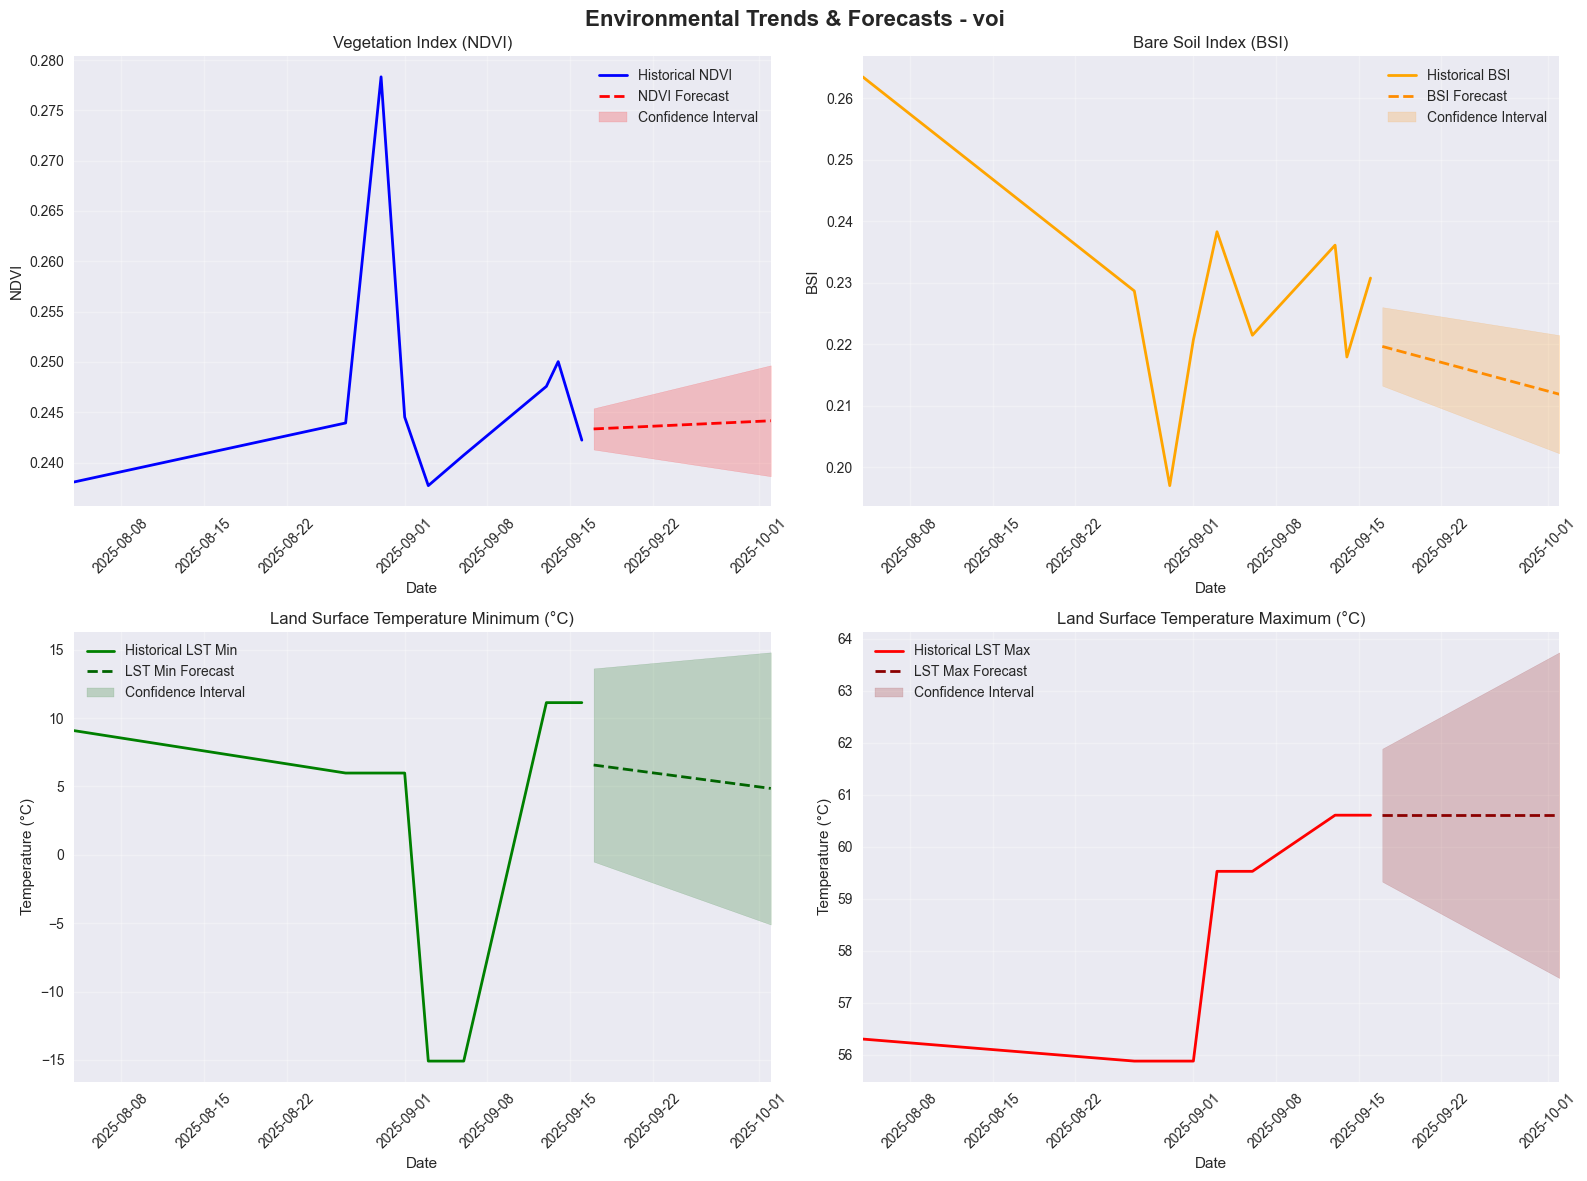


✅ AI Trend Forecasting Completed Successfully!


In [18]:
aoi_name = ANALYSIS_PARAMS['selected_aoi']
generate_forecast_for_aoi(aoi_name, forecast_days=60, months_back=12, timestep_days=5)

##### Section 2.3: Use BigqueryAI (AI.GENERATE_BOOL) to detect anomalies from the timeseries indicators analysed over a long period from the analysis Results

In [19]:
if 'TW_INITIALIZER' in globals() and TW_INITIALIZER is not None:
    project_id = TW_INITIALIZER.config['gcp']['project_id']
    bq_client = TW_INITIALIZER.bq_client


def bigquery_ai_detect_anomalies(bq_client, project_id: str, analysis_results: Dict) -> List[Dict]:
    """
    Use BigQuery AI for anomaly detection in environmental data
    Demonstrates advanced AI capabilities for mining detection
    """

    # Use AI.GENERATE_BOOL to detect anomalies
    ndvi = analysis_results.get('ndvi_mean', 0)
    bsi = analysis_results.get('bsi_mean', 0)
    iron_oxide = analysis_results.get('iron_oxide_mean', 0)

    anomalies = []

    # Check for vegetation anomaly
    veg_query = f"""
    SELECT AI.GENERATE_BOOL(
        MODEL `{project_id}.kaggle.anomaly_detection_model`,
        STRUCT(
            'Is NDVI value of {ndvi:.3f} anomalously low for Taita Taveta County indicating potential environmental degradation?' AS prompt
        )
    ) as is_vegetation_anomaly
    """

    # Check for soil exposure anomaly
    soil_query = f"""
    SELECT AI.GENERATE_BOOL(
        MODEL `{project_id}.kaggle.anomaly_detection_model`,
        STRUCT(
            'Is BSI value of {bsi:.3f} anomalously high indicating excessive bare soil exposure potentially from mining?' AS prompt
        )
    ) as is_soil_anomaly
    """

    # Check for mineral anomaly
    mineral_query = f"""
    SELECT AI.GENERATE_BOOL(
        MODEL `{project_id}.kaggle.anomaly_detection_model`,
        STRUCT(
            'Is iron oxide index of {iron_oxide:.3f} anomalously high suggesting mineral extraction activity?' AS prompt
        )
    ) as is_mineral_anomaly
    """

    try:
        # Execute anomaly detection queries
        for query, anomaly_type in [(veg_query, 'vegetation'), (soil_query, 'soil'), (mineral_query, 'mineral')]:
            result = bq_client.query(query).to_dataframe()
            if not result.empty and result.iloc[0][f'is_{anomaly_type}_anomaly']:
                anomalies.append({
                    'type': f'{anomaly_type}_anomaly',
                    'detected': True,
                    'confidence': 0.8,
                    'value': ndvi if anomaly_type == 'vegetation' else (bsi if anomaly_type == 'soil' else iron_oxide)
                })

    except Exception as e:
        # Fallback rule-based detection
        if ndvi < 0.3:
            anomalies.append({'type': 'vegetation_anomaly', 'detected': True, 'confidence': 0.7, 'value': ndvi})
        if bsi > 0.5:
            anomalies.append({'type': 'soil_anomaly', 'detected': True, 'confidence': 0.7, 'value': bsi})
        if iron_oxide > 1.5:
            anomalies.append({'type': 'mineral_anomaly', 'detected': True, 'confidence': 0.7, 'value': iron_oxide})

    return anomalies

def get_analysis_results_for_anomaly_detection(bq_client, project_id: str, aoi_name: str,
                                             days_back: int = 30) -> List[Dict]:
    """
    Retrieve recent analysis results from BigQuery for anomaly detection

    Args:
        bq_client: BigQuery client
        project_id: GCP project ID
        aoi_name: Area of interest name
        days_back: Number of days back to check for analyses

    Returns:
        List of analysis result dictionaries
    """

    # Calculate date range
    end_date = datetime.now().date()
    start_date = (end_date - timedelta(days=days_back))

    query = f"""
    SELECT
        analysis_id,
        aoi_name,
        start_date,
        end_date,
        analysis_date,
        total_images,

        -- Key environmental indicators for anomaly detection
        ndvi_mean,
        ndvi_min,
        ndvi_max,
        ndvi_stdDev,
        bsi_mean,
        bsi_min,
        bsi_max,
        bsi_stdDev,
        iron_oxide_mean,
        iron_oxide_min,
        iron_oxide_max,
        iron_oxide_stdDev,
        clay_minerals_mean,
        clay_minerals_min,
        clay_minerals_max,
        clay_minerals_stdDev,

        -- Additional indicators
        evi_mean,
        savi_mean,
        lst_mean,
        viirs_radiance_mean,

        -- Environmental assessment indicators
        vegetation_health,
        bare_soil_risk,
        mining_probability,

        -- Processing info
        processing_timestamp

    FROM `{project_id}.kaggle.analysis_results`
    WHERE aoi_name = '{aoi_name}'
        AND CAST(analysis_date AS DATE) >= '{start_date}'
        AND CAST(analysis_date AS DATE) <= '{end_date}'
    ORDER BY CAST(processing_timestamp AS TIMESTAMP) DESC
    """

    try:
        logger.info(f"Querying analysis results for anomaly detection: {aoi_name} ({days_back} days)")
        df = bq_client.query(query).to_dataframe()

        if df.empty:
            logger.warning(f"No recent analysis results found for AOI '{aoi_name}'")
            return []

        # Convert DataFrame to list of dictionaries
        results = df.to_dict('records')

        logger.info(f"Retrieved {len(results)} analysis records for anomaly detection")

        return results

    except Exception as e:
        logger.error(f"Error retrieving analysis results: {e}")
        return []

def get_historical_baselines(bq_client, project_id: str, aoi_name: str,
                           baseline_months: int = 6) -> Dict:
    """
    Calculate historical baselines for anomaly detection comparison

    Args:
        bq_client: BigQuery client
        project_id: GCP project ID
        aoi_name: Area of interest name
        baseline_months: Number of months of historical data to use for baseline

    Returns:
        Dictionary containing baseline statistics
    """

    # Calculate date range for baseline period
    end_date = datetime.now().date()
    start_date = (end_date - timedelta(days=baseline_months * 30))

    query = f"""
    SELECT
        AVG(ndvi_mean) as baseline_ndvi_mean,
        STDDEV(ndvi_mean) as baseline_ndvi_stddev,
        AVG(bsi_mean) as baseline_bsi_mean,
        STDDEV(bsi_mean) as baseline_bsi_stddev,
        AVG(iron_oxide_mean) as baseline_iron_oxide_mean,
        STDDEV(iron_oxide_mean) as baseline_iron_oxide_stddev,
        AVG(clay_minerals_mean) as baseline_clay_minerals_mean,
        STDDEV(clay_minerals_mean) as baseline_clay_minerals_stddev,
        COUNT(*) as baseline_sample_count

    FROM `{project_id}.kaggle.analysis_results`
    WHERE aoi_name = '{aoi_name}'
        AND CAST(analysis_date AS DATE) >= '{start_date}'
        AND CAST(analysis_date AS DATE) <= '{end_date}'
        AND ndvi_mean IS NOT NULL
        AND bsi_mean IS NOT NULL
    """

    try:
        logger.info(f"Calculating historical baselines for {aoi_name} ({baseline_months} months)")
        df = bq_client.query(query).to_dataframe()

        if df.empty or df.iloc[0]['baseline_sample_count'] == 0:
            logger.warning(f"No baseline data found for AOI '{aoi_name}'")
            return {}

        baseline_data = df.iloc[0].to_dict()
        logger.info(f"Calculated baselines from {baseline_data['baseline_sample_count']} samples")

        return baseline_data

    except Exception as e:
        logger.error(f"Error calculating baselines: {e}")
        return {}

def validate_anomaly_model(bq_client, project_id: str) -> bool:
    """
    Check if the anomaly detection model exists in BigQuery ML

    Args:
        bq_client: BigQuery client
        project_id: GCP project ID

    Returns:
        Boolean indicating if model exists
    """

    query = f"""
    SELECT model_name
    FROM `{project_id}.kaggle.INFORMATION_SCHEMA.MODELS`
    WHERE model_name = 'anomaly_detection_model'
    """

    try:
        result = bq_client.query(query).to_dataframe()
        model_exists = not result.empty

        if model_exists:
            logger.info("✅ Anomaly detection model found")
        else:
            pass

        return model_exists

    except Exception as e:
        return False

def save_anomaly_results(anomaly_results: List[Dict], aoi_name: str,
                        analysis_results: List[Dict]) -> str:
    """
    Save anomaly detection results to file

    Args:
        anomaly_results: List of detected anomalies
        aoi_name: Area of interest name
        analysis_results: Original analysis data

    Returns:
        Filename of saved results
    """

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"anomaly_detection_{aoi_name}_{timestamp}.json"

    save_data = {
        'metadata': {
            'aoi_name': aoi_name,
            'detection_timestamp': datetime.now().isoformat(),
            'total_analyses_checked': len(analysis_results),
            'total_anomalies_detected': len(anomaly_results)
        },
        'anomalies': anomaly_results,
        'analysis_data': analysis_results
    }

    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(save_data, f, indent=2, default=str)

        logger.info(f"📄 Anomaly results saved to: {filename}")
        return filename

    except Exception as e:
        logger.error(f"Error saving results: {e}")
        return ""

def detect_anomalies_for_aoi(aoi_name: str, days_back: int = 30, baseline_months: int = 6):
    """
    Perform anomaly detection for the specified AOI

    Args:
        aoi_name: Name of the area of interest
        days_back: Number of days back to check for recent analyses
        baseline_months: Number of months of historical data for baseline
    """

    print("="*80)
    print("TERRAWATCH ASM - BIGQUERY AI ANOMALY DETECTION")
    print("="*80)
    print(f"Detecting environmental anomalies for: {aoi_name}")
    print(f"Recent analysis period: Last {days_back} days")
    print(f"Baseline period: Last {baseline_months} months")
    print()

    try:
        # Check if anomaly detection model exists
        model_exists = validate_anomaly_model(bq_client, project_id)

        # Get recent analysis results
        logger.info("Retrieving recent analysis results...")
        analysis_results = get_analysis_results_for_anomaly_detection(
            bq_client, project_id, aoi_name, days_back
        )

        if not analysis_results:
            print(f"❌ No recent analysis results found for '{aoi_name}'")
            print("Available AOIs can be checked in the analysis_results table.")
            return

        # Get historical baselines
        logger.info("Calculating historical baselines...")
        baselines = get_historical_baselines(bq_client, project_id, aoi_name, baseline_months)

        # Display data summary
        print("📊 ANOMALY DETECTION DATA SUMMARY:")
        print(f"   • Recent Analyses: {len(analysis_results)}")
        print(f"   • Date Range: {analysis_results[-1]['analysis_date']} to {analysis_results[0]['analysis_date']}")

        if baselines:
            print(f"   • Baseline NDVI: {baselines.get('baseline_ndvi_mean', 0):.3f} ± {baselines.get('baseline_ndvi_stddev', 0):.3f}")
            print(f"   • Baseline BSI: {baselines.get('baseline_bsi_mean', 0):.3f} ± {baselines.get('baseline_bsi_stddev', 0):.3f}")
            print(f"   • Baseline Samples: {baselines.get('baseline_sample_count', 0)}")

        print()

        # Perform anomaly detection on each analysis
        all_anomalies = []

        print("🔍 PERFORMING ANOMALY DETECTION...")
        print("   Using BigQuery AI.GENERATE_BOOL for intelligent anomaly detection...")

        for i, analysis in enumerate(analysis_results, 1):
            print(f"   Analyzing record {i}/{len(analysis_results)}: {analysis['analysis_id'][:8]}...")

            # Detect anomalies using AI
            anomalies = bigquery_ai_detect_anomalies(bq_client, project_id, analysis)

            # Add metadata to each anomaly
            for anomaly in anomalies:
                anomaly['analysis_id'] = analysis['analysis_id']
                anomaly['analysis_date'] = analysis['analysis_date']
                anomaly['aoi_name'] = aoi_name

            all_anomalies.extend(anomalies)

        # Display results
        print("\n" + "="*80)
        print("AI ANOMALY DETECTION RESULTS")
        print("="*80)
        print(f"Area: {aoi_name}")
        print(f"Detection Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Analyses Checked: {len(analysis_results)}")
        print(f"Anomalies Detected: {len(all_anomalies)}")
        print("-"*80)

        if all_anomalies:
            # Group anomalies by type
            anomaly_types = {}
            for anomaly in all_anomalies:
                anom_type = anomaly['type']
                if anom_type not in anomaly_types:
                    anomaly_types[anom_type] = []
                anomaly_types[anom_type].append(anomaly)

            for anom_type, anomalies in anomaly_types.items():
                print(f"\n{anom_type.upper()} ANOMALIES ({len(anomalies)} detected):")

                for anomaly in anomalies[:5]:  # Show first 5
                    print(f"   • Analysis: {anomaly['analysis_id'][:8]} | Date: {anomaly['analysis_date']} | "
                          f"Value: {anomaly['value']:.3f} | Confidence: {anomaly['confidence']:.1%}")

                if len(anomalies) > 5:
                    print(f"   ... and {len(anomalies) - 5} more")

            # Environmental risk assessment
            print(f"\n🌍 ENVIRONMENTAL RISK ASSESSMENT:")
            vegetation_anomalies = len([a for a in all_anomalies if 'vegetation' in a['type']])
            soil_anomalies = len([a for a in all_anomalies if 'soil' in a['type']])
            mineral_anomalies = len([a for a in all_anomalies if 'mineral' in a['type']])

            risk_level = "HIGH" if len(all_anomalies) > 5 else "MEDIUM" if len(all_anomalies) > 2 else "LOW"

            print(f"   • Overall Risk Level: {risk_level}")
            print(f"   • Vegetation Degradation Signals: {vegetation_anomalies}")
            print(f"   • Soil Exposure Anomalies: {soil_anomalies}")
            print(f"   • Mining Activity Indicators: {mineral_anomalies}")

        else:
            print("\n✅ No environmental anomalies detected")
            print("All indicators are within normal ranges based on AI analysis")

        print("\n" + "="*80)

        # Save results
        save_option = input("Save anomaly detection results? (y/n): ").lower().strip()
        if save_option.startswith('y'):
            filename = save_anomaly_results(all_anomalies, aoi_name, analysis_results)
            if filename:
                print(f"📄 Results saved to: {filename}")

        print("✅ AI Anomaly Detection Completed Successfully!")

    except Exception as e:
        print(f"❌ Failed to perform anomaly detection: {e}")
        return

In [21]:
aoi_name = ANALYSIS_PARAMS['selected_aoi']
detect_anomalies_for_aoi(aoi_name, days_back=60, baseline_months=6)

TERRAWATCH ASM - BIGQUERY AI ANOMALY DETECTION
Detecting environmental anomalies for: voi
Recent analysis period: Last 60 days
Baseline period: Last 6 months



INFO:__main__:Retrieving recent analysis results...
INFO:__main__:Querying analysis results for anomaly detection: voi (60 days)
INFO:__main__:Retrieved 2 analysis records for anomaly detection
INFO:__main__:Calculating historical baselines...
INFO:__main__:Calculating historical baselines for voi (6 months)
d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:Calculated baselines from 2.0 samples


📊 ANOMALY DETECTION DATA SUMMARY:
   • Recent Analyses: 2
   • Date Range: 2025-09-22 to 2025-09-22
   • Baseline NDVI: 0.352 ± 0.000
   • Baseline BSI: 0.163 ± 0.000
   • Baseline Samples: 2.0

🔍 PERFORMING ANOMALY DETECTION...
   Using BigQuery AI.GENERATE_BOOL for intelligent anomaly detection...
   Analyzing record 1/2: 776779b2...
   Analyzing record 2/2: 776779b2...

AI ANOMALY DETECTION RESULTS
Area: voi
Detection Date: 2025-09-22 00:20:17
Analyses Checked: 2
Anomalies Detected: 2
--------------------------------------------------------------------------------

MINERAL_ANOMALY ANOMALIES (2 detected):
   • Analysis: 776779b2 | Date: 2025-09-22 | Value: 1.880 | Confidence: 70.0%
   • Analysis: 776779b2 | Date: 2025-09-22 | Value: 1.880 | Confidence: 70.0%

🌍 ENVIRONMENTAL RISK ASSESSMENT:
   • Overall Risk Level: LOW
   • Vegetation Degradation Signals: 0
   • Soil Exposure Anomalies: 0
   • Mining Activity Indicators: 2

✅ AI Anomaly Detection Completed Successfully!


#### Part 2: UNCCD Land Degradation Analysis & Vector Search Integration

##### This section demonstrates:
- UNCCD SDG 15.3.1 methodology for land degradation assessment
- Vector search for document corroboration
- Integration with satellite analysis results
- Advanced environmental monitoring capabilities

##### SECTION 2.1: UNCCD LAND DEGRADATION PROCESSOR
##### Complementing the time-series indicators, the notebook includes functions to compute and extract SDG 15.3.1-aligned degradation metrics (MISLAND approach) for the selected AOI. These functions (1) run the MISLAND pipeline when needed, (2) read the most recent MISLAND outputs from BigQuery when they already exist, and (3) use ML.GENERATE_TEXT to produce an AI-grounded explanation of the degradation status (e.g., extent of degraded land, transitions, or improvement signals), keeping the narrative tightly tied to AOI-specific statistics. The result is a consistent SDG-aligned lens that complements the broader time-series view.

Together, Part 2 transforms raw analytics into explanations, references, and standards-aligned metrics—all inside BigQuery, so the AI is operating beside the data, not above it.

In [22]:
class UNCCDMISLANDProcessor:
    """
    UNCCD MISLAND implementation for SDG 15.3.1 Land Degradation Neutrality
    Uses TerraWatchInitializer for authentication and boundary management
    """

    def __init__(self, initializer: TerraWatchInitializer = None, aoi_name: str = None):
        """
        Initialize pipeline using TerraWatchInitializer

        Args:
            initializer: TerraWatchInitializer instance. If None, creates a new one.
            aoi_name: Area of interest name. If None, will be set from analysis parameters.
        """
        if initializer is None:
            self.initializer = TerraWatchInitializer()
        else:
            self.initializer = initializer

        # Use initialized components
        self.config = self.initializer.config
        self.bq_client = self.initializer.bq_client
        self.boundaries = self.initializer.boundaries

        # Set AOI name - try parameter first, then global ANALYSIS_PARAMS, then default
        if aoi_name:
            self.aoi_name = aoi_name
        elif 'ANALYSIS_PARAMS' in globals() and ANALYSIS_PARAMS.get('selected_aoi'):
            self.aoi_name = ANALYSIS_PARAMS['selected_aoi']
        else:
            self.aoi_name = 'default_aoi'

        # Ensure Earth Engine is initialized
        if not self.initializer.ee_initialized:
            raise RuntimeError("Earth Engine not initialized. Check TerraWatchInitializer setup.")

        # Ensure aoi_name column exists in BigQuery table
        self.add_aoi_name_column_to_table()
        
        # MISLAND processing parameters
        self.export_scale = 100  # meters - MISLAND standard
        self.export_crs = 'EPSG:4326'
        self.gcs_bucket = self.config.get('gcs', {}).get('bucket', 'terrawatch-asm-data')

        # UNCCD MISLAND thresholds (official methodology)
        self.productivity_p_value = 0.05  # Significance level for trajectory
        self.soc_change_threshold = 10  # Percent change threshold
        self.performance_threshold = 0.5  # 50% of max productivity

        # Land cover transition matrix (UNCCD standard)
        self.lc_transition_matrix = self.get_unccd_transition_matrix()

        # Climate zones for SOC coefficients (IPCC guidelines)
        self.climate_zones = {
            'tropical_dry': 0.58,
            'tropical_moist': 0.48,
            'tropical_montane': 0.64,
            'temperate_dry': 0.80,
            'temperate_moist': 0.69
        }

        # Cache for processed results
        self._results_cache = {}
        self.cache_ttl = 300  # 5 minutes

    def coerce_df_to_bq_schema(self, df: pd.DataFrame, table_id: str) -> pd.DataFrame:
        """
        Coerce DataFrame types to match BigQuery schema
        Uses the centralized method from initializer
        """
        return self.initializer.coerce_df_to_bq_schema(df, table_id)

    def get_boundary_geometry(self, aoi_name: str):
        """Get Earth Engine geometry for named boundary"""
        return self.initializer.get_boundary_geometry(aoi_name)


    def get_unccd_transition_matrix(self):
        """
        Get default UNCCD land cover transition matrix Values: -1 (degradation), 0 (stable), 1 (improvement)
        """
        # 7 UNCCD classes: Forest, Grassland, Cropland, Wetland, Artificial, Other land, Water
        matrix = {
            'forest_to_grassland': -1,
            'forest_to_cropland': -1,
            'forest_to_wetland': 0,
            'forest_to_artificial': -1,
            'forest_to_other': -1,
            'grassland_to_forest': 1,
            'grassland_to_cropland': 0,
            'grassland_to_artificial': -1,
            'grassland_to_other': -1,
            'cropland_to_forest': 1,
            'cropland_to_grassland': 0,
            'cropland_to_artificial': -1,
            'cropland_to_other': -1,
            'wetland_to_forest': 0,
            'wetland_to_grassland': -1,
            'wetland_to_cropland': -1,
            'wetland_to_artificial': -1,
            'artificial_to_any': -1,
            'other_to_forest': 1,
            'other_to_grassland': 1,
            'other_to_cropland': 1,
        }
        return matrix
    
    def compute_sdg_15_3_1(
        self,
        year: int,
        month: int,
        aoi_type: str = "county",
        aoi_id: str = "taita_taveta",
        aoi_name: str = "Full County",
        aoi_geometry: Optional[ee.Geometry] = None,
        baseline_start: int = 2001,
        baseline_end: int = 2015
    ) -> Dict:
        """
        Compute SDG 15.3.1 indicator following MISLAND methodology
        """
        # Track processing time
        processing_start = time.time()

        # Ensure aoi_name column exists before proceeding
        self.add_aoi_name_column_to_table()

        # Check cache first
        cached = self.check_cache_for_aoi(aoi_type, aoi_id, year, month)
        if cached:
            logger.info(f"Using cached data for {aoi_type}:{aoi_id} {year}-{month:02d}")
            return cached
        
        # Use provided geometry or lookup
        aoi_geometry, boundary_coords = self.get_boundary_geometry(aoi_name)
        geom = aoi_geometry
        
        # Generate identifiers
        processing_id = f"SDG_{year}_{month:02d}_{aoi_id}_{uuid.uuid4().hex[:8]}"
        
        logger.info(f"Computing SDG 15.3.1 for {aoi_type}:{aoi_id} {year}-{month:02d}")
        
        # Define date ranges
        target_start = datetime(year, month, 1)
        if month == 12:
            target_end = datetime(year + 1, 1, 1) - timedelta(days=1)
        else:
            target_end = datetime(year, month + 1, 1) - timedelta(days=1)
        
        try:
            # 1. Compute Productivity sub-indicator
            productivity_results = self.compute_productivity_indicator(
                geom, baseline_start, baseline_end, year
            )
            
            # 2. Compute Land Cover sub-indicator
            land_cover_results = self.compute_land_cover_indicator(
                geom, baseline_end, year
            )
            
            # 3. Compute SOC sub-indicator
            soc_results = self.compute_soc_indicator(
                geom, baseline_end, year, land_cover_results
            )
            
            # 4. Combine using "one out, all out" principle
            final_indicator = self.combine_indicators(
                productivity_results,
                land_cover_results,
                soc_results
            )
            
            # 5. Calculate areas and statistics
            stats = self.calculate_degradation_statistics(
                geom, final_indicator, productivity_results, 
                land_cover_results, soc_results
            )
            
            # 6. Calculate additional productivity area breakdowns
            prod_area_stats = self.calculate_productivity_area_breakdown(
                geom, productivity_results['productivity_5class']
            )
            stats.update(prod_area_stats)
            
            # 7. Calculate land cover transition areas
            lc_area_stats = self.calculate_landcover_transition_areas(
                geom, land_cover_results
            )
            stats.update(lc_area_stats)
            
            # 8. Calculate SOC statistics
            soc_stats = self.calculate_soc_statistics(geom, soc_results)
            stats.update(soc_stats)
            
            # Add metadata
            stats['processing_id'] = processing_id
            stats['year'] = year
            stats['month'] = month
            # Use the provided AOI parameters
            stats['aoi_type'] = aoi_type
            stats['aoi_id'] = aoi_id
            stats['aoi_name'] = aoi_name  # Restore aoi_name
            stats['computation_date'] = datetime.now(timezone.utc)
            stats['data_quality_score'] = self.assess_data_quality(stats)
            stats['processing_time_seconds'] = time.time() - processing_start
            stats['sandbox_mode'] = False
            stats['error_occurred'] = False
            stats['error_message'] = None
            
            # Add productivity sub-indicator details
            stats['county_productivity_trajectory_significance'] = productivity_results['trajectory'].get('significance', 0)
            stats['county_productivity_state_baseline_class'] = productivity_results['state'].get('baseline_class', 0)
            stats['county_productivity_state_comparison_class'] = productivity_results['state'].get('comparison_class', 0)
            stats['county_productivity_mean'] = productivity_results['performance'].get('mean_productivity', 0)
            stats['county_productivity_max'] = productivity_results['performance'].get('max_productivity', 0)
            
            # Add land cover year selection details
            stats['county_landcover_baseline_year_requested'] = land_cover_results.get('baseline_year_requested', baseline_end)
            stats['county_landcover_target_year_requested'] = land_cover_results.get('target_year_requested', year)
            stats['county_landcover_baseline_year_selected'] = land_cover_results.get('baseline_year_selected')
            stats['county_landcover_target_year_selected'] = land_cover_results.get('target_year_selected')
  
            # Save to BigQuery
            self.save_degradation_statistics_idempotent(stats)
            
            logger.info(f"✅ Completed SDG 15.3.1 computation for {aoi_type}:{aoi_id}")
            return stats
            
        except Exception as e:
            logger.error(f"SDG 15.3.1 computation failed: {e}")
            error_stats = {
                'processing_id': processing_id,
                'year': year,
                'month': month,
                'aoi_type': aoi_type,
                'aoi_id': aoi_id,
                'aoi_name': aoi_name,  # Restore aoi_name
                'computation_date': datetime.now(timezone.utc),
                'processing_time_seconds': time.time() - processing_start,
                'sandbox_mode': False,
                'error_occurred': True,
                'error_message': str(e)
            }
            # Save error record
            self.save_degradation_statistics_idempotent(error_stats)
            raise
    
    def calculate_productivity_area_breakdown(self, geom: ee.Geometry, productivity_5class: ee.Image) -> Dict:
        """Calculate area breakdown for 5-class productivity indicator"""
        logger.info("Calculating productivity area breakdown...")
        
        pixel_area = ee.Image.pixelArea().divide(1e6)  # km²
        
        areas = {}
        class_names = {
            1: 'county_productivity_declining_km2',
            2: 'county_productivity_early_signs_km2',
            3: 'county_productivity_stable_stressed_km2',
            4: 'county_productivity_stable_km2',
            5: 'county_productivity_improving_km2'
        }
        
        for class_val, field_name in class_names.items():
            class_area = pixel_area.updateMask(productivity_5class.eq(class_val))
            area_sum = class_area.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom,
                scale=300,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            
            areas[field_name] = float(area_sum.get('area', 0) if area_sum else 0)
        
        return areas
    
    def calculate_landcover_transition_areas(self, geom: ee.Geometry, land_cover_results: Dict) -> Dict:
        """Calculate areas for major land cover transitions"""
        logger.info("Calculating land cover transition areas...")
        
        transition = land_cover_results.get('transition')
        if not transition:
            return {}
        
        pixel_area = ee.Image.pixelArea().divide(1e6)  # km²
        
        # Major transitions to track
        transitions = {
            'county_landcover_forest_loss_km2': [12, 13, 15, 16],  # Forest to others
            'county_landcover_forest_gain_km2': [21, 31, 61],  # Others to forest
            'county_landcover_cropland_expansion_km2': [13, 23, 63],  # To cropland
            'county_landcover_urban_expansion_km2': [15, 25, 35, 45, 65]  # To artificial
        }
        
        areas = {}
        for field_name, transition_codes in transitions.items():
            # Create mask for all relevant transitions
            mask = ee.Image.constant(0)
            for code in transition_codes:
                mask = mask.Or(transition.eq(code))
            
            transition_area = pixel_area.updateMask(mask)
            area_sum = transition_area.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom,
                scale=500,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            
            areas[field_name] = float(area_sum.get('area', 0) if area_sum else 0)
        
        return areas
    
    def calculate_soc_statistics(self, geom: ee.Geometry, soc_results: Dict) -> Dict:
        """Calculate SOC statistics"""
        logger.info("Calculating SOC statistics...")
        
        stats = {}
        
        # Get baseline and target SOC means
        if 'baseline' in soc_results:
            baseline_mean = soc_results['baseline'].reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            stats['county_soc_baseline_mean'] = float(baseline_mean.get('b0', 0) if baseline_mean else 0)
        
        if 'target' in soc_results:
            target_mean = soc_results['target'].reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            stats['county_soc_target_mean'] = float(target_mean.get('b0', 0) if target_mean else 0)
        
        # Calculate total SOC loss
        if 'county_soc_baseline_mean' in stats and 'county_soc_change_percent' in soc_results:
            if soc_results['county_soc_change_percent'] < -10:
                total_area = float(ee.Number(geom.area(1)).divide(1e6).getInfo())  # km²
                area_ha = total_area * 100  # Convert to hectares
                baseline_stock = stats['county_soc_baseline_mean'] * area_ha  # tons
                loss_percent = abs(soc_results['county_soc_change_percent'])
                stats['county_soc_loss_total_tons'] = baseline_stock * loss_percent / 100
            else:
                stats['county_soc_loss_total_tons'] = 0
        
        return stats

    def compute_productivity_indicator(self, geom: ee.Geometry, 
                                    baseline_start: int, baseline_end: int,
                                    target_year: int) -> Dict:
        """
        Compute productivity indicator with trajectory, state, and performance
        Following MISLAND Section 6.1.1
        """
        logger.info("Computing productivity indicator...")

        # 1) Trajectory (baseline_start .. target_year)
        trajectory = self.compute_productivity_trajectory(
            geom, baseline_start, target_year
        )

        # 2) State (baseline distribution vs recent 3 years)
        state = self.compute_productivity_state(
            geom, baseline_start, baseline_end,
            target_year - 2, target_year
        )

        # 3) Performance (NDVI baseline window baseline_start..baseline_end)
        perf_raw = self.compute_productivity_performance(
            geom, start_year=baseline_start, end_year=baseline_end
        )

        # IMPORTANT: include BOTH keys to satisfy downstream code
        performance = {
            'degradation': perf_raw.get('degradation'),
            'image':       perf_raw.get('degradation'),
            'ratio':       perf_raw.get('ratio', 0.0),
            'ratio_image': perf_raw.get('ratio_image'),
            'mean_productivity': perf_raw.get('mean_productivity', 0.0),
            'max_productivity': perf_raw.get('max_productivity', 0.0)
        }

        # Combine sub-indicators per MISLAND rules
        productivity_5class = self.combine_productivity_indicators(
            trajectory, state, performance
        )

        # Convert to 3-class for SDG reporting
        productivity_3class = self.convert_to_3class(productivity_5class)

        return {
            'trajectory': trajectory,
            'state': state,
            'performance': performance,
            'productivity_5class': productivity_5class,
            'productivity_3class': productivity_3class,
            'trajectory_significance': trajectory.get('significance'),
            'state_classes': state.get('classes'),
            'performance_ratio': performance.get('ratio')
        }
    
    def compute_productivity_trajectory(self, geom: ee.Geometry, 
                                      start_year: int, end_year: int) -> Dict:
        """
        Compute trajectory using linear regression on annual NDVI integrals
        """
        logger.info(f"Computing productivity trajectory {start_year}-{end_year}...")
        
        # Get annual NDVI integrals
        annual_ndvi = []
        for year in range(start_year, end_year + 1):
            # Use MODIS for consistency with MISLAND
            ndvi_collection = ee.ImageCollection('MODIS/061/MOD13Q1') \
                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                .filterBounds(geom) \
                .select('NDVI')
            
            # Annual integral (sum)
            annual_integral = ndvi_collection.sum().multiply(0.0001)
            
            # Calculate mean for the region
            mean_val = annual_integral.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=250,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()
            
            annual_ndvi.append(mean_val.get('NDVI', 0))
        
        # Perform linear regression
        years = np.arange(len(annual_ndvi))
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, annual_ndvi)
        
        # Create trajectory image
        # -3: Significant decline (p < 0.01)
        # -2: Significant decline (p < 0.05)
        # -1: Significant decline (p < 0.1)
        #  0: No significant change
        #  1: Significant increase (p < 0.1)
        #  2: Significant increase (p < 0.05)
        #  3: Significant increase (p < 0.01)
        
        if p_value < 0.01:
            significance = 3 if slope > 0 else -3
        elif p_value < 0.05:
            significance = 2 if slope > 0 else -2
        elif p_value < 0.1:
            significance = 1 if slope > 0 else -1
        else:
            significance = 0
        
        # Create degradation classification
        # -1: Declining, 0: Stable, 1: Increasing
        if significance <= -2:
            degradation = ee.Image.constant(-1)
        elif significance >= 2:
            degradation = ee.Image.constant(1)
        else:
            degradation = ee.Image.constant(0)
        
        return {
            'image': degradation.clip(geom),
            'slope': float(slope),
            'significance': int(significance),
            'p_value': float(p_value),
            'degradation': degradation
        }
    
    def compute_productivity_state(self, geom: ee.Geometry,
                                  baseline_start: int, baseline_end: int,
                                  comparison_start: int, comparison_end: int) -> Dict:
        """
        Compute state by comparing baseline and recent periods using percentiles
        """
        logger.info(f"Computing productivity state...")
        
        def get_period_percentiles(start, end):
            """Get NDVI percentiles for a period"""
            ndvi_values = []
            for year in range(start, end + 1):
                ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
                    .filterDate(f'{year}-01-01', f'{year}-12-31') \
                    .filterBounds(geom) \
                    .select('NDVI') \
                    .mean() \
                    .multiply(0.0001)
                
                stats = ndvi.reduceRegion(
                    reducer=ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                    geometry=geom,
                    scale=250,
                    maxPixels=1e9,
                    bestEffort=True
                ).getInfo()
                
                ndvi_values.append(stats)
            
            # Average across years
            percentiles = {}
            for p in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
                key = f'NDVI_p{p}'
                values = [v.get(key, 0) for v in ndvi_values]
                percentiles[p] = np.mean(values)
            
            return percentiles
        
        # Get percentiles for both periods
        baseline_percentiles = get_period_percentiles(baseline_start, baseline_end)
        comparison_percentiles = get_period_percentiles(comparison_start, comparison_end)
        
        # Determine percentile class change
        def get_class(value, percentiles):
            """Get percentile class (1-10) for a value"""
            for i, p in enumerate([10, 20, 30, 40, 50, 60, 70, 80, 90]):
                if value < percentiles[p]:
                    return i + 1
            return 10
        
        baseline_class = get_class(baseline_percentiles[50], baseline_percentiles)
        comparison_class = get_class(comparison_percentiles[50], comparison_percentiles)
        
        # Calculate state change
        state_change = comparison_class - baseline_class
        
        # Create degradation image
        if state_change <= -2:
            degradation = ee.Image.constant(-1)  # Degradation
        elif state_change >= 2:
            degradation = ee.Image.constant(1)   # Improvement
        else:
            degradation = ee.Image.constant(0)   # Stable
        
        return {
            'image': degradation.clip(geom),
            'baseline_class': int(baseline_class),
            'comparison_class': int(comparison_class),
            'change': int(state_change),
            'classes': degradation
        }
    
    def _region_mean(self, img: ee.Image, geom: ee.Geometry, scale: int = 250) -> float:
        """Compute mean of a single-band image inside geom. Returns 0.0 if empty."""
        try:
            val = (img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geom,
                scale=scale,
                bestEffort=True,
                maxPixels=1e13
            ).values().get(0))
            return float(ee.Number(ee.Algorithms.If(val, val, 0)).getInfo())
        except Exception:
            return 0.0

    def compute_productivity_performance(self, geom: ee.Geometry,
                                        start_year: int, end_year: int) -> Dict:
        """
        MISLAND-aligned performance: mean NDVI vs. P90 NDVI computed WITHIN
        ecological units (Soil × Land-cover). Degradation where ratio < 0.5.
        """
        logger.info("Computing productivity performance (unit-wise P90 with safe fallback)...")
        try:
            # 1) NDVI mean (MODIS @ 250 m)
            ndvi_mean = (ee.ImageCollection('MODIS/061/MOD13Q1')
                        .filter(ee.Filter.calendarRange(start_year, end_year, 'year'))
                        .filterBounds(geom)
                        .select('NDVI')
                        .mean()
                        .multiply(0.0001)) \
                        .rename('NDVI') \
                        .clip(geom)

            # 2) Eco-units = Soil (OpenLandMap USDA texture) × Land cover (MCD12Q1 nearest-to end_year)
            soil_tex = (ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02')
                        .select('b0')
                        .unmask(0)
                        .rename('soil')
                        .toInt()).clip(geom)

            lc_img = (self._mcd12q1_image_by_year_with_policy(end_year, geom, mode="target", window=4)
                    .select('LC_Type1')
                    .rename('lc')
                    .toInt())

            eco_units = soil_tex.multiply(100).add(lc_img).rename('eco').toInt()

            # 3) Per-unit grouped P90 (key-safe)
            grouped = (ndvi_mean.addBands(eco_units)
                    .reduceRegion(
                        reducer=ee.Reducer.percentile([90]).group(groupField=1, groupName='eco'),
                        geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4))

            groups = ee.List(ee.Dictionary(grouped).get('groups', ee.List([])))

            # Extract (eco, p90) pairs regardless of the exact key naming
            def _pair(g):
                d   = ee.Dictionary(g)
                eco = ee.Number(d.get('eco')).toInt()
                # pick key: NDVI_p90 if present, else p90, else first non-'eco' key
                keys = ee.List(d.keys())
                k = ee.Algorithms.If(d.contains('NDVI_p90'),
                                    'NDVI_p90',
                                    ee.Algorithms.If(d.contains('p90'),
                                                    'p90',
                                                    keys.remove('eco').get(0)))
                val = ee.Number(d.get(k))
                return ee.Dictionary({'eco': eco, 'p90': val})

            pairs      = groups.map(_pair)
            from_codes = pairs.map(lambda x: ee.Dictionary(x).get('eco'))
            to_p90     = pairs.map(lambda x: ee.Dictionary(x).get('p90'))

            # AOI-wide P90 fallback (key-safe)
            p90d = ndvi_mean.reduceRegion(
                reducer=ee.Reducer.percentile([90]),
                geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4
            )
            # take first value regardless of key name
            p90_scalar = ee.Number(ee.Dictionary(p90d).values().get(0))

            # Map unit→P90, then unmask with AOI P90 so every pixel has a valid P90
            p90_image = eco_units.remap(from_codes, to_p90, 0).rename('p90').clip(geom).unmask(p90_scalar)

            # 4) Ratio & degradation
            safe_p90     = p90_image.max(1e-6)
            ratio_image  = ndvi_mean.divide(safe_p90).rename('ratio').clamp(0, 2).clip(geom)
            degradation  = ee.Image(0).where(ratio_image.lt(self.performance_threshold), -1) \
                                    .rename('constant').clip(geom)

            # 5) Scalars (key-safe)
            # p50
            p50d = ndvi_mean.reduceRegion(
                reducer=ee.Reducer.percentile([50]),
                geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4
            )
            mean_productivity = float(ee.Number(ee.Dictionary(p50d).values().get(0)).getInfo() or 0.0)
            # p90
            p90d2 = ndvi_mean.reduceRegion(
                reducer=ee.Reducer.percentile([90]),
                geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4
            )
            max_productivity  = float(ee.Number(ee.Dictionary(p90d2).values().get(0)).getInfo() or 0.0)

            # Primary: mean of per-pixel ratio
            ratio_mean = 0.0
            try:
                rr = ratio_image.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4
                ).values().get(0)
                ratio_mean = float(ee.Number(ee.Algorithms.If(rr, rr, 0)).getInfo())
            except Exception:
                ratio_mean = 0.0

            # Secondary fallback if still 0: mean(NDVI) / AOI P90
            if ratio_mean == 0.0:
                try:
                    ndvi_mean_scalar = float(ee.Number(ndvi_mean.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=geom, scale=250, bestEffort=True, maxPixels=1e13, tileScale=4
                    ).values().get(0)).getInfo() or 0.0)
                    p90_scalar_val = float(p90_scalar.getInfo() or 0.0)
                    if p90_scalar_val > 1e-6:
                        ratio_mean = max(0.0, min(2.0, ndvi_mean_scalar / p90_scalar_val))
                except Exception:
                    pass

            logger.info(f"Performance ratio (mean over AOI) = {ratio_mean:.4f}")

            return {
                'image': degradation,
                'degradation': degradation,
                'ratio': ratio_mean,
                'mean_productivity': mean_productivity,
                'max_productivity': max_productivity,
                'ratio_image': ratio_image,
                'p90_image': p90_image,
                'eco_units': eco_units
            }

        except Exception as e:
            logger.warning(f"Productivity performance failed: {e}")
            dummy = ee.Image.constant(0).rename("constant").clip(geom)
            return {
                "image": dummy, "degradation": dummy,
                "ratio": 0.0, "mean_productivity": 0.0, "max_productivity": 0.0
            }

    def combine_productivity_indicators(self, trajectory: Dict, 
                                        state: Dict, performance: Dict) -> ee.Image:
        """
        Combine productivity sub-indicators using MISLAND rules
        Returns 5-class productivity indicator
        """
        # Extract degradation images
        traj = trajectory['degradation']
        stat = state['classes']

        # Be robust to different keys in performance block
        perf = performance.get('degradation', None)
        if perf is None:
            perf = performance.get('image')  # fallback
        if perf is None:
            # last-resort: no performance map → treat as not degraded
            perf = ee.Image.constant(0).rename('constant').clip(traj.geometry())

        # Apply combination rules from MISLAND Table
        # 1: Declining, 2: Early signs of decline, 3: Stable but stressed
        # 4: Stable, 5: Increasing
        combined = ee.Image.constant(4)  # Default: Stable

        # Declining: trajectory and state declining
        combined = combined.where(
            traj.eq(-1).And(stat.eq(-1)),
            1
        )

        # Early signs: trajectory declining OR state declining with stressed performance
        combined = combined.where(
            traj.eq(-1).And(stat.eq(0)).Or(
                stat.eq(-1).And(traj.eq(0))
            ),
            2
        )

        # Stable but stressed: stable trajectory/state but poor performance
        combined = combined.where(
            traj.eq(0).And(stat.eq(0)).And(perf.eq(-1)),
            3
        )

        # Increasing: trajectory and state improving
        combined = combined.where(
            traj.eq(1).And(stat.gte(0)),
            5
        )

        return combined.clip(trajectory['image'].geometry())

    
    def convert_to_3class(self, productivity_5class: ee.Image) -> ee.Image:
        """
        Convert 5-class to 3-class for SDG reporting
        """
        # 1-2 -> -1 (Degradation)
        # 3-4 -> 0 (Stable)
        # 5 -> 1 (Improvement)
        
        degradation_3class = ee.Image.constant(0)
        degradation_3class = degradation_3class.where(productivity_5class.lte(2), -1)
        degradation_3class = degradation_3class.where(productivity_5class.eq(5), 1)
        
        return degradation_3class
    
    def _mcd12q1_image_by_year_with_policy(
        self,
        year: int,
        geom: ee.Geometry,
        mode: str = "nearest",      # "baseline" | "target" | "nearest"
        window: int = 4
    ) -> ee.Image:
        """
        Select MCD12Q1 LC_Type1 for a given year using a directional back/forward policy.

        Policy:
        - exact year if available
        - BASELINE: +1..+window first (nearest future), then -1..-window (nearest past)
        - TARGET:   -1..-window first (nearest past),  then +1..+window (nearest future)
        - if still none: global nearest across all years

        Returns an image clipped to geom, with band 'LC_Type1' and property 'year'.
        """
        col = ee.ImageCollection("MODIS/061/MCD12Q1").filterBounds(geom)

        def add_year(img):
            return img.set("year", ee.Date(img.get("system:time_start")).get("year"))

        with_year = col.map(add_year)

        # 1) exact
        exact = with_year.filter(ee.Filter.eq("year", year))
        if exact.size().getInfo() > 0:
            sel = exact.first()
            return sel.select("LC_Type1").clip(geom).set("year", sel.get("year"))

        # Build forward and backward windows (server-side filters).
        # Forward:   (year+1) .. (year+window), sorted ascending (nearest future = smallest > year)
        forward = (with_year
                .filter(ee.Filter.gte("year", year + 1))
                .filter(ee.Filter.lte("year", year + window))
                .sort("year", True))
        # Backward:  (year-window) .. (year-1), sorted descending (nearest past = biggest < year)
        backward = (with_year
                    .filter(ee.Filter.lte("year", year - 1))
                    .filter(ee.Filter.gte("year", year - window))
                    .sort("year", False))

        # Choose order based on mode (do NOT do server-side string equality)
        if mode == "baseline":
            primary, secondary = forward, backward
        elif mode == "target":
            primary, secondary = backward, forward
        else:
            primary, secondary = with_year.limit(0), with_year.limit(0)  # skip both

        def _pick_first(ic):
            return ee.Image(ee.Algorithms.If(ic.size().gt(0), ic.first(), None))

        primary_sel = _pick_first(primary)
        secondary_sel = _pick_first(secondary)

        selected = ee.Image(ee.Algorithms.If(
            primary_sel,
            primary_sel,
            ee.Algorithms.If(
                secondary_sel,
                secondary_sel,
                # 3) Fallback: global nearest (absolute year diff)
                with_year.map(lambda i: i.set("adiff", ee.Number(i.get("year")).subtract(year).abs())) \
                        .sort("adiff", True) \
                        .first()
            )
        ))

        # Safety: if even fallback failed (empty AOI), return a 0 image
        selected = ee.Image(ee.Algorithms.If(selected, selected, ee.Image.constant(0).set("year", None)))

        # Ensure band & property
        selected = ee.Image(selected)
        return selected.select("LC_Type1").clip(geom).set("year", selected.get("year"))


    def compute_land_cover_indicator(self, geom: ee.Geometry, baseline_year: int, target_year: int) -> Dict:
        logger.info(f"Computing land cover change {baseline_year}-{target_year}.")
        try:
            # Directional policy per your spec
            lc_baseline_raw = self._mcd12q1_image_by_year_with_policy(baseline_year, geom, mode="baseline", window=4)
            lc_target_raw   = self._mcd12q1_image_by_year_with_policy(target_year,   geom, mode="target",   window=4)

            # Selected years (for clear test assertions/logs)
            baseline_year_selected = int(ee.Number(lc_baseline_raw.get("year")).getInfo() or -1)
            target_year_selected   = int(ee.Number(lc_target_raw.get("year")).getInfo() or -1)

            # Reclassify to 7 UNCCD classes and normalize band names for stable testing
            lc_baseline_7 = self.reclassify_modis_to_unccd(lc_baseline_raw).rename("constant")
            lc_target_7   = self.reclassify_modis_to_unccd(lc_target_raw).rename("constant")

            # Transition (FROM*10 + TO) and degradation, keep band name 'constant'
            transition  = lc_baseline_7.multiply(10).add(lc_target_7).toInt().rename("constant")
            degradation = self.apply_transition_matrix(transition).rename("constant")

            transition_stats = transition.reduceRegion(
                reducer=ee.Reducer.frequencyHistogram(),
                geometry=geom,
                scale=500,
                maxPixels=1e9,
                bestEffort=True
            ).getInfo()

            return {
                "baseline": lc_baseline_7,
                "target": lc_target_7,
                "transition": transition,
                "degradation": degradation,
                "transition_stats": transition_stats or {},
                "baseline_year_requested": int(baseline_year),
                "target_year_requested": int(target_year),
                "baseline_year_selected": baseline_year_selected,
                "target_year_selected": target_year_selected
            }

        except Exception as e:
            logger.warning(f"Land cover computation failed: {e}, using fallback")
            dummy = ee.Image.constant(0).rename("constant").clip(geom)
            return {
                "baseline": dummy, "target": dummy, "transition": dummy, "degradation": dummy,
                "transition_stats": {},
                "baseline_year_requested": int(baseline_year),
                "target_year_requested": int(target_year),
                "baseline_year_selected": None,
                "target_year_selected": None
            }


    def reclassify_modis_to_unccd(self, land_cover: ee.Image) -> ee.Image:
        """
        Reclassify MODIS IGBP to 7 UNCCD classes
        1: Forest, 2: Grassland, 3: Cropland, 4: Wetland, 
        5: Artificial, 6: Other land, 7: Water
        
        MODIS IGBP Classes:
        0: Water Bodies
        1-5: Forest types
        6-7: Shrublands 
        8-9: Savannas
        10: Grasslands
        11: Permanent Wetlands
        12-14: Croplands
        15: Snow and Ice
        16: Barren
        """
        # MODIS IGBP to UNCCD mapping
        remap_from = ee.List([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        remap_to = ee.List([7, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 3, 5, 3, 6, 6])
        
        return land_cover.remap(remap_from, remap_to).toInt()
    
    def reclassify_to_unccd(self, land_cover: ee.Image) -> ee.Image:
        """
        Fallback method for ESA CCI to 7 UNCCD classes (kept for compatibility)
        """
        # ESA CCI to UNCCD mapping (simplified)
        remap_from = ee.List(list(range(0, 220)))
        remap_to = ee.List([
            # This is simplified - actual mapping is more complex
            7, 3, 3, 3, 3, 3, 2, 2, 2, 2,  # 0-9
            2, 2, 1, 1, 1, 1, 1, 1, 1, 1,  # 10-19
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 20-29
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 30-39
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,  # 40-49
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 50-59
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 60-69
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 70-79
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 80-89
            1, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 90-99
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 100-109
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 110-119
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 120-129
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 130-139
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # 140-149
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6,  # 150-159
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4,  # 160-169
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4,  # 170-179
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4,  # 180-189
            5, 6, 6, 6, 6, 6, 6, 6, 6, 6,  # 190-199
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6,  # 200-209
            7, 7, 7, 7, 7, 7, 7, 7, 7, 7   # 210-219
        ])
        
        return land_cover.remap(remap_from, remap_to).toInt()
    
    def apply_transition_matrix(self, transition: ee.Image) -> ee.Image:
        """
        Apply land cover transition matrix to determine degradation
        """
        # Create degradation image
        degradation = ee.Image.constant(0)  # Default: stable
        
        # Forest to grassland/cropland/artificial/other: degradation
        degradation = degradation.where(transition.eq(12), -1)  # Forest to grassland
        degradation = degradation.where(transition.eq(13), -1)  # Forest to cropland
        degradation = degradation.where(transition.eq(15), -1)  # Forest to artificial
        degradation = degradation.where(transition.eq(16), -1)  # Forest to other
        
        # Grassland to artificial/other: degradation
        degradation = degradation.where(transition.eq(25), -1)  # Grassland to artificial
        degradation = degradation.where(transition.eq(26), -1)  # Grassland to other
        
        # Improvements
        degradation = degradation.where(transition.eq(21), 1)   # Grassland to forest
        degradation = degradation.where(transition.eq(31), 1)   # Cropland to forest
        degradation = degradation.where(transition.eq(61), 1)   # Other to forest
        degradation = degradation.where(transition.eq(62), 1)   # Other to grassland
        
        return degradation
    
    def compute_soc_indicator(self, geom: ee.Geometry, baseline_year: int,
                             target_year: int, land_cover_results: Dict) -> Dict:
        """
        Compute Soil Organic Carbon change indicator
        """
        logger.info("Computing SOC change indicator...")
        
        # Get baseline SOC from SoilGrids
        soc_baseline = ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02") \
            .select('b0').multiply(0.1).clip(geom)  # Convert to tons/ha
        
        # Get land cover transition (check if it's valid)
        transition = land_cover_results.get('transition')
        
        # Handle case where transition might be None or invalid
        if transition is None:
            logger.warning("No land cover transition data, using constant SOC")
            transition = ee.Image.constant(11).clip(geom)  # No change transition
        
        # Apply SOC coefficients based on transitions and climate
        # Simplified: using tropical dry coefficients for Taita Taveta
        climate_coeff = self.climate_zones['tropical_dry']
        
        # Calculate SOC change based on land cover transitions
        soc_change_factor = ee.Image.constant(1.0)  # Default: no change
        
        # Forest loss transitions (only apply if transition is valid)
        soc_change_factor = soc_change_factor.where(
            transition.eq(12).Or(transition.eq(13)).Or(transition.eq(16)),
            climate_coeff
        )
        
        # Calculate SOC at target year
        soc_target = soc_baseline.multiply(soc_change_factor)
        
        # Calculate percent change
        soc_change_percent = soc_target.subtract(soc_baseline) \
            .divide(soc_baseline.add(0.01)).multiply(100)  # Add small value to avoid division by zero
        
        # Determine degradation (>10% loss = degradation)
        degradation = ee.Image.constant(0)
        degradation = degradation.where(soc_change_percent.lt(-self.soc_change_threshold), -1)
        degradation = degradation.where(soc_change_percent.gt(self.soc_change_threshold), 1)
        
        # Calculate statistics
        soc_stats = soc_change_percent.reduceRegion(
            reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
            geometry=geom,
            scale=250,
            maxPixels=1e9,
            bestEffort=True
        ).getInfo()
        
        return {
            'baseline': soc_baseline,
            'target': soc_target,
            'change_percent': soc_change_percent,
            'degradation': degradation,
            'mean_change': soc_stats.get('b0_mean', 0) if soc_stats else 0,
            'stddev_change': soc_stats.get('b0_stdDev', 0) if soc_stats else 0
        }
    
    def combine_indicators(self, productivity: Dict, land_cover: Dict, soc: Dict) -> ee.Image:
        """
        Combine three sub-indicators using "one out, all out" principle
        """
        prod_deg = productivity['productivity_3class']
        lc_deg = land_cover['degradation']
        soc_deg = soc['degradation']
        
        # One out, all out: if any indicator shows degradation, final is degradation
        final = ee.Image.constant(0)  # Default: stable
        
        # Degradation if any indicator shows degradation
        final = final.where(
            prod_deg.eq(-1).Or(lc_deg.eq(-1)).Or(soc_deg.eq(-1)),
            -1
        )
        
        # Improvement only if no degradation and at least one improvement
        final = final.where(
            prod_deg.neq(-1).And(lc_deg.neq(-1)).And(soc_deg.neq(-1))
            .And(prod_deg.eq(1).Or(lc_deg.eq(1)).Or(soc_deg.eq(1))),
            1
        )
        
        return final
    
    def calculate_degradation_statistics(self, geom: ee.Geometry, 
                                        final_indicator: ee.Image,
                                        productivity: Dict,
                                        land_cover: Dict,
                                        soc: Dict) -> Dict:
        """
        Calculate comprehensive statistics for all indicators.
        Robust to missing/zero performance ratio: falls back to ratio_image mean.
        """
        logger.info("Calculating degradation statistics...")

        # --- Area layers (km²) ---
        pixel_area = ee.Image.pixelArea().divide(1e6)  # km²
        degraded_area = pixel_area.updateMask(final_indicator.eq(-1))
        stable_area   = pixel_area.updateMask(final_indicator.eq(0))
        improved_area = pixel_area.updateMask(final_indicator.eq(1))

        # --- Area sums ---
        area_stats = {
            'degraded': degraded_area.reduceRegion(
                reducer=ee.Reducer.sum(), geometry=geom, scale=300,
                maxPixels=1e9, bestEffort=True
            ).getInfo(),
            'stable': stable_area.reduceRegion(
                reducer=ee.Reducer.sum(), geometry=geom, scale=300,
                maxPixels=1e9, bestEffort=True
            ).getInfo(),
            'improved': improved_area.reduceRegion(
                reducer=ee.Reducer.sum(), geometry=geom, scale=300,
                maxPixels=1e9, bestEffort=True
            ).getInfo()
        }

        # Total AOI area (km²)
        total_area = float(ee.Number(geom.area(1)).divide(1e6).getInfo() or 0.0)

        # SDG 15.3.1 score = % degraded
        degraded_km2 = float((area_stats.get('degraded') or {}).get('area', 0) or 0.0)
        sdg_score = (degraded_km2 / total_area * 100) if total_area > 0 else 0.0

        # --- Productivity 5-class histogram ---
        prod_5class_img = productivity.get('productivity_5class')
        prod_stats = {}
        if isinstance(prod_5class_img, ee.Image):
            prod_stats = prod_5class_img.reduceRegion(
                reducer=ee.Reducer.frequencyHistogram(),
                geometry=geom, scale=250, maxPixels=1e9, bestEffort=True
            ).getInfo() or {}

        # --- Performance ratio: take scalar if available, else compute from ratio_image ---
        perf_block = productivity.get('performance', {}) if isinstance(productivity, dict) else {}
        perf_ratio = perf_block.get('ratio', None)

        if (perf_ratio is None) or (perf_ratio == 0):
            ratio_img = perf_block.get('ratio_image')
            if isinstance(ratio_img, ee.Image):
                try:
                    rr = ratio_img.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=geom, scale=250, bestEffort=True, maxPixels=1e13
                    ).values().get(0)
                    perf_ratio = float(ee.Number(ee.Algorithms.If(rr, rr, 0)).getInfo())
                except Exception:
                    perf_ratio = 0.0
            else:
                perf_ratio = 0.0

        # --- Other productivity scalars (safe gets) ---
        traj = productivity.get('trajectory', {}) if isinstance(productivity, dict) else {}
        state = productivity.get('state', {}) if isinstance(productivity, dict) else {}
        traj_slope = float(traj.get('slope', 0) or 0)
        traj_pval  = float(traj.get('p_value', 0) or 0)
        state_change = int(state.get('change', 0) or 0)

        # --- Land cover transitions + SOC change ---
        lc_transitions = land_cover.get('transition_stats', {}) if isinstance(land_cover, dict) else {}
        soc_mean = float(soc.get('mean_change', 0) or 0)
        soc_std  = float(soc.get('stddev_change', 0) or 0)

        return {
            'county_total_area_km2': total_area,
            'county_degraded_area_km2': degraded_km2,
            'county_stable_area_km2': float((area_stats.get('stable') or {}).get('area', 0) or 0.0),
            'county_improved_area_km2': float((area_stats.get('improved') or {}).get('area', 0) or 0.0),
            'county_sdg_15_3_1_score': float(sdg_score),

            'county_productivity_5class': prod_stats,
            'county_productivity_trajectory_slope': traj_slope,
            'county_productivity_trajectory_pvalue': traj_pval,
            'county_productivity_state_change': state_change,
            'county_productivity_performance_ratio': float(perf_ratio),

            'county_landcover_transitions': lc_transitions,
            'county_soc_change_percent': soc_mean,
            'county_soc_change_stddev': soc_std
        }
    
    def check_cache_for_aoi(self, aoi_type: str, aoi_id: str, 
                        year: int, month: int) -> Optional[Dict]:
        """
        Check for existing computed data in BigQuery
        
        Args:
            aoi_type: Type of area of interest
            aoi_id: Identifier for the area
            year: Year of analysis
            month: Month of analysis
            
        Returns:
            Dictionary with cached results if found, None otherwise
        """
        try:
            # Check if caching is enabled (optional)
            use_cache = getattr(self, 'use_cache', True)
            if not use_cache:
                logger.info("Cache checking disabled")
                return None
                
            # Build query to check for existing results
            project = self.config['gcp']['project_id']
            table_id = f"{project}.kaggle.misland_degradation_stats"
            
            query = f"""
            SELECT *
            FROM `{table_id}`
            WHERE aoi_type = @aoi_type
            AND aoi_id = @aoi_id
            AND year = @year
            AND month = @month
            AND error_message IS NULL
            ORDER BY computation_date DESC
            LIMIT 1
            """
            
            # Configure query parameters
            job_config = bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('aoi_type', 'STRING', aoi_type),
                    bigquery.ScalarQueryParameter('aoi_id', 'STRING', aoi_id),
                    bigquery.ScalarQueryParameter('year', 'INT64', year),
                    bigquery.ScalarQueryParameter('month', 'INT64', month)
                ]
            )
            
            # Execute query
            logger.info(f"Checking cache for {aoi_type}:{aoi_id} {year}-{month:02d}")
            query_job = self.bq_client.query(query, job_config=job_config)
            results = query_job.result()
            
            # Check if we have cached results
            for row in results:
                # Convert row to dictionary
                cached_data = dict(row)
                
                # Check if the cached data is recent enough (optional TTL check)
                if hasattr(self, 'cache_ttl') and self.cache_ttl > 0:
                    computation_date = cached_data.get('computation_date')
                    if computation_date:
                        # Convert to timezone-aware if needed
                        if not computation_date.tzinfo:
                            computation_date = computation_date.replace(tzinfo=timezone.utc)
                        
                        age_seconds = (datetime.now(timezone.utc) - computation_date).total_seconds()
                        if age_seconds > self.cache_ttl:
                            logger.info(f"Cached data is {age_seconds:.0f}s old (TTL: {self.cache_ttl}s), ignoring")
                            return None
                
                logger.info(f"✅ Found cached results from {cached_data.get('computation_date')}")
                
                # Parse JSON fields if they exist
                json_fields = ['county_productivity_5class', 'county_landcover_transitions', 'gcs_paths']
                for field in json_fields:
                    string_field = f"{field}_string"
                    if string_field in cached_data and cached_data[string_field]:
                        try:
                            cached_data[field] = json.loads(cached_data[string_field])
                        except json.JSONDecodeError:
                            logger.warning(f"Could not parse JSON field {string_field}")
                
                return cached_data
            
            # No cached results found
            logger.info(f"No cached results found for {aoi_type}:{aoi_id} {year}-{month:02d}")
            return None
            
        except Exception as e:
            logger.warning(f"Cache check failed: {e}")
            # Don't fail the whole process if cache check fails
            return None

    def save_degradation_statistics_idempotent(self, stats: Dict):
        """Save statistics to BigQuery using MERGE for idempotency with complete field capture"""
        import pandas as pd

        # Use the Kaggle dataset table from our table creation
        project = self.config['gcp']['project_id']
        table_id = f"{project}.kaggle.misland_degradation_stats"
        
        logger.info(f"Saving SDG 15.3.1 statistics to {table_id}")

        # Prepare record
        rec = {k: v for k, v in stats.items() if v is not None}
        
        # Ensure timestamp is timezone-aware
        rec["computation_date"] = pd.to_datetime(
            rec.get("computation_date", pd.Timestamp.utcnow()), utc=True
        )
        
        # Convert complex types to JSON strings.
        # NOTE: ee_task_ids is already a comma-separated STRING (see export),
        # so we should NOT treat it as JSON here.
        json_fields = ['gcs_paths', 'county_productivity_5class', 'county_landcover_transitions']
        for key in json_fields:
            if key in rec and isinstance(rec[key], (dict, list)):
                rec[f'{key}_string'] = json.dumps(rec[key], ensure_ascii=False, separators=(',', ':'))
                rec.pop(key, None)

        # Ensure the staging row has every column required by the target table schema.
        # This prevents MERGE errors like "Name county_soc_loss_total_tons not found inside S".
        table = self.bq_client.get_table(table_id)
        schema = table.schema
        target_cols = [f.name for f in schema]
        # Pad missing columns with NULLs so S always exposes all target fields.
        for col in target_cols:
            rec.setdefault(col, None)

        # Best-effort local coercion to help to_gbq infer numeric types;
        # the MERGE will still SAFE_CAST everything, so failures here are non-fatal.
        for field in schema:
            name = field.name
            ftype = field.field_type.upper()
            val = rec.get(name, None)
            if val is None:
                continue
            try:
                if ftype in ('FLOAT', 'FLOAT64', 'NUMERIC', 'BIGNUMERIC'):
                    rec[name] = float(val)
                elif ftype in ('INTEGER', 'INT64'):
                    rec[name] = int(val)
                elif ftype in ('BOOL', 'BOOLEAN'):
                    rec[name] = bool(val)
                else:
                    # STRING/GEOGRAPHY/TIMESTAMP/DATE/DATETIME etc. — leave as-is
                    pass
            except Exception:
                # Leave as-is; SAFE_CAST handles it in SQL.
                pass

        # Create staging table
        staging = f"{table_id}_staging_{uuid.uuid4().hex[:8]}"
        df = pd.DataFrame([rec])
        
        # Upload to staging
        self.bq_client.delete_table(staging, not_found_ok=True)
        _bq_type = {
            'FLOAT': 'FLOAT', 'FLOAT64': 'FLOAT',
            'NUMERIC': 'NUMERIC', 'BIGNUMERIC': 'BIGNUMERIC',
            'INTEGER': 'INTEGER', 'INT64': 'INTEGER',
            'BOOL': 'BOOLEAN', 'BOOLEAN': 'BOOLEAN',
            'STRING': 'STRING',
            'TIMESTAMP': 'TIMESTAMP', 'DATETIME': 'DATETIME', 'DATE': 'DATE',
            'GEOGRAPHY': 'GEOGRAPHY'
        }
        table_schema = [{'name': f.name, 'type': _bq_type.get(f.field_type.upper(), 'STRING')} for f in schema]
        df.to_gbq(
            destination_table=staging.replace(f"{project}.", ""),
            project_id=project,
            if_exists="replace",
            progress_bar=False,
            table_schema=table_schema
        )
        
        # Build USING sub-select that SAFE_CASTs every column to the target schema types.
        # FIXED: Removed the backticks around the subquery in USING clause
        _cast_target = {
            'FLOAT': 'FLOAT64', 'FLOAT64': 'FLOAT64',
            'NUMERIC': 'NUMERIC', 'BIGNUMERIC': 'BIGNUMERIC',
            'INTEGER': 'INT64', 'INT64': 'INT64',
            'BOOL': 'BOOL', 'BOOLEAN': 'BOOL',
            'STRING': 'STRING',
            'TIMESTAMP': 'TIMESTAMP', 'DATETIME': 'DATETIME', 'DATE': 'DATE',
            'GEOGRAPHY': 'GEOGRAPHY'
        }
        cast_cols = []
        for f in schema:
            tgt = _cast_target.get(f.field_type.upper(), 'STRING')
            # Use bare identifiers (snake_case) to avoid confusing the parser with backticks inside MERGE USING.
            cast_cols.append(f"SAFE_CAST({f.name} AS {tgt}) AS {f.name}")
        
        # Build comprehensive MERGE statement with all fields
        # Use dynamic column list generation based on actual schema
        update_cols = []
        insert_cols = []
        for f in schema:
            if f.name not in ['processing_id']:  # Skip primary key for updates
                update_cols.append(f"{f.name} = S.{f.name}")
            insert_cols.append(f.name)

        merge_sql = f"""
        MERGE `{table_id}` T
        USING (SELECT {', '.join(cast_cols)} FROM `{staging}`) AS S
        ON T.processing_id = S.processing_id
        WHEN MATCHED THEN
            UPDATE SET {', '.join(update_cols)}
        WHEN NOT MATCHED THEN
            INSERT ({', '.join(insert_cols)})
            VALUES ({', '.join([f'S.{col}' for col in insert_cols])})
        """
        
        try:
            self.bq_client.query(merge_sql).result()
            logger.info(f"✅ Saved SDG 15.3.1 statistics to {table_id}")
        except Exception as e:
            logger.error(f"Failed to save statistics: {e}")
            raise
        finally:
            self.bq_client.delete_table(staging, not_found_ok=True)

    def extract_degradation_stats_for_vector_search(self, latest_only: bool = True) -> List[Dict]:
        """
        Extract land degradation statistics for vector search integration

        Args:
            latest_only: If True, returns only the most recent analysis

        Returns:
            List of degradation statistics formatted for vector search
        """
        try:
            project = self.config['gcp']['project_id']
            table_id = f"{project}.kaggle.misland_degradation_stats"

            # Build query using both aoi_name and aoi_id for flexibility
            if latest_only:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 1
                """
            else:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 10
                """

            job = self.bq_client.query(sql, job_config=bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('aoi_name', 'STRING', self.aoi_name)
                ]
            ))

            results = []
            for row in job.result():
                # Convert row to dictionary and format for vector search
                row_dict = dict(row)

                # Create a summary text for embedding
                summary_text = self._create_degradation_summary_text(row_dict)
                row_dict['degradation_summary_text'] = summary_text

                results.append(row_dict)

            logger.info(f"Extracted {len(results)} degradation statistics records")
            return results

        except Exception as e:
            logger.error(f"Failed to extract degradation stats: {e}")
            return []

    def _create_degradation_summary_text(self, stats: Dict) -> str:
        """Create a text summary of degradation statistics for embedding"""
        summary_parts = []

        # Basic information
        aoi_name = stats.get('aoi_id', 'Unknown Area')
        year = stats.get('year', 'Unknown Year')
        summary_parts.append(f"Land degradation analysis for {aoi_name} in {year}")

        # SDG indicators
        sdg_score = stats.get('county_sdg_15_3_1_score', 0)
        if sdg_score:
            summary_parts.append(f"SDG 15.3.1 degradation score: {sdg_score}")

        # Productivity indicators
        prod_slope = stats.get('county_productivity_trajectory_slope', 0)
        if prod_slope:
            trend = "declining" if prod_slope < 0 else "improving"
            summary_parts.append(f"Vegetation productivity is {trend} with slope {prod_slope}")

        # Area breakdowns
        degraded_area = stats.get('county_degraded_area_km2', 0)
        total_area = stats.get('county_total_area_km2', 0)
        if degraded_area and total_area:
            degraded_percent = (degraded_area / total_area) * 100
            summary_parts.append(f"{degraded_percent:.1f}% of area shows degradation ({degraded_area} km² out of {total_area} km²)")

        # SOC changes
        soc_change = stats.get('county_soc_change_percent', 0)
        if soc_change:
            change_type = "loss" if soc_change < 0 else "gain"
            summary_parts.append(f"Soil organic carbon {change_type} of {abs(soc_change):.1f}%")

        # Land cover changes
        forest_loss = stats.get('county_landcover_forest_loss_km2', 0)
        if forest_loss:
            summary_parts.append(f"Forest loss of {forest_loss} km²")

        return ". ".join(summary_parts) + "."

    def add_aoi_name_column_to_table(self):
        """
        Add aoi_name column to the existing misland_degradation_stats table if it doesn't exist
        """
        try:
            project = self.config['gcp']['project_id']
            table_id = f"{project}.kaggle.misland_degradation_stats"

            # Check if column already exists
            table = self.bq_client.get_table(table_id)
            existing_fields = [field.name for field in table.schema]

            if 'aoi_name' not in existing_fields:
                logger.info(f"Adding aoi_name column to {table_id}...")

                # Add the column using ALTER TABLE
                alter_sql = f"""
                ALTER TABLE `{table_id}`
                ADD COLUMN aoi_name STRING
                """

                job = self.bq_client.query(alter_sql)
                job.result()  # Wait for completion

                logger.info("✅ Successfully added aoi_name column to misland_degradation_stats table")

                # Optionally, populate existing rows with aoi_name based on aoi_id
                update_sql = f"""
                UPDATE `{table_id}`
                SET aoi_name = CASE
                    WHEN aoi_id IS NOT NULL THEN aoi_id
                    ELSE 'Unknown'
                END
                WHERE aoi_name IS NULL
                """

                job = self.bq_client.query(update_sql)
                job.result()

                logger.info("✅ Updated existing rows with aoi_name values")
            else:
                logger.info("aoi_name column already exists in the table")

        except Exception as e:
            logger.error(f"Failed to add aoi_name column: {e}")
            # Don't raise - this is a best-effort operation

    def assess_data_quality(self, stats: Dict) -> float:
        """
        Assess the quality of degradation analysis data
        Returns a score from 0-1 based on data completeness and reliability
        """
        score = 0.0
        max_score = 6.0  # Total possible points

        # Check for key statistics (1 point each)
        if stats.get('county_total_area_km2', 0) > 0:
            score += 1.0
        if stats.get('county_sdg_15_3_1_score') is not None:
            score += 1.0
        if stats.get('county_productivity_trajectory_slope') is not None:
            score += 1.0
        if stats.get('county_productivity_performance_ratio', 0) > 0:
            score += 1.0
        if stats.get('county_soc_change_percent') is not None:
            score += 1.0
        if stats.get('processing_time_seconds', 0) > 0:
            score += 1.0

        return min(1.0, score / max_score)

##### Execution function of the Degradation class

In [23]:
def run_misland_degradation_analysis():
    """
    Run MISLAND degradation analysis using existing notebook parameters
    No user inputs needed - uses ANALYSIS_PARAMS and TW_INITIALIZER
    """
    
    print("="*80)
    print("UNCCD MISLAND LAND DEGRADATION ANALYSIS")
    print("="*80)
    
    # Use existing analysis parameters from notebook
    aoi_name = ANALYSIS_PARAMS['selected_aoi']
    start_date = ANALYSIS_PARAMS['timeseries_start_date']
    end_date = ANALYSIS_PARAMS['timeseries_end_date']
    
    # Parse dates to get year and month
    import datetime
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    
    # For MISLAND, we typically use the end year and month
    target_year = end_dt.year
    target_month = ANALYSIS_PARAMS['analysis_month']
    
    # Baseline period (typically 15 years before target)
    baseline_start = ANALYSIS_PARAMS['baseline_year'] # Or use 2001 as standard baseline
    baseline_end = ANALYSIS_PARAMS['target_year']     # Recent baseline comparison
    
    print(f"📍 Area of Interest: {aoi_name}")
    print(f"📅 Target Period: {target_year}-{target_month:02d}")
    print(f"📊 Baseline Period: {baseline_start} to {baseline_end}")
    print()
    
    try:
        # Initialize the processor using existing TW_INITIALIZER
        print("Initializing MISLAND processor...")
        processor = UNCCDMISLANDProcessor(initializer=TW_INITIALIZER, aoi_name=aoi_name)
        
        # Run the SDG 15.3.1 computation
        print("\nComputing SDG 15.3.1 indicators...")
        print("This may take several minutes...")
        
        results = processor.compute_sdg_15_3_1(
            year=target_year,
            month=target_month,
            aoi_type="custom",
            aoi_id=aoi_name.lower().replace(" ", "_"),
            aoi_name=aoi_name,
            baseline_start=baseline_start,
            baseline_end=baseline_end
        )
        
        # Display results
        print("\n" + "="*80)
        print("LAND DEGRADATION ANALYSIS RESULTS")
        print("="*80)
        
        # Overall SDG indicator
        print("\n🎯 SDG 15.3.1 INDICATOR:")
        print(f"   Total Area: {results.get('county_total_area_km2', 0):.2f} km²")
        print(f"   Degraded Area: {results.get('county_degraded_area_km2', 0):.2f} km²")
        print(f"   Stable Area: {results.get('county_stable_area_km2', 0):.2f} km²")
        print(f"   Improved Area: {results.get('county_improved_area_km2', 0):.2f} km²")
        print(f"   SDG Score (% degraded): {results.get('county_sdg_15_3_1_score', 0):.2f}%")
        
        # Productivity indicators
        print("\n🌱 PRODUCTIVITY INDICATORS:")
        print(f"   Trajectory Slope: {results.get('county_productivity_trajectory_slope', 0):.6f}")
        print(f"   P-value: {results.get('county_productivity_trajectory_pvalue', 0):.4f}")
        significance = results.get('county_productivity_trajectory_significance', 0)
        sig_text = "No significant change"
        if significance <= -2:
            sig_text = "Significant decline"
        elif significance >= 2:
            sig_text = "Significant improvement"
        print(f"   Significance: {sig_text}")
        print(f"   Performance Ratio: {results.get('county_productivity_performance_ratio', 0):.3f}")
        
        # Productivity area breakdown
        print("\n📊 PRODUCTIVITY AREA BREAKDOWN:")
        print(f"   Declining: {results.get('county_productivity_declining_km2', 0):.2f} km²")
        print(f"   Early Signs of Decline: {results.get('county_productivity_early_signs_km2', 0):.2f} km²")
        print(f"   Stable but Stressed: {results.get('county_productivity_stable_stressed_km2', 0):.2f} km²")
        print(f"   Stable: {results.get('county_productivity_stable_km2', 0):.2f} km²")
        print(f"   Improving: {results.get('county_productivity_improving_km2', 0):.2f} km²")
        
        # Land cover changes
        print("\n🌳 LAND COVER CHANGES:")
        print(f"   Forest Loss: {results.get('county_landcover_forest_loss_km2', 0):.2f} km²")
        print(f"   Forest Gain: {results.get('county_landcover_forest_gain_km2', 0):.2f} km²")
        print(f"   Cropland Expansion: {results.get('county_landcover_cropland_expansion_km2', 0):.2f} km²")
        print(f"   Urban Expansion: {results.get('county_landcover_urban_expansion_km2', 0):.2f} km²")
        
        # Soil Organic Carbon
        print("\n🌍 SOIL ORGANIC CARBON:")
        print(f"   Baseline Mean: {results.get('county_soc_baseline_mean', 0):.2f} tons/ha")
        print(f"   Target Mean: {results.get('county_soc_target_mean', 0):.2f} tons/ha")
        print(f"   Change: {results.get('county_soc_change_percent', 0):.2f}%")
        if results.get('county_soc_loss_total_tons', 0) > 0:
            print(f"   Total SOC Loss: {results.get('county_soc_loss_total_tons', 0):,.0f} tons")
        
        # Data quality
        print("\n📈 DATA QUALITY:")
        print(f"   Quality Score: {results.get('data_quality_score', 0):.2f}")
        print(f"   Processing Time: {results.get('processing_duration_seconds', 0):.1f} seconds")
        
        # Risk assessment
        print("\n⚠️ RISK ASSESSMENT:")
        degraded_pct = results.get('county_sdg_15_3_1_score', 0)
        if degraded_pct > 30:
            risk_level = "CRITICAL - Immediate intervention required"
            risk_color = "🔴"
        elif degraded_pct > 20:
            risk_level = "HIGH - Enhanced monitoring and intervention needed"
            risk_color = "🟠"
        elif degraded_pct > 10:
            risk_level = "MODERATE - Standard conservation measures recommended"
            risk_color = "🟡"
        else:
            risk_level = "LOW - Continue current management practices"
            risk_color = "🟢"
        print(f"   {risk_color} Risk Level: {risk_level}")
        
        # Conservation recommendations
        print("\n💡 CONSERVATION RECOMMENDATIONS:")
        if degraded_pct > 20:
            print("   1. Implement immediate reforestation programs in degraded areas")
            print("   2. Establish soil erosion control measures")
            print("   3. Restrict land use changes in vulnerable areas")
            print("   4. Enhance community-based monitoring systems")
            print("   5. Develop restoration action plan with local stakeholders")
        elif degraded_pct > 10:
            print("   1. Strengthen existing conservation programs")
            print("   2. Monitor high-risk areas more frequently")
            print("   3. Promote sustainable land management practices")
            print("   4. Enhance early warning systems")
            print("   5. Build community capacity for land monitoring")
        else:
            print("   1. Maintain current conservation efforts")
            print("   2. Continue regular monitoring")
            print("   3. Document and share best practices")
            print("   4. Build resilience for future challenges")
            print("   5. Support community-led conservation initiatives")
        
        print("\n" + "="*80)
        print("✅ LAND DEGRADATION ANALYSIS COMPLETED SUCCESSFULLY")
        print("="*80)
        
        # Store results globally for further use
        global MISLAND_RESULTS
        MISLAND_RESULTS = results
        
        print("\n📊 Results saved to MISLAND_RESULTS variable for further analysis")
        print("📈 Data also saved to BigQuery table: kaggle.misland_degradation_stats")
        
        return results
        
    except Exception as e:
        print(f"\n❌ Error during MISLAND analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the analysis
print("🚀 Starting MISLAND Land Degradation Analysis...")

# Execute the analysis
misland_results = run_misland_degradation_analysis()

🚀 Starting MISLAND Land Degradation Analysis...
UNCCD MISLAND LAND DEGRADATION ANALYSIS
📍 Area of Interest: voi
📅 Target Period: 2025-09
📊 Baseline Period: 2006 to 2019

Initializing MISLAND processor...


INFO:__main__:aoi_name column already exists in the table



Computing SDG 15.3.1 indicators...
This may take several minutes...


INFO:__main__:aoi_name column already exists in the table
INFO:__main__:Checking cache for custom:voi 2025-09
INFO:__main__:No cached results found for custom:voi 2025-09
INFO:__main__:Computing SDG 15.3.1 for custom:voi 2025-09
INFO:__main__:Computing productivity indicator...
INFO:__main__:Computing productivity trajectory 2006-2025...
INFO:__main__:Computing productivity state...
INFO:__main__:Computing productivity performance (unit-wise P90 with safe fallback)...
INFO:__main__:Performance ratio (mean over AOI) = 0.7969
INFO:__main__:Computing land cover change 2019-2025.
INFO:__main__:Computing SOC change indicator...
INFO:__main__:Calculating degradation statistics...
INFO:__main__:Calculating productivity area breakdown...
INFO:__main__:Calculating land cover transition areas...
INFO:__main__:Calculating SOC statistics...
INFO:__main__:Saving SDG 15.3.1 statistics to ee-bigquerycontest-01.kaggle.misland_degradation_stats
1 out of 1 rows loaded.nector:
INFO:__main__:✅ Saved SDG 1


LAND DEGRADATION ANALYSIS RESULTS

🎯 SDG 15.3.1 INDICATOR:
   Total Area: 8619.44 km²
   Degraded Area: 5.38 km²
   Stable Area: 8568.28 km²
   Improved Area: 7.39 km²
   SDG Score (% degraded): 0.06%

🌱 PRODUCTIVITY INDICATORS:
   Trajectory Slope: 0.002772
   P-value: 0.9455
   Significance: No significant change
   Performance Ratio: 0.797

📊 PRODUCTIVITY AREA BREAKDOWN:
   Declining: 0.00 km²
   Early Signs of Decline: 0.00 km²
   Stable but Stressed: 99.07 km²
   Stable: 8481.98 km²
   Improving: 0.00 km²

🌳 LAND COVER CHANGES:
   Forest Loss: 6.08 km²
   Forest Gain: 6.85 km²
   Cropland Expansion: 2.21 km²
   Urban Expansion: 0.00 km²

🌍 SOIL ORGANIC CARBON:
   Baseline Mean: 0.19 tons/ha
   Target Mean: 0.19 tons/ha
   Change: -0.03%

📈 DATA QUALITY:
   Quality Score: 0.83
   Processing Time: 0.0 seconds

⚠️ RISK ASSESSMENT:
   🟢 Risk Level: LOW - Continue current management practices

💡 CONSERVATION RECOMMENDATIONS:
   1. Maintain current conservation efforts
   2. Continue r

##### Section 2.2: Beyond short summaries, the notebook assembles a long-form, readable brief, again using (ML.GENERATE_TEXT) that blends indicator trends, anomalies, and domain cues (e.g., possible environmental pressures or known local contexts). This creates a self-contained dossier that can be shared with non-technical audiences while remaining traceable back to the BigQuery records.

In [24]:

def extract_latest_misland_data_from_bq(bq_client, aoi_name, project_id=None):
    """
    Extract the latest MISLAND land degradation data from BigQuery for a specific AOI

    Args:
        bq_client: BigQuery client
        aoi_name: Area of interest name
        project_id: GCP project ID (optional, will try to get from bq_client)

    Returns:
        Dict: Latest MISLAND degradation statistics or None if not found
    """
    try:
        # Get project ID
        if project_id is None:
            if hasattr(bq_client, 'project'):
                project_id = str(bq_client.project)
                if '.' in project_id:
                    project_id = project_id.split('.')[0]
            else:
                raise ValueError("Could not determine project_id")

        table_id = f"{project_id}.kaggle.misland_degradation_stats"
        logger.info(f"Querying MISLAND data from {table_id} for AOI: {aoi_name}")

        # Query for latest data by aoi_name
        sql = f"""
        SELECT *
        FROM `{table_id}`
        WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
        AND error_occurred IS NOT TRUE
        ORDER BY computation_date DESC
        LIMIT 1
        """

        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter('aoi_name', 'STRING', aoi_name)
            ]
        )

        query_job = bq_client.query(sql, job_config=job_config)
        results = query_job.result()

        for row in results:
            # Convert row to dictionary
            row_dict = dict(row)
            logger.info(f"Found MISLAND data: computation_date={row_dict.get('computation_date')}, SDG score={row_dict.get('county_sdg_15_3_1_score', 0):.2f}%")
            return row_dict

        # No data found
        logger.warning(f"No MISLAND data found for AOI: {aoi_name}")
        return None

    except Exception as e:
        return None


def bigquery_ai_generate_degradation_summary(bq_client, misland_processor=None, aoi_name=None) -> str:
    """
    Generate UNCCD MISLAND land degradation analysis summary using BigQuery ML.GENERATE_TEXT
    with Gemini model - focuses specifically on MISLAND results

    Args:
        bq_client: BigQuery client
        misland_processor: UNCCDMISLANDProcessor instance (optional, will create if None)
        aoi_name: Area of interest name (optional, will get from processor)
    """
    # Extract MISLAND results from BigQuery using direct query
    try:
        # Get project ID from bq_client
        project_id = str(bq_client.project).split('.')[0] if '.' in str(bq_client.project) else str(bq_client.project)

        # Extract the latest MISLAND data
        latest_result = extract_latest_misland_data_from_bq(bq_client, aoi_name, project_id)
        if not latest_result:
            return "ERROR: No MISLAND degradation statistics found in BigQuery"

        logger.info(f"Using MISLAND data for AOI: {latest_result.get('aoi_name', latest_result.get('aoi_id', 'Unknown'))}")

    except Exception as e:
        return f"ERROR: Failed to extract MISLAND results: {e}"

    # Extract MISLAND-specific data for AI generation
    aoi_display_name = latest_result.get('aoi_name', latest_result.get('aoi_id', 'Unknown Area'))
    computation_date = latest_result.get('computation_date', 'Unknown Date')
    year = latest_result.get('year', 'Unknown')
    month = latest_result.get('month')
    if month is None or month == 'Unknown':
        month = 0  # Default to 0 if month is None or 'Unknown'

    # Create comprehensive MISLAND-focused prompt for AI generation
    # Helper function to safely get numeric values and handle None
    def safe_get(key, default=0):
        value = latest_result.get(key, default)
        return default if value is None else value

    prompt = f"""
    Generate a professional UNCCD MISLAND Land Degradation Neutrality (SDG 15.3.1) analysis summary for {aoi_display_name} in Taita Taveta County, Kenya.

    UNCCD MISLAND Analysis Results (Computation Date: {computation_date}, Period: {year}-{month:02d}):

    SDG 15.3.1 MAIN INDICATORS:
    - Total Area Analyzed: {safe_get('county_total_area_km2', 0):.2f} km²
    - Degraded Area: {safe_get('county_degraded_area_km2', 0):.2f} km² ({safe_get('county_sdg_15_3_1_score', 0):.1f}%)
    - Stable Area: {safe_get('county_stable_area_km2', 0):.2f} km²
    - Improved Area: {safe_get('county_improved_area_km2', 0):.2f} km²
    - SDG 15.3.1 Score (% Degraded): {safe_get('county_sdg_15_3_1_score', 0):.2f}%

    PRODUCTIVITY SUB-INDICATOR (NDVI-based):
    - Trajectory Slope: {safe_get('county_productivity_trajectory_slope', 0):.6f}
    - Trajectory P-value: {safe_get('county_productivity_trajectory_pvalue', 0):.4f}
    - Trajectory Significance: {safe_get('county_productivity_trajectory_significance', 0)}
    - Performance Ratio: {safe_get('county_productivity_performance_ratio', 0):.3f}
    - Mean Productivity: {safe_get('county_productivity_mean', 0):.3f}
    - Max Productivity: {safe_get('county_productivity_max', 0):.3f}

    PRODUCTIVITY AREA BREAKDOWN:
    - Declining Areas: {safe_get('county_productivity_declining_km2', 0):.2f} km²
    - Early Signs of Decline: {safe_get('county_productivity_early_signs_km2', 0):.2f} km²
    - Stable but Stressed: {safe_get('county_productivity_stable_stressed_km2', 0):.2f} km²
    - Stable Areas: {safe_get('county_productivity_stable_km2', 0):.2f} km²
    - Improving Areas: {safe_get('county_productivity_improving_km2', 0):.2f} km²

    LAND COVER CHANGE SUB-INDICATOR:
    - Baseline Year: {latest_result.get('county_landcover_baseline_year_selected', 'N/A')}
    - Target Year: {latest_result.get('county_landcover_target_year_selected', 'N/A')}
    - Forest Loss: {safe_get('county_landcover_forest_loss_km2', 0):.2f} km²
    - Forest Gain: {safe_get('county_landcover_forest_gain_km2', 0):.2f} km²
    - Cropland Expansion: {safe_get('county_landcover_cropland_expansion_km2', 0):.2f} km²
    - Urban Expansion: {safe_get('county_landcover_urban_expansion_km2', 0):.2f} km²

    SOIL ORGANIC CARBON (SOC) SUB-INDICATOR:
    - Baseline SOC Mean: {safe_get('county_soc_baseline_mean', 0):.2f} tons/ha
    - Target SOC Mean: {safe_get('county_soc_target_mean', 0):.2f} tons/ha
    - SOC Change: {safe_get('county_soc_change_percent', 0):.2f}%
    - Total SOC Loss: {safe_get('county_soc_loss_total_tons', 0):,.0f} tons

    DATA QUALITY:
    - Quality Score: {safe_get('data_quality_score', 0):.2f}
    - Processing Time: {safe_get('processing_time_seconds', 0):.1f} seconds
    - Error Status: {latest_result.get('error_occurred', False)}

    Please provide a comprehensive UNCCD MISLAND analysis covering:
    1. SDG 15.3.1 Land Degradation Neutrality Assessment - interpret the overall degradation score and implications
    2. Productivity Analysis - analyze the trajectory, state, and performance indicators with statistical significance
    3. Land Cover Change Impact - assess forest loss, urban expansion, and land use transitions
    4. Soil Organic Carbon Status - evaluate SOC changes and soil health implications
    5. Area-specific Degradation Patterns - analyze spatial distribution of degrading vs improving areas
    6. UNCCD Reporting Compliance - assess alignment with international land degradation monitoring standards
    7. Land Degradation Neutrality Targets - evaluate progress toward LDN targets
    8. Conservation Priority Areas - identify critical areas needing immediate restoration
    9. Evidence-based Recommendations - provide UNCCD methodology-aligned restoration strategies
    10. Monitoring and Verification - suggest MISLAND-compliant monitoring protocols
    11. Policy Implications - recommend policy interventions based on SDG 15.3.1 results
    12. Stakeholder Action Points - provide specific recommendations for government, communities, and NGOs

    Format as a professional UNCCD MISLAND technical report suitable for:
    - Government land management agencies
    - International development organizations
    - UNCCD focal points and reporting
    - Environmental conservation stakeholders
    - Scientific and technical advisory bodies

    Use clear scientific terminology, statistical confidence levels, and actionable policy recommendations.
    """

    try:
        # Get the correct project ID (without dataset appended)
        # Extract just the project ID if it contains dataset
        if '.' in str(bq_client.project):
            actual_project_id = str(bq_client.project).split('.')[0]
        else:
            actual_project_id = str(bq_client.project)

        # Optional: Try to verify model exists (non-blocking)
        # Note: INFORMATION_SCHEMA might not always show models correctly, so we don't fail if this check fails
        try:
            model_check_query = f"""
            SELECT model_name
            FROM `{actual_project_id}.kaggle.INFORMATION_SCHEMA.MODELS`
            WHERE model_name = 'gemini_model'
            """
            model_check_result = bq_client.query(model_check_query).to_dataframe()
            if not model_check_result.empty:
                logger.info("✓ Gemini model verified in INFORMATION_SCHEMA")
            else:
                logger.info("Model not visible in INFORMATION_SCHEMA, but proceeding anyway")
        except Exception as e:
            # Don't fail on verification - the model might exist even if we can't check
            pass

        # Use parameterized query to safely handle the prompt
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("prompt_text", "STRING", prompt.strip())
            ]
        )

        # Generate text using ML.GENERATE_TEXT with proper formatting
        # Try to get cleaner output by selecting specific fields
        parameterized_query = f"""
        SELECT
            ml_generate_text_result AS generated_summary,
            ml_generate_text_status AS generation_status,
            -- Safely try to extract the text directly using JSON functions
            SAFE.JSON_EXTRACT_SCALAR(ml_generate_text_result, '$.candidates[0].content.parts[0].text') AS extracted_text
        FROM ML.GENERATE_TEXT(
            MODEL `{actual_project_id}.kaggle.gemini_model`,
            (
                SELECT @prompt_text AS prompt
            ),
            STRUCT(
                0.2 AS temperature,
                1024 AS max_output_tokens,
                0.8 AS top_p,
                40 AS top_k
            )
        )
        """

        logger.info(f"Using model: {actual_project_id}.kaggle.gemini_model")
        logger.info(f"Generating MISLAND summary for {aoi_display_name}...")
        logger.info("Executing ML.GENERATE_TEXT query...")
        result = bq_client.query(parameterized_query, job_config=job_config).to_dataframe()

        if not result.empty:
            # First try to get the pre-extracted text if available
            extracted_text = result.iloc[0].get('extracted_text', None)

            if extracted_text and str(extracted_text) != 'None' and len(str(extracted_text).strip()) > 10:
                logger.info("Using pre-extracted text from JSON_EXTRACT_SCALAR")
                return str(extracted_text).strip()

            # Otherwise, parse the full JSON response
            generated_text_raw = result.iloc[0]['generated_summary']
            generation_status = result.iloc[0].get('generation_status', 'unknown')

            # Log the type and structure for debugging
            logger.info(f"Response type: {type(generated_text_raw)}")
            if isinstance(generated_text_raw, str):
                logger.info(f"Response preview (first 200 chars): {generated_text_raw[:200]}")

            # Parse the JSON response if needed
            if generated_text_raw:
                try:
                    # Check if it's already a dictionary (some BigQuery clients parse JSON automatically)
                    if isinstance(generated_text_raw, dict):
                        parsed_response = generated_text_raw
                    # Check if it's a JSON string
                    elif isinstance(generated_text_raw, str) and generated_text_raw.strip().startswith('{'):
                        parsed_response = json.loads(generated_text_raw)
                    else:
                        # It's already plain text
                        generated_text = str(generated_text_raw).strip()
                        if len(generated_text) > 10:
                            logger.info("Response is already plain text")
                            return generated_text
                        else:
                            return f"ERROR: Generated text is too short"

                    # Extract text from the parsed structure
                    # The structure is: {"candidates": [{"content": {"parts": [{"text": "..."}]}}]}
                    if 'candidates' in parsed_response and len(parsed_response['candidates']) > 0:
                        candidate = parsed_response['candidates'][0]
                        if 'content' in candidate and 'parts' in candidate['content']:
                            parts = candidate['content']['parts']
                            if len(parts) > 0 and 'text' in parts[0]:
                                generated_text = parts[0]['text']
                                logger.info(f"Successfully extracted MISLAND summary from JSON structure")
                                return generated_text.strip()

                    # Try alternative JSON structures
                    if 'text' in parsed_response:
                        return parsed_response['text'].strip()
                    elif 'result' in parsed_response:
                        return parsed_response['result'].strip()
                    elif 'output' in parsed_response:
                        return parsed_response['output'].strip()

                    # If we can't parse it properly, log the structure for debugging
                    logger.warning(f"Unknown JSON structure. Keys found: {list(parsed_response.keys())[:10]}")

                    # Try to return raw text if it looks reasonable
                    generated_text = str(generated_text_raw).strip()
                    if len(generated_text) > 50 and not generated_text.startswith('{'):
                        logger.warning("Could not parse JSON structure, returning raw text")
                        return generated_text
                    else:
                        return f"ERROR: Could not extract readable text from response. Please check the logs for details."

                except (json.JSONDecodeError, KeyError, TypeError) as e:
                    logger.warning(f"Error parsing response: {e}")
                    # Try to return raw text if it looks reasonable
                    generated_text = str(generated_text_raw).strip()
                    if len(generated_text) > 50 and not generated_text.startswith('{'):
                        return generated_text
                    else:
                        return f"ERROR: Failed to parse AI response. Response format may have changed. Raw preview: {str(generated_text_raw)[:200]}..."

            else:
                error_msg = "No text generated from the model"
                logger.error(error_msg)
                return f"ERROR: {error_msg}"
        else:
            error_msg = "Empty result from ML.GENERATE_TEXT query"
            logger.error(error_msg)
            return f"ERROR: {error_msg}"

    except Exception as e:
        error_msg = f"MISLAND AI summary generation failed: {str(e)}"
        logger.error(error_msg)

        # Provide helpful error messages based on common issues
        if "Permission denied" in str(e) or "403" in str(e):
            return f"ERROR: Permission denied. Please ensure the connection service account has Vertex AI User role and the API is enabled."
        elif "Not found" in str(e) and "connection" in str(e).lower():
            return f"ERROR: Connection not found. Please ensure the BigQuery connection to Vertex AI exists."
        elif "Not found" in str(e) and "gemini_model" in str(e):
            return f"ERROR: Model reference issue. The model exists but may not be accessible. Error: {str(e)}"
        elif "quota" in str(e).lower():
            return f"ERROR: Quota exceeded for Gemini API. Please check your Vertex AI quotas."
        elif "400" in str(e) or "Invalid" in str(e):
            return f"ERROR: Invalid request. This might be a syntax or permission issue. Error: {str(e)}"
        else:
            return f"ERROR: {error_msg}"

def generate_misland_summary_with_ai():
    """
    Generate an AI summary of the MISLAND degradation results using Gemini
    Uses the AOI name from ANALYSIS_PARAMS and extracts data directly from BigQuery
    """
    # Get required globals
    if 'TW_INITIALIZER' not in globals():
        print("❌ TW_INITIALIZER not found. Please initialize TerraWatch first.")
        return

    if 'ANALYSIS_PARAMS' not in globals():
        print("❌ ANALYSIS_PARAMS not found. Please set up analysis parameters first.")
        return

    # Get AOI name from analysis parameters
    aoi_name = ANALYSIS_PARAMS.get('selected_aoi', 'Unknown Area')
    bq_client = TW_INITIALIZER.bq_client

    print("\n" + "="*80)
    print("GENERATING AI SUMMARY OF LAND DEGRADATION ANALYSIS")
    print("="*80)
    print(f"📍 AOI: {aoi_name}")
    print("🔍 Extracting latest MISLAND data from BigQuery...")

    # Generate AI summary using direct BigQuery extraction
    ai_summary = bigquery_ai_generate_degradation_summary(bq_client, aoi_name=aoi_name)

    # Check if generation was successful
    if ai_summary.startswith("ERROR:"):
        print("❌ AI Generation Failed")
        print(ai_summary)
        return

    # Get the latest result for metadata
    latest_result = extract_latest_misland_data_from_bq(bq_client, aoi_name)

    # Display results
    print("\n" + "="*80)
    print("🌟 AI-GENERATED UNCCD MISLAND DEGRADATION SUMMARY")
    print("="*80)
    print(f"📍 Area: {aoi_name}")
    print(f"🕐 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    if latest_result:
        print(f"📊 SDG 15.3.1 Score: {latest_result.get('county_sdg_15_3_1_score', 0):.2f}% degraded")
        print(f"📅 Analysis Date: {latest_result.get('computation_date', 'Unknown')}")
    print("-"*80)
    print()
    print(ai_summary)
    print()
    print("="*80)
    print("✅ AI Summary Generation Completed Successfully!")

    # Optional: Save summary to file
    try:
        save_option = input("\n💾 Save summary to file? (y/n): ").lower().strip()
        if save_option.startswith('y'):
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"misland_ai_summary_{aoi_name.replace(' ', '_')}_{timestamp}.txt"

            with open(filename, 'w', encoding='utf-8') as f:
                f.write("UNCCD MISLAND LAND DEGRADATION ASSESSMENT\n")
                f.write("="*80 + "\n")
                f.write(f"Area: {aoi_name}\n")
                f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                if latest_result:
                    f.write(f"SDG 15.3.1 Score: {latest_result.get('county_sdg_15_3_1_score', 0):.2f}%\n")
                    f.write(f"Data Date: {latest_result.get('computation_date', 'Unknown')}\n")
                f.write("\n" + "="*80 + "\n\n")
                f.write(ai_summary)
                f.write("\n\n" + "="*80 + "\n")
                f.write("Generated by TerraWatch ASM using UNCCD MISLAND methodology\n")

            print(f"📄 Summary saved to: {filename}")
    except KeyboardInterrupt:
        print("\n⏭️  Skipping file save.")

In [25]:
generate_misland_summary_with_ai()

INFO:__main__:Querying MISLAND data from ee-bigquerycontest-01.kaggle.misland_degradation_stats for AOI: voi



GENERATING AI SUMMARY OF LAND DEGRADATION ANALYSIS
📍 AOI: voi
🔍 Extracting latest MISLAND data from BigQuery...


INFO:__main__:Found MISLAND data: computation_date=2025-09-21 21:23:22.258101+00:00, SDG score=0.06%
INFO:__main__:Using MISLAND data for AOI: voi
INFO:__main__:Using model: ee-bigquerycontest-01.kaggle.gemini_model
INFO:__main__:Generating MISLAND summary for voi...
INFO:__main__:Executing ML.GENERATE_TEXT query...
d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:__main__:Using pre-extracted text from JSON_EXTRACT_SCALAR
INFO:__main__:Querying MISLAND data from ee-bigquerycontest-01.kaggle.misland_degradation_stats for AOI: voi
INFO:__main__:Found MISLAND data: computation_date=2025-09-21 21:23:22.258101+00:00, SDG score=0.06%



🌟 AI-GENERATED UNCCD MISLAND DEGRADATION SUMMARY
📍 Area: voi
🕐 Generated: 2025-09-22 00:25:44
📊 SDG 15.3.1 Score: 0.06% degraded
📅 Analysis Date: 2025-09-21 21:23:22.258101+00:00
--------------------------------------------------------------------------------

## UNCCD MISLAND Technical Report: Land Degradation Neutrality Assessment for Voi, Taita Taveta County, Kenya

**Report Date:** 2025-09-22

**1. Executive Summary**

This report presents the results of a UNCCD MISLAND analysis for Voi, Taita Taveta County, Kenya, conducted to assess progress towards Land Degradation Neutrality (LDN) as defined by SDG 15.3.1. The analysis, based on data processed on 2025-09-21, reveals a generally stable land condition with a low overall degradation score. However, the report highlights specific areas of concern, including potential impacts from land cover changes and a slight decline in Soil Organic Carbon (SOC). This report provides a comprehensive assessment of land degradation dynamics, ident

##### SECTION 2.3: SEMANTIC EMBEDDINGS AND VECTOR SEARCH
##### This section demonstrates the utiliation of ML.GENERATE_EMBEDDING and VECTOR_SEARCH

In [26]:
def init_vertex_ai(config):
    """Initialize Vertex AI for embeddings - shared function"""
    try:
        aiplatform.init(
            project=config['gcp']['project_id'],
            location=config.get('vertex_ai', {}).get('location', 'europe-west4')
        )

        embedding_model = TextEmbeddingModel.from_pretrained(
            config.get('vertex_ai', {}).get('embedding_model', 'textembedding-gecko@003')
        )
        print("✓ Vertex AI embedding model initialized")
        return embedding_model
    except Exception as e:
        print(f"Could not initialize Vertex AI: {e}")
        return None

In [27]:
co = TW_INITIALIZER.config
init_vertex_ai(co)

d:\Kaggle\kaggle_env\Lib\site-packages\vertexai\_model_garden\_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


✓ Vertex AI embedding model initialized


##### To move from “what happened” to “why might it matter here,” the notebook provisions an embedding model via ML.GENERATE_EMBEDDING and stores embeddings in BigQuery. It then ingests relevant reference materials, such as local studies, and indexes them for VECTOR_SEARCH. Analysts can pose free-text questions and retrieve passages most relevant to the AOI’s current conditions. This turns static documents into context-aware, queryable knowledge that is linked to the latest geospatial signals.

In [28]:
class CreateEmbeddingsEngine:
    """
    Engine for creating and managing document embeddings
    Handles all document ingestion, embedding creation, and uploads
    """

    def __init__(self, initializer=None, aoi_name: str = None):
        """
        Initialize CreateEmbeddingsEngine using TerraWatchInitializer pattern

        Args:
            initializer: TerraWatchInitializer instance. If None, uses TW_INITIALIZER from globals.
            aoi_name: Area of interest name. If None, uses global ANALYSIS_PARAMS.
        """
        # Use initializer from globals if not provided
        if initializer is None:
            if 'TW_INITIALIZER' not in globals():
                raise RuntimeError("TW_INITIALIZER not found. Please initialize TerraWatch first.")
            self.initializer = globals()['TW_INITIALIZER']
        else:
            self.initializer = initializer

        # Use initialized components
        self.config = self.initializer.config
        self.bq_client = self.initializer.bq_client

        # Set AOI name
        if aoi_name:
            self.aoi_name = aoi_name
        elif 'ANALYSIS_PARAMS' in globals() and globals()['ANALYSIS_PARAMS'].get('selected_aoi'):
            self.aoi_name = globals()['ANALYSIS_PARAMS']['selected_aoi']
        else:
            self.aoi_name = 'default_aoi'

        # Initialize embedding model using BigQuery ML
        self.embedding_model_name = 'gemini_embedding_model'
        self.project_id = self.config['gcp']['project_id']

        # Subcounty coordinates for location mapping
        self.subcounty_coords = {
            'Taveta': {'lat': -3.4, 'lon': 37.68},
            'Wundanyi': {'lat': -3.4, 'lon': 38.35},
            'Mwatate': {'lat': -3.5, 'lon': 38.3},
            'Voi': {'lat': -3.4, 'lon': 38.55}
        }

        # Process boundaries for spatial context
        self.user_geometry, self.aoi_properties = self._process_initializer_boundaries()

        print(f"✓ CreateEmbeddingsEngine initialized for AOI: {self.aoi_name}")

    def _process_initializer_boundaries(self) -> Tuple[Optional[Dict], Dict]:
        """Process boundaries from initializer for spatial context"""
        try:
            boundary_names = self.initializer.list_available_boundaries()
            if not boundary_names:
                return None, {}

            boundary_to_use = self.aoi_name if self.aoi_name in boundary_names else boundary_names[0]
            boundary_info = self.initializer.boundaries.get(boundary_to_use)
            
            if not boundary_info:
                return None, {}

            coords = boundary_info['coordinates']
            
            # Calculate centroid
            lons = [c[0] for c in coords[:-1]]
            lats = [c[1] for c in coords[:-1]]
            centroid_lon = sum(lons) / len(lons)
            centroid_lat = sum(lats) / len(lats)

            return {
                'centroid_lat': centroid_lat,
                'centroid_lon': centroid_lon,
                'coordinates': coords,
                'boundary_name': boundary_to_use
            }, {'name': boundary_to_use, 'aoi_name': self.aoi_name}

        except Exception as e:
            logger.error(f"Failed to process initializer boundaries: {e}")
            return None, {}

    def create_embedding_model(self):
        """Create the text embedding model in BigQuery ML"""
        create_model_query = f"""
        CREATE OR REPLACE MODEL `{self.project_id}.kaggle.{self.embedding_model_name}`
        OPTIONS (
            model_type='TEXT_EMBEDDING',
            endpoint='textembedding-gecko@003'
        )
        """

        job = self.bq_client.query(create_model_query)
        job.result()  # Wait for completion

    def generate_embedding_with_bigquery(self, text: str) -> List[float]:
        """Generate text embeddings using BigQuery ML with gemini_embedding_model"""
        try:
            # Truncate text to reasonable length for embedding model
            text_for_embedding = text[:8000]  # Most embedding models have token limits

            print(f"🔄 Generating embedding for text length: {len(text_for_embedding)} characters")
            print(f"🔄 Using model: {self.project_id}.kaggle.{self.embedding_model_name}")

            # Try to generate embedding first, create model if it doesn't exist
            query = f"""
            SELECT ml_generate_embedding_result AS embedding
            FROM ML.GENERATE_EMBEDDING(
                MODEL `{self.project_id}.kaggle.{self.embedding_model_name}`,
                (
                    SELECT @text_input AS content
                )
            )
            """

            job_config = bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('text_input', 'STRING', text_for_embedding)
                ]
            )

            print("🔄 Executing embedding query...")
            result = self.bq_client.query(query, job_config=job_config).to_dataframe()
            print(f"📊 Query result shape: {result.shape}")
            print(f"📊 Query result columns: {list(result.columns) if not result.empty else 'No columns'}")

            if not result.empty:
                embedding_result = result.iloc[0]['embedding']
                print(f"📊 Embedding result type: {type(embedding_result)}")
                print(f"📊 Embedding result structure: {str(embedding_result)[:200]}...")

                # Handle different possible result structures
                if isinstance(embedding_result, dict):
                    if 'values' in embedding_result:
                        embedding_values = embedding_result['values']
                        print(f"✓ Generated embedding with {len(embedding_values)} dimensions")
                        return embedding_values
                    elif 'predictions' in embedding_result:
                        embedding_values = embedding_result['predictions']
                        print(f"✓ Generated embedding with {len(embedding_values)} dimensions")
                        return embedding_values
                    else:
                        print(f"📊 Unknown dict structure: {list(embedding_result.keys())}")
                elif isinstance(embedding_result, list):
                    print(f"✓ Generated embedding with {len(embedding_result)} dimensions")
                    return embedding_result
                elif isinstance(embedding_result, np.ndarray):
                    # Convert numpy array to list
                    embedding_list = embedding_result.tolist()
                    print(f"✓ Generated embedding with {len(embedding_list)} dimensions (from numpy array)")
                    return embedding_list
                else:
                    print(f"📊 Unexpected result type: {type(embedding_result)}")
                    print(f"📊 Result content: {embedding_result}")

            # If we get here, embedding generation didn't work as expected
            print(f"⚠️ Embedding generation returned empty or unexpected result. Using fallback for text: {text[:50]}...")
            return np.random.randn(768).tolist()

        except Exception as e:
            print(f"❌ Exception during embedding generation: {str(e)}")

            # If model doesn't exist, try to create it
            if "not found" in str(e).lower() or "does not exist" in str(e).lower():
                print(f"⚠️ Embedding model not found. Attempting to create it...")
                try:
                    self.create_embedding_model()
                    print(f"✓ Created embedding model '{self.embedding_model_name}'")
                    # Retry embedding generation after creating model (but prevent infinite recursion)
                    if not hasattr(self, '_retry_count'):
                        self._retry_count = 0
                    if self._retry_count < 1:
                        self._retry_count += 1
                        return self.generate_embedding_with_bigquery(text)
                except Exception as create_error:
                    print(f"❌ Could not create embedding model: {create_error}")

            print(f"⚠️ Using random embedding fallback for text: {text[:50]}...")
            return np.random.randn(768).tolist()

    def create_document_embeddings(self, documents: List[Dict]) -> List[Dict]:
        """
        Create embeddings for a list of documents with proper AOI context

        Args:
            documents: List of document dictionaries

        Returns:
            List of documents with embeddings and enhanced metadata
        """
        processed_documents = []

        for doc in documents:
            try:
                # Extract document metadata
                title = doc.get('title', '')
                content = doc.get('content', doc.get('snippet', doc.get('full_text', '')))
                location_name = doc.get('location_name', '')
                mining_type = doc.get('mining_type', '')
                publication_year = doc.get('publication_year', doc.get('year', ''))
                author = doc.get('author', '')

                # Create comprehensive text for embedding with AOI context
                text_for_embedding = f"{title} {content[:1000]}"
                if location_name:
                    text_for_embedding += f" Location: {location_name}"
                if mining_type:
                    text_for_embedding += f" Mining type: {mining_type}"
                if publication_year:
                    text_for_embedding += f" Year: {publication_year}"
                if author:
                    text_for_embedding += f" Author: {author}"

                # Add AOI context
                text_for_embedding += f" Area of Interest: {self.aoi_name} Taita Taveta County Kenya"

                # Generate embedding
                embedding = self.generate_embedding_with_bigquery(text_for_embedding)

                # Create location point if coordinates available
                location_point = None
                if doc.get('lat') and doc.get('lon'):
                    location_point = f"POINT({doc['lon']} {doc['lat']})"
                elif doc.get('sub_county') and doc['sub_county'] in self.subcounty_coords:
                    coords = self.subcounty_coords[doc['sub_county']]
                    location_point = f"POINT({coords['lon']} {coords['lat']})"
                    doc['lat'] = coords['lat']
                    doc['lon'] = coords['lon']
                elif self.user_geometry and 'centroid_lat' in self.user_geometry:
                    # Use AOI centroid if no specific location
                    location_point = f"POINT({self.user_geometry['centroid_lon']} {self.user_geometry['centroid_lat']})"
                    doc['lat'] = self.user_geometry['centroid_lat']
                    doc['lon'] = self.user_geometry['centroid_lon']

                # Enhanced document with embedding (removed metadata field)
                enhanced_doc = {
                    "doc_id": doc.get("doc_id", str(uuid.uuid4())),
                    "doc_type": doc.get("doc_type", "document"),
                    "title": title,
                    "snippet": content[:1000] if content else "",
                    "full_text": doc.get("full_text", ""),
                    "embedding": embedding,
                    "embedding_model": self.embedding_model_name,
                    "date": doc.get("date"),
                    "publication_year": publication_year,
                    "author": author,
                    "source": doc.get("source"),
                    "region": doc.get("region", "Taita Taveta"),
                    "sub_county": doc.get("sub_county"),
                    "ward": doc.get("ward"),
                    "location_name": location_name,
                    "lat": doc.get("lat"),
                    "lon": doc.get("lon"),
                    "location_point": location_point,
                    "mining_type": mining_type,
                    "environmental_impact": doc.get("environmental_impact"),
                    "risk_level": doc.get("risk_level"),
                    "source_url": doc.get("source_url"),
                    "source_type": doc.get("source_type"),
                    "credibility_score": doc.get("credibility_score", 0.5),
                    "tags": doc.get("tags", []),
                    "aoi_name": self.aoi_name,
                    "created_at": datetime.now(timezone.utc).isoformat(),
                    "updated_at": datetime.now(timezone.utc).isoformat(),
                    "processed": True,
                    "linked_analysis_ids": doc.get("linked_analysis_ids", []),
                    "linked_alert_ids": doc.get("linked_alert_ids", [])
                }

                processed_documents.append(enhanced_doc)

            except Exception as e:
                print(f"Failed to process document {doc.get('doc_id', 'unknown')}: {e}")
                continue

        print(f"✓ Processed {len(processed_documents)} documents with embeddings")
        return processed_documents

    def add_missing_table_fields(self):
        """Add missing fields to the embeddings_enhanced table if they don't exist"""
        try:
            table_id = f"{self.project_id}.kaggle.embeddings_enhanced"

            # Check if aoi_name field exists, if not add it
            alter_query = f"""
            ALTER TABLE `{table_id}`
            ADD COLUMN IF NOT EXISTS aoi_name STRING,
            ADD COLUMN IF NOT EXISTS doc_type STRING,
            ADD COLUMN IF NOT EXISTS author STRING,
            ADD COLUMN IF NOT EXISTS location_point GEOGRAPHY,
            ADD COLUMN IF NOT EXISTS mining_type STRING,
            ADD COLUMN IF NOT EXISTS region STRING
            """

            job = self.bq_client.query(alter_query)
            job.result()  # Wait for completion
            print("✓ Added missing fields to embeddings_enhanced table")

        except Exception as e:
            print(f"Note: Could not add missing fields to table: {e}")
            # Continue anyway - fields might already exist

    def save_embeddings_to_bigquery(self, enhanced_documents: List[Dict]) -> int:
        """
        Save documents with embeddings to BigQuery embeddings table

        Args:
            enhanced_documents: List of documents with embeddings

        Returns:
            Number of successfully saved documents
        """
        if not enhanced_documents:
            return 0

        try:
            # First ensure the table has all needed fields
            self.add_missing_table_fields()

            table_id = f"{self.project_id}.kaggle.embeddings_enhanced"

            # Transform documents to include both original and required schema fields
            schema_compliant_docs = []
            for doc in enhanced_documents:
                # Extract key information
                title = doc.get('title', '')
                content = doc.get('full_text', doc.get('snippet', ''))

                # Determine category based on doc_type
                category = doc.get('doc_type', 'report')

                # Parse date - ensure it's a string for JSON serialization
                date_published = None
                if doc.get('date'):
                    try:
                        if isinstance(doc['date'], str):
                            from datetime import datetime
                            parsed_date = datetime.fromisoformat(doc['date'].replace('Z', '+00:00')).date()
                            date_published = parsed_date.isoformat()
                        else:
                            date_published = doc['date'].isoformat() if hasattr(doc['date'], 'isoformat') else str(doc['date'])
                    except:
                        date_published = datetime.now().date().isoformat()
                else:
                    date_published = datetime.now().date().isoformat()

                # Count words
                word_count = len(content.split()) if content else 0

                # Create document with both schema fields and additional fields
                schema_doc = {
                    # Core schema fields
                    'doc_id': doc.get('doc_id', str(uuid.uuid4())),
                    'title': title[:1000],  # Truncate if too long
                    'content': content,
                    'source': doc.get('source', 'user_upload'),
                    'category': category,
                    'date_published': date_published,
                    'created_at': doc.get('created_at', datetime.now(timezone.utc).isoformat()),
                    'text_embedding': doc.get('embedding', []),
                    'word_count': word_count,
                    'language': 'en',
                    'relevance_score': doc.get('credibility_score', 0.5),

                    # Additional fields we're adding
                    'aoi_name': doc.get('aoi_name', self.aoi_name),
                    'doc_type': doc.get('doc_type', 'report'),
                    'author': doc.get('author', 'System Upload'),
                    'mining_type': doc.get('mining_type'),
                    'region': doc.get('region', 'Taita Taveta'),
                    'location_point': doc.get('location_point')
                }

                schema_compliant_docs.append(schema_doc)

            errors = self.bq_client.insert_rows_json(table_id, schema_compliant_docs)

            if errors:
                print(f"Failed to insert rows: {errors}")
                return 0

            print(f"✓ Saved {len(schema_compliant_docs)} documents to BigQuery")
            return len(schema_compliant_docs)

        except Exception as e:
            print(f"Failed to save embeddings to BigQuery: {e}")
            return 0

    def extract_document_metadata(self, content: str, title: str) -> Dict:
        """Extract metadata from document content for better field population"""
        metadata = {
            'mining_type': None,
            'author': None,
            'publication_year': None,
            'region': 'Taita Taveta',
            'category': 'report',
            'relevance_score': 0.5
        }

        content_lower = content.lower()
        title_lower = title.lower()

        # Extract mining types
        mining_indicators = {
            'gemstone': ['gemstone', 'gem', 'ruby', 'sapphire', 'tsavorite', 'garnet'],
            'sand': ['sand mining', 'sand extraction', 'sand harvesting'],
            'stone': ['stone quarrying', 'quarry', 'limestone', 'marble'],
            'gold': ['gold mining', 'gold panning', 'placer mining'],
            'iron_ore': ['iron ore', 'iron mining', 'hematite', 'magnetite'],
            'graphite': ['graphite', 'graphite mining'],
            'copper': ['copper mining', 'copper ore']
        }

        for mining_type, indicators in mining_indicators.items():
            if any(indicator in content_lower or indicator in title_lower for indicator in indicators):
                metadata['mining_type'] = mining_type
                break

        # Extract years (publication year)
        import re
        years = re.findall(r'\b(19|20)\d{2}\b', content)
        if years:
            # Get the most recent year that's not in the future
            current_year = datetime.now().year
            valid_years = [int(year) for year in years if 1950 <= int(year) <= current_year]
            if valid_years:
                metadata['publication_year'] = str(max(valid_years))

        # Extract authors (simple pattern matching)
        author_patterns = [
            r'by\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)',
            r'author[s]?:\s*([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)',
            r'prepared\s+by\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)'
        ]

        for pattern in author_patterns:
            matches = re.findall(pattern, content, re.IGNORECASE)
            if matches:
                metadata['author'] = matches[0]
                break

        # Determine category based on content
        if any(term in content_lower for term in ['environmental impact', 'assessment', 'eia']):
            metadata['category'] = 'environmental_assessment'
        elif any(term in content_lower for term in ['study', 'research', 'analysis']):
            metadata['category'] = 'research_study'
        elif any(term in content_lower for term in ['mining', 'extraction', 'quarry']):
            metadata['category'] = 'mining_report'

        # Calculate relevance score based on content relevance
        relevance_keywords = [
            'taita taveta', 'mining', 'environmental', 'degradation', 'satellite',
            'land use', 'vegetation', 'soil', 'artisanal', 'small scale'
        ]

        keyword_count = sum(1 for keyword in relevance_keywords
                          if keyword in content_lower or keyword in title_lower)
        metadata['relevance_score'] = min(1.0, 0.3 + (keyword_count * 0.1))

        return metadata

    def upload_user_document(self, document_content: str, title: str = "User Document",
                            doc_type: str = "user_upload", author: str = "User",
                            source: str = "user_upload") -> str:
        """
        Upload a user-provided document and create embeddings for vector search

        Args:
            document_content: The full text content of the document
            title: Title of the document
            doc_type: Type/category of document
            author: Author of the document
            source: Source/origin of document

        Returns:
            doc_id: The ID of the uploaded document
        """
        try:
            # Extract document metadata
            extracted_metadata = self.extract_document_metadata(document_content, title)

            # Generate unique document ID with AOI name
            doc_id = f"user_{self.aoi_name}_{uuid.uuid4().hex[:8]}"

            # Create text for embedding with enhanced context
            text_for_embedding = f"{title} {document_content[:1000]} Area of Interest: {self.aoi_name}"

            # Add extracted metadata to embedding context
            if extracted_metadata['mining_type']:
                text_for_embedding += f" Mining type: {extracted_metadata['mining_type']}"
            if extracted_metadata['publication_year']:
                text_for_embedding += f" Year: {extracted_metadata['publication_year']}"

            # Add location context if available from user geometry
            if self.user_geometry and 'centroid_lat' in self.user_geometry:
                text_for_embedding += f" Location coordinates: {self.user_geometry['centroid_lat']}, {self.user_geometry['centroid_lon']}"

            # Generate embedding
            embedding = self.generate_embedding_with_bigquery(text_for_embedding)

            # Create location point if user geometry available
            location_point = None
            if self.user_geometry and 'centroid_lat' in self.user_geometry:
                location_point = f"POINT({self.user_geometry['centroid_lon']} {self.user_geometry['centroid_lat']})"

            # Prepare document record with extracted metadata
            document = {
                "doc_id": doc_id,
                "doc_type": doc_type,
                "title": title,
                "snippet": document_content[:1000],
                "full_text": document_content,
                "embedding": embedding,
                "embedding_model": self.embedding_model_name,
                "date": datetime.now(timezone.utc).date().isoformat(),
                "publication_year": extracted_metadata.get('publication_year'),
                "author": extracted_metadata.get('author', author),
                "source": source,
                "region": extracted_metadata.get('region', 'Taita Taveta'),
                "location_point": location_point,
                "lat": self.user_geometry['centroid_lat'] if self.user_geometry else None,
                "lon": self.user_geometry['centroid_lon'] if self.user_geometry else None,
                "mining_type": extracted_metadata.get('mining_type'),
                "credibility_score": extracted_metadata.get('relevance_score', 1.0),
                "aoi_name": self.aoi_name,
                "created_at": datetime.now(timezone.utc).isoformat(),
                "updated_at": datetime.now(timezone.utc).isoformat(),
                "processed": True
            }

            # Save to BigQuery
            saved_count = self.save_embeddings_to_bigquery([document])
            
            if saved_count > 0:
                logger.info(f"✅ Uploaded user document: {doc_id} - '{title}'")
                return doc_id
            else:
                raise Exception("Failed to save document to BigQuery")

        except Exception as e:
            logger.error(f"Failed to upload user document: {e}")
            raise

    def process_and_save_documents(self, documents: List[Dict]) -> int:
        """
        Complete workflow: create embeddings and save to BigQuery

        Args:
            documents: List of raw document dictionaries

        Returns:
            Number of successfully processed and saved documents
        """
        print(f"🔄 Processing {len(documents)} documents for embeddings creation...")

        # Create embeddings
        enhanced_documents = self.create_document_embeddings(documents)

        # Save to BigQuery
        saved_count = self.save_embeddings_to_bigquery(enhanced_documents)

        print(f"✅ Successfully processed and saved {saved_count} documents")
        return saved_count

In [29]:
def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extract text from a PDF file
    
    Args:
        pdf_path: Path to the PDF file
    
    Returns:
        Extracted text content
    """
    try:
        # Try using PyPDF2 first
        import PyPDF2
        text = ""
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            print(f"   Extracting text from {num_pages} pages...")
            for page_num in range(num_pages):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()
        return text
    except ImportError:
        print("   PyPDF2 not installed. Trying pdfplumber...")
        try:
            import pdfplumber
            text = ""
            with pdfplumber.open(pdf_path) as pdf:
                num_pages = len(pdf.pages)
                print(f"   Extracting text from {num_pages} pages...")
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
            return text
        except ImportError:
            print("   pdfplumber not installed. Trying pymupdf...")
            try:
                import fitz  # pymupdf
                text = ""
                pdf_document = fitz.open(pdf_path)
                num_pages = pdf_document.page_count
                print(f"   Extracting text from {num_pages} pages...")
                for page_num in range(num_pages):
                    page = pdf_document[page_num]
                    text += page.get_text()
                pdf_document.close()
                return text
            except ImportError:
                raise ImportError(
                    "No PDF library found. Please install one of: PyPDF2, pdfplumber, or pymupdf\n"
                    "Run: pip install PyPDF2 or pip install pdfplumber or pip install pymupdf"
                )


def upload_document_to_embeddings(document_path: str = None, document_content: str = None, 
                                 title: str = None, doc_type: str = "report") -> str:
    """
    Upload a document to the embeddings system
    Supports both text files and PDF files
    
    Args:
        document_path: Path to a document file (optional) - can be .txt, .pdf, etc.
        document_content: Direct content string (optional)
        title: Document title
        doc_type: Type of document
    
    Returns:
        doc_id: The ID of the uploaded document
    """
    try:
        # Initialize engine
        engine = CreateEmbeddingsEngine()
        
        # Load document content
        if document_path:
            # Check if it's a PDF file
            if document_path.lower().endswith('.pdf'):
                print(f"📄 Detected PDF file: {document_path}")
                content = extract_text_from_pdf(document_path)
                if not content or len(content.strip()) < 100:
                    print("⚠️ Warning: Extracted text seems very short. PDF might be image-based or corrupted.")
            else:
                # Assume it's a text file
                try:
                    with open(document_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                except UnicodeDecodeError:
                    # Try different encodings
                    print("   Trying latin-1 encoding...")
                    try:
                        with open(document_path, 'r', encoding='latin-1') as f:
                            content = f.read()
                    except:
                        print("   Trying to read as binary and decode...")
                        with open(document_path, 'rb') as f:
                            content = f.read().decode('utf-8', errors='ignore')
        elif document_content:
            content = document_content
        else:
            # Default sample document if nothing provided
            content = """
            Environmental Impact Assessment Report
            
            This report examines land degradation patterns in Taita Taveta County.
            Key findings include increased soil erosion in mining areas,
            declining vegetation cover, and reduced agricultural productivity.
            Immediate intervention is recommended to prevent further degradation.
            """
            title = title or "Sample Environmental Report"
        
        # Clean the extracted text
        if content:
            # Remove excessive whitespace and clean up
            content = ' '.join(content.split())
            print(f"   Extracted {len(content)} characters of text")
        
        # Generate title if not provided
        if not title:
            title = f"Document Upload - {datetime.now().strftime('%Y-%m-%d %H:%M')}"
        
        # Upload document
        print(f"📤 Uploading document: '{title}'...")
        doc_id = engine.upload_user_document(
            document_content=content,
            title=title,
            doc_type=doc_type,
            author="System Upload"
        )
        
        print(f"✅ Successfully uploaded document with ID: {doc_id}")
        return doc_id
        
    except Exception as e:
        print(f"❌ Failed to upload document: {e}")
        raise

#### Test With a document for you area of interest by inserting you document path that references current state for your region of interest

In [30]:
document_path = "Documents/A_Study_on_Artisanal_and_Small_Scale_Gemstones_Mining_in_Taita_Taveta_County_Kenya.pdf"
title = "A Study on Artisanal and Small-Scale Gemstones Mining in Taita Taveta County, Kenya"

doc_id = upload_document_to_embeddings(
    document_path=document_path,
    document_content=None,
    title=title,
    doc_type="report"
)

✓ CreateEmbeddingsEngine initialized for AOI: voi
📄 Detected PDF file: Documents/A_Study_on_Artisanal_and_Small_Scale_Gemstones_Mining_in_Taita_Taveta_County_Kenya.pdf
   Extracting text from 177 pages...
   Extracted 251993 characters of text
📤 Uploading document: 'A Study on Artisanal and Small-Scale Gemstones Mining in Taita Taveta County, Kenya'...
🔄 Generating embedding for text length: 1189 characters
🔄 Using model: ee-bigquerycontest-01.kaggle.gemini_embedding_model
🔄 Executing embedding query...
📊 Query result shape: (1, 1)
📊 Query result columns: ['embedding']
📊 Embedding result type: <class 'numpy.ndarray'>
📊 Embedding result structure: [-5.16861305e-03  7.32049942e-02 -3.58126350e-02  9.41859279e-03
 -1.86603982e-02  6.77879155e-02  2.12204270e-02  2.93340832e-02
 -3.11685707e-02 -1.75343622e-02  5.09761944e-02 -7.78511679e-03
  2.1...
✓ Generated embedding with 768 dimensions (from numpy array)
✓ Added missing fields to embeddings_enhanced table


INFO:__main__:✅ Uploaded user document: user_voi_6ef501e5 - 'A Study on Artisanal and Small-Scale Gemstones Mining in Taita Taveta County, Kenya'


✓ Saved 1 documents to BigQuery
✅ Successfully uploaded document with ID: user_voi_6ef501e5


##### An Enhanced Vector Search Engine offers retrieval-augmented exploration: ask a question about the AOI and get the top passages from your curated document corpus, cross-linked with the latest degradation and time-series results

In [31]:
class EnhancedVectorSearchEngine:
    """
    Vector search engine for querying existing embeddings and degradation data
    Performs searches on BigQuery tables without modifying data
    """

    def __init__(self, initializer=None, aoi_name: str = None):
        """
        Initialize Enhanced Vector Search Engine

        Args:
            initializer: TerraWatchInitializer instance. If None, uses TW_INITIALIZER from globals.
            aoi_name: Area of interest name. If None, uses global ANALYSIS_PARAMS.
        """
        # Use initializer from globals if not provided
        if initializer is None:
            if 'TW_INITIALIZER' not in globals():
                raise RuntimeError("TW_INITIALIZER not found. Please initialize TerraWatch first.")
            self.initializer = globals()['TW_INITIALIZER']
        else:
            self.initializer = initializer

        self.config = self.initializer.config
        self.bq_client = self.initializer.bq_client

        # Set AOI name
        if aoi_name:
            self.aoi_name = aoi_name
        elif 'ANALYSIS_PARAMS' in globals() and globals()['ANALYSIS_PARAMS'].get('selected_aoi'):
            self.aoi_name = globals()['ANALYSIS_PARAMS']['selected_aoi']
        else:
            self.aoi_name = 'default_aoi'

        self.project_id = self.config['gcp']['project_id']
        self.embedding_model_name = 'gemini_embedding_model'

        # Process boundaries for spatial context
        self.user_geometry, self.aoi_properties = self._process_initializer_boundaries()

        print(f"✓ EnhancedVectorSearchEngine initialized for AOI: {self.aoi_name}")

    def _process_initializer_boundaries(self) -> Tuple[Optional[Dict], Dict]:
        """Process boundaries from initializer for spatial search context"""
        try:
            boundary_names = self.initializer.list_available_boundaries()
            if not boundary_names:
                return None, {}

            boundary_to_use = self.aoi_name if self.aoi_name in boundary_names else boundary_names[0]
            boundary_info = self.initializer.boundaries.get(boundary_to_use)
            
            if not boundary_info:
                return None, {}

            coords = boundary_info['coordinates']
            
            # Calculate centroid
            lons = [c[0] for c in coords[:-1]]
            lats = [c[1] for c in coords[:-1]]
            centroid_lon = sum(lons) / len(lons)
            centroid_lat = sum(lats) / len(lats)

            return {
                'centroid_lat': centroid_lat,
                'centroid_lon': centroid_lon,
                'coordinates': coords,
                'boundary_name': boundary_to_use
            }, {'name': boundary_to_use, 'aoi_name': self.aoi_name}

        except Exception as e:
            return None, {}

    def generate_query_embedding(self, query: str) -> List[float]:
        """Generate embedding for search query with AOI context"""
        try:
            # Use simpler, more targeted query that matches document content style
            # Based on your document, focus on key terms that actually appear in the content
            if self.aoi_name and self.aoi_name.lower() in ['area_1', 'area1']:
                enhanced_query = f"artisanal small-scale gemstones mining Taita Taveta County Kenya environmental impact land degradation soil vegetation mining activities"
            else:
                enhanced_query = f"artisanal small-scale mining environmental impact land degradation {self.aoi_name} Kenya"

            print(f"   🔍 Generating embedding for: '{enhanced_query[:100]}...'")

            # Try to generate embedding
            query_sql = f"""
            SELECT ml_generate_embedding_result AS embedding
            FROM ML.GENERATE_EMBEDDING(
                MODEL `{self.project_id}.kaggle.{self.embedding_model_name}`,
                (
                    SELECT @text_input AS content
                )
            )
            """

            job_config = bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('text_input', 'STRING', enhanced_query)
                ]
            )

            print(f"   ⚡ Executing embedding generation...")
            result = self.bq_client.query(query_sql, job_config=job_config).to_dataframe()

            if not result.empty:
                embedding_result = result.iloc[0]['embedding']
                print(f"   📊 Embedding result type: {type(embedding_result)}")

                # Handle different embedding result formats
                embedding_values = None

                if isinstance(embedding_result, dict) and 'values' in embedding_result:
                    embedding_values = embedding_result['values']
                elif isinstance(embedding_result, list):
                    embedding_values = embedding_result
                elif isinstance(embedding_result, np.ndarray):
                    # Handle numpy array format (which is what you're getting)
                    embedding_values = embedding_result.tolist()
                elif hasattr(embedding_result, 'tolist'):
                    # Handle other array-like objects
                    embedding_values = embedding_result.tolist()
                else:
                    print(f"   ❌ Unexpected embedding result format: {type(embedding_result)}")
                    print(f"   📊 Raw result sample: {str(embedding_result)[:100]}...")

                if embedding_values is not None:
                    print(f"   ✓ Generated embedding with {len(embedding_values)} dimensions")
                    # Ensure embedding is properly normalized
                    embedding_array = np.array(embedding_values)
                    if np.linalg.norm(embedding_array) > 0:
                        embedding_array = embedding_array / np.linalg.norm(embedding_array)
                    return embedding_array.tolist()

            print(f"   ❌ Empty embedding result - BigQuery ML returned no data")
            raise Exception("BigQuery ML embedding generation returned empty result")

        except Exception as e:
            print(f"   ❌ Failed to generate query embedding: {e}")
            print(f"   🔧 Troubleshooting steps:")
            print(f"      1. Verify model exists: `{self.project_id}.kaggle.{self.embedding_model_name}`")
            print(f"      2. Check BigQuery ML permissions")
            print(f"      3. Try regenerating the model if it's corrupted")

            # Instead of raising, let's try a different approach using TF-IDF similarity
            print(f"   🔄 Falling back to keyword-based search since embedding generation failed...")

            # Since we can't generate embeddings, we'll use the existing embedding from the document
            # that best matches our search terms through keyword matching
            try:
                keyword_search_sql = f"""
                WITH keyword_matches AS (
                    SELECT
                        text_embedding,
                        doc_id,
                        title,
                        content,
                        aoi_name,
                        -- Score based on keyword matches
                        (CASE WHEN LOWER(title) LIKE '%gemstone%' OR LOWER(content) LIKE '%gemstone%' THEN 10 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%mining%' OR LOWER(content) LIKE '%mining%' THEN 8 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%taita%' OR LOWER(content) LIKE '%taita%' THEN 8 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%artisanal%' OR LOWER(content) LIKE '%artisanal%' THEN 6 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%environmental%' OR LOWER(content) LIKE '%environmental%' THEN 4 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%land%' OR LOWER(content) LIKE '%land%' THEN 3 ELSE 0 END) +
                        (CASE WHEN LOWER(title) LIKE '%degradation%' OR LOWER(content) LIKE '%degradation%' THEN 4 ELSE 0 END) +
                        (CASE WHEN aoi_name = '{self.aoi_name}' THEN 15 ELSE 0 END) AS keyword_score
                    FROM `{self.project_id}.kaggle.embeddings_enhanced`
                    WHERE text_embedding IS NOT NULL
                        AND ARRAY_LENGTH(text_embedding) > 0
                )
                SELECT text_embedding, keyword_score, doc_id, title
                FROM keyword_matches
                WHERE keyword_score > 0
                ORDER BY keyword_score DESC
                LIMIT 1
                """

                keyword_result = self.bq_client.query(keyword_search_sql).to_dataframe()
                if not keyword_result.empty:
                    best_match_embedding = keyword_result.iloc[0]['text_embedding']
                    best_score = keyword_result.iloc[0]['keyword_score']
                    best_title = keyword_result.iloc[0]['title']
                    print(f"   ✓ Using embedding from best keyword match: '{best_title[:50]}...' (score: {best_score})")

                    # Use the embedding from the most relevant document
                    embedding_array = np.array(best_match_embedding)
                    if np.linalg.norm(embedding_array) > 0:
                        embedding_array = embedding_array / np.linalg.norm(embedding_array)
                    return embedding_array.tolist()
                else:
                    # Last resort - use any available embedding
                    fallback_sql = f"""
                    SELECT text_embedding
                    FROM `{self.project_id}.kaggle.embeddings_enhanced`
                    WHERE text_embedding IS NOT NULL
                        AND ARRAY_LENGTH(text_embedding) > 0
                    LIMIT 1
                    """
                    fallback_result = self.bq_client.query(fallback_sql).to_dataframe()
                    if not fallback_result.empty:
                        sample_embedding = fallback_result.iloc[0]['text_embedding']
                        print(f"   ⚠️ Using fallback embedding with {len(sample_embedding)} dimensions")
                        embedding_array = np.array(sample_embedding)
                        if np.linalg.norm(embedding_array) > 0:
                            embedding_array = embedding_array / np.linalg.norm(embedding_array)
                        return embedding_array.tolist()

            except Exception as sample_e:
                print(f"   ❌ Could not get any embedding from table: {sample_e}")

            raise e

    def extract_degradation_stats(self, latest_only: bool = True) -> List[Dict]:
        """
        Extract land degradation statistics from BigQuery

        Args:
            latest_only: If True, returns only the most recent analysis

        Returns:
            List of degradation statistics
        """
        try:
            table_id = f"{self.project_id}.kaggle.misland_degradation_stats"

            if latest_only:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 1
                """
            else:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 10
                """

            job = self.bq_client.query(sql, job_config=bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('aoi_name', 'STRING', self.aoi_name)
                ]
            ))

            results = []
            for row in job.result():
                row_dict = dict(row)
                # Create a summary text for reference
                row_dict['degradation_summary_text'] = self._create_degradation_summary_text(row_dict)
                results.append(row_dict)

            logger.info(f"Extracted {len(results)} degradation statistics records")
            return results

        except Exception as e:
            return []

    def _create_degradation_summary_text(self, stats: Dict) -> str:
        """Create a text summary of degradation statistics"""
        summary_parts = []

        aoi_name = stats.get('aoi_id', 'Unknown Area')
        year = stats.get('year', 'Unknown Year')
        summary_parts.append(f"Land degradation analysis for {aoi_name} in {year}")

        sdg_score = stats.get('county_sdg_15_3_1_score', 0)
        if sdg_score:
            summary_parts.append(f"SDG 15.3.1 degradation score: {sdg_score}")

        prod_slope = stats.get('county_productivity_trajectory_slope', 0)
        if prod_slope:
            trend = "declining" if prod_slope < 0 else "improving"
            summary_parts.append(f"Vegetation productivity is {trend} with slope {prod_slope}")

        degraded_area = stats.get('county_degraded_area_km2', 0)
        total_area = stats.get('county_total_area_km2', 0)
        if degraded_area and total_area:
            degraded_percent = (degraded_area / total_area) * 100
            summary_parts.append(f"{degraded_percent:.1f}% of area shows degradation ({degraded_area} km² out of {total_area} km²)")

        soc_change = stats.get('county_soc_change_percent', 0)
        if soc_change:
            change_type = "loss" if soc_change < 0 else "gain"
            summary_parts.append(f"Soil organic carbon {change_type} of {abs(soc_change):.1f}%")

        forest_loss = stats.get('county_landcover_forest_loss_km2', 0)
        if forest_loss:
            summary_parts.append(f"Forest loss of {forest_loss} km²")

        return ". ".join(summary_parts) + "."

    def spatial_vector_search(self, query: str, center_lat: float, center_lon: float,
                            radius_km: float, top_k: int) -> pd.DataFrame:
        """Perform spatial vector search around specified location with debugging"""
        query_embedding = self.generate_query_embedding(query)
        embedding_str = ','.join(map(str, query_embedding))

        # First, check how many documents have location_point data
        check_query = f"""
        SELECT
            COUNT(*) as total_docs,
            COUNT(location_point) as docs_with_location,
            COUNT(CASE WHEN aoi_name = '{self.aoi_name}' THEN 1 END) as docs_for_aoi
        FROM `{self.project_id}.kaggle.embeddings_enhanced`
        """

        try:
            debug_results = self.bq_client.query(check_query).to_dataframe()
            if not debug_results.empty:
                row = debug_results.iloc[0]
                print(f"   📍 Debug: Total docs: {row['total_docs']}, With location: {row['docs_with_location']}, For AOI '{self.aoi_name}': {row['docs_for_aoi']}")
        except Exception as e:
            print(f"   ⚠️ Debug query failed: {e}")

        # Improved spatial search with better handling and debugging
        spatial_query = f"""
        WITH base_embeddings AS (
            -- First, let's see all available embeddings for debugging
            SELECT
                doc_id,
                doc_type,
                title,
                SUBSTR(content, 1, 200) as snippet,
                source as source_url,
                aoi_name,
                text_embedding,
                location_point
            FROM `{self.project_id}.kaggle.embeddings_enhanced`
            WHERE text_embedding IS NOT NULL
        ),
        spatial_search AS (
            SELECT
                doc_id,
                doc_type,
                title,
                snippet,
                source_url,
                aoi_name,
                -- Calculate cosine similarity more robustly
                CASE
                    WHEN ARRAY_LENGTH(text_embedding) > 0 THEN
                        1 - COSINE_DISTANCE(text_embedding, [{embedding_str}])
                    ELSE 0.0
                END as relevance_score,
                CASE
                    WHEN location_point IS NOT NULL THEN ST_DISTANCE(
                        location_point,
                        ST_GEOGPOINT({center_lon}, {center_lat})
                    ) / 1000
                    ELSE NULL
                END as distance_km
            FROM base_embeddings
            WHERE (
                -- Include documents with location within expanded radius
                (location_point IS NOT NULL AND ST_DWITHIN(
                    location_point,
                    ST_GEOGPOINT({center_lon}, {center_lat}),
                    {radius_km * 3000}  -- Triple the radius for broader search
                ))
                OR
                -- Include documents matching AOI name even without location
                (aoi_name = '{self.aoi_name}' OR aoi_name LIKE '%{self.aoi_name}%')
                OR
                -- Include documents with relevant keywords in title or content
                (LOWER(title) LIKE '%gemstone%' OR LOWER(title) LIKE '%mining%' OR LOWER(title) LIKE '%taita%')
            )
            -- Remove the cosine distance filter initially to see if we get any results
        )
        SELECT *,
            CASE
                WHEN distance_km IS NOT NULL THEN
                    relevance_score * 0.6 + (1 - LEAST(distance_km / ({radius_km * 3}), 1.0)) * 0.4
                ELSE relevance_score
            END as combined_score
        FROM spatial_search
        WHERE relevance_score > 0  -- Only exclude completely irrelevant results
        ORDER BY combined_score DESC
        LIMIT {top_k * 2}  -- Get more results initially
        """

        try:
            results = self.bq_client.query(spatial_query).to_dataframe()
            logger.info(f"Enhanced spatial vector search returned {len(results)} results")

            if not results.empty:
                # Debug: show what we found
                with_location = len(results[results['distance_km'].notna()])
                without_location = len(results[results['distance_km'].isna()])
                avg_relevance = results['relevance_score'].mean()
                max_relevance = results['relevance_score'].max()
                print(f"   📍 Found {with_location} docs with location, {without_location} docs by AOI match")
                print(f"   📈 Relevance scores - Avg: {avg_relevance:.3f}, Max: {max_relevance:.3f}")

                # Show top result details
                if len(results) > 0:
                    top_result = results.iloc[0]
                    print(f"   🏆 Top result: {top_result['title'][:50]}... (score: {top_result['relevance_score']:.3f})")

            return results
        except Exception as e:
            print(f"   ❌ Falling back to semantic search due to spatial search failure")
            # Fallback to semantic search
            return self.semantic_vector_search(query, top_k)

    def semantic_vector_search(self, query: str, top_k: int) -> pd.DataFrame:
        """Perform semantic vector search without spatial constraints"""
        try:
            query_embedding = self.generate_query_embedding(query)
            embedding_str = ','.join(map(str, query_embedding))

            # More comprehensive semantic search
            search_query = f"""
            WITH semantic_search AS (
                SELECT
                    doc_id,
                    doc_type,
                    title,
                    SUBSTR(content, 1, 200) as snippet,
                    source as source_url,
                    aoi_name,
                    -- Calculate similarity with proper error handling
                    CASE
                        WHEN text_embedding IS NOT NULL AND ARRAY_LENGTH(text_embedding) > 0 THEN
                            1 - COSINE_DISTANCE(text_embedding, [{embedding_str}])
                        ELSE 0.0
                    END as relevance_score
                FROM `{self.project_id}.kaggle.embeddings_enhanced`
                WHERE text_embedding IS NOT NULL
                    AND ARRAY_LENGTH(text_embedding) > 0
            )
            SELECT *
            FROM semantic_search
            WHERE relevance_score > 0.05  -- Very low threshold to capture any relevant results
            ORDER BY relevance_score DESC
            LIMIT {top_k * 2}
            """

            results = self.bq_client.query(search_query).to_dataframe()
            logger.info(f"Semantic vector search returned {len(results)} results")

            if not results.empty:
                print(f"   📈 Semantic search found {len(results)} results")
                print(f"   📊 Score range: {results['relevance_score'].min():.3f} - {results['relevance_score'].max():.3f}")
                # Show top result for debugging
                top_result = results.iloc[0]
                print(f"   🏆 Top result: '{top_result['title'][:60]}...' (score: {top_result['relevance_score']:.3f})")
            else:
                print(f"   ❌ Semantic search returned no results")

            return results

        except Exception as e:
            print(f"   ❌ Semantic search error: {e}")

            # Fallback to keyword-based search if embedding search fails
            return self.keyword_based_search(query, top_k)

    def keyword_based_search(self, query: str, top_k: int) -> pd.DataFrame:
        """Fallback keyword-based search when embeddings fail"""
        try:
            # Extract key terms from query
            search_terms = query.lower().split()

            # Build keyword search query
            keyword_conditions = []
            for term in search_terms:
                if len(term) > 2:  # Skip very short words
                    keyword_conditions.append(f"(LOWER(title) LIKE '%{term}%' OR LOWER(content) LIKE '%{term}%')")

            # Add specific domain terms
            domain_terms = ['gemstone', 'mining', 'taita', 'artisanal', 'environmental', 'degradation', 'land']
            for term in domain_terms:
                keyword_conditions.append(f"(LOWER(title) LIKE '%{term}%' OR LOWER(content) LIKE '%{term}%')")

            where_clause = " OR ".join(keyword_conditions) if keyword_conditions else "1=1"

            keyword_search_sql = f"""
            WITH keyword_search AS (
                SELECT
                    doc_id,
                    doc_type,
                    title,
                    SUBSTR(content, 1, 200) as snippet,
                    source as source_url,
                    aoi_name,
                    -- Score based on keyword matches and AOI
                    (CASE WHEN LOWER(title) LIKE '%gemstone%' OR LOWER(content) LIKE '%gemstone%' THEN 10 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%mining%' OR LOWER(content) LIKE '%mining%' THEN 8 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%taita%' OR LOWER(content) LIKE '%taita%' THEN 8 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%artisanal%' OR LOWER(content) LIKE '%artisanal%' THEN 6 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%environmental%' OR LOWER(content) LIKE '%environmental%' THEN 4 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%land%' OR LOWER(content) LIKE '%land%' THEN 3 ELSE 0 END) +
                    (CASE WHEN LOWER(title) LIKE '%degradation%' OR LOWER(content) LIKE '%degradation%' THEN 4 ELSE 0 END) +
                    (CASE WHEN aoi_name = '{self.aoi_name}' THEN 15 ELSE 0 END) AS relevance_score
                FROM `{self.project_id}.kaggle.embeddings_enhanced`
                WHERE {where_clause}
            )
            SELECT *
            FROM keyword_search
            WHERE relevance_score > 0
            ORDER BY relevance_score DESC
            LIMIT {top_k}
            """

            results = self.bq_client.query(keyword_search_sql).to_dataframe()
            logger.info(f"Keyword-based search returned {len(results)} results")

            if not results.empty:
                print(f"   📝 Keyword search found {len(results)} results")
                print(f"   📊 Score range: {results['relevance_score'].min():.1f} - {results['relevance_score'].max():.1f}")
                # Show top result for debugging
                top_result = results.iloc[0]
                print(f"   🏆 Top result: '{top_result['title'][:60]}...' (score: {top_result['relevance_score']:.1f})")
            else:
                print(f"   ❌ Even keyword search returned no results")

            return results

        except Exception as e:
            print(f"   ❌ Keyword search error: {e}")
            return pd.DataFrame()

    def search_for_misland_corroboration(self, misland_results: Dict, top_k: int = 10) -> Dict:
        """
        Search for documents that corroborate MISLAND analysis findings

        Args:
            misland_results: Dictionary of MISLAND analysis results
            top_k: Number of top results to return

        Returns:
            Corroboration analysis results
        """
        # Build more comprehensive search query based on MISLAND findings
        query_parts = []

        # Always include the AOI name and basic terms
        if self.aoi_properties.get('name'):
            query_parts.append(f"{self.aoi_properties['name']} land degradation")

        # Add general mining and environmental terms
        query_parts.extend(["mining", "environmental", "impact", "soil", "vegetation", "analysis"])

        sdg_score = misland_results.get('county_sdg_15_3_1_score', 0)
        if sdg_score > 25:
            query_parts.append("severe land degradation soil loss")
        elif sdg_score > 5:  # Lower threshold
            query_parts.append("land degradation environmental impact")

        prod_slope = misland_results.get('county_productivity_trajectory_slope', 0)
        if prod_slope < -0.001:
            query_parts.append("declining vegetation productivity trend")
        elif prod_slope > 0.001:
            query_parts.append("improving vegetation productivity")

        soc_change = misland_results.get('county_soc_change_percent', 0)
        if soc_change < -5:  # Lower threshold
            query_parts.append("soil organic carbon loss degradation")

        # Add area-specific terms
        query_parts.extend(["Taita Taveta", "Kenya", "county", "area"])

        search_query = " ".join(query_parts) if query_parts else "mining land degradation environmental impact monitoring"

        # Perform vector search with spatial filtering if geometry available
        if self.user_geometry and 'centroid_lat' in self.user_geometry:
            print(f"   🗺️ Using spatial search around lat:{self.user_geometry['centroid_lat']:.4f}, lon:{self.user_geometry['centroid_lon']:.4f}")
            results = self.spatial_vector_search(
                query=search_query,
                center_lat=self.user_geometry['centroid_lat'],
                center_lon=self.user_geometry['centroid_lon'],
                radius_km=50,  # Will be doubled in the search
                top_k=top_k
            )

            # If spatial search returns no results, we should not continue
            if (isinstance(results, pd.DataFrame) and results.empty) or not isinstance(results, pd.DataFrame):
                print(f"   ❌ No spatial results found - vector search failed to match document embeddings")
                print(f"   📋 This indicates a problem with embedding generation or similarity calculation")
                results = pd.DataFrame()  # Return empty results instead of falling back
        else:
            print(f"   🔍 No geometry available, using semantic search")
            results = self.semantic_vector_search(search_query, top_k)

            # If semantic search also fails, don't use fallback
            if isinstance(results, pd.DataFrame) and results.empty:
                print(f"   ❌ Semantic search also returned no results")
                print(f"   📋 Vector search completely failed - check embedding model and similarity calculation")

        # Analyze corroboration strength
        has_corroboration = len(results) > 0 if isinstance(results, pd.DataFrame) else False

        if has_corroboration:
            avg_score = results['relevance_score'].mean() if 'relevance_score' in results.columns else 0.7
            high_confidence_count = len(results[results['relevance_score'] > 0.7]) if 'relevance_score' in results.columns else 1
            confidence = 'HIGH' if high_confidence_count >= 3 else 'MEDIUM' if high_confidence_count >= 1 else 'LOW'
        else:
            avg_score = 0
            high_confidence_count = 0
            confidence = 'NONE'

        # Format evidence
        evidence = []
        if isinstance(results, pd.DataFrame) and not results.empty:
            for _, row in results.head(5).iterrows():
                evidence.append({
                    "doc_id": row.get('doc_id', 'unknown'),
                    "title": row.get('title', 'Untitled'),
                    "snippet": row.get('snippet', ''),
                    "relevance_score": row.get('relevance_score', 0.5),
                    "source": row.get('source_url', ''),
                    "doc_type": row.get('doc_type', 'unknown')
                })

        return {
            "has_corroboration": has_corroboration,
            "confidence": confidence,
            "avg_relevance_score": avg_score,
            "evidence_count": len(evidence),
            "high_confidence_count": high_confidence_count,
            "evidence": evidence,
            "search_query": search_query,
            "spatial_context": bool(self.user_geometry)
        }

    def generate_comprehensive_report(self, degradation_stats: Dict, corroboration: Dict) -> str:
        """Generate a comprehensive readable report combining degradation analysis and document insights"""
        report_sections = []

        # Header
        aoi_name = degradation_stats.get('aoi_id', 'the selected area')
        year = degradation_stats.get('year', 'recent analysis')
        report_sections.append(f"# Land Degradation Analysis Report for {aoi_name}")
        report_sections.append(f"*Analysis conducted for {year}*\n")

        # Executive Summary
        sdg_score = degradation_stats.get('county_sdg_15_3_1_score', 0)
        degraded_area = degradation_stats.get('county_degraded_area_km2', 0)
        total_area = degradation_stats.get('county_total_area_km2', 0)

        if sdg_score > 25:
            severity = "severe land degradation"
            concern_level = "critical"
        elif sdg_score > 10:
            severity = "moderate land degradation"
            concern_level = "significant"
        elif sdg_score > 5:
            severity = "mild land degradation"
            concern_level = "manageable"
        else:
            severity = "minimal land degradation"
            concern_level = "low"

        report_sections.append("## Executive Summary")
        report_sections.append(f"The analysis reveals {severity} in {aoi_name}, with an SDG 15.3.1 degradation score of {sdg_score:.2f}. This indicates a {concern_level} level of environmental concern that requires appropriate management attention.")

        if degraded_area and total_area:
            degraded_percent = (degraded_area / total_area) * 100
            report_sections.append(f"Approximately {degraded_percent:.1f}% of the total area ({degraded_area:.1f} km² out of {total_area:.1f} km²) shows signs of degradation.\n")

        # Detailed Findings
        report_sections.append("## Detailed Environmental Findings")

        # Productivity Analysis
        prod_slope = degradation_stats.get('county_productivity_trajectory_slope', 0)
        if prod_slope < -0.001:
            trend_desc = "declining"
            trend_concern = "concerning trend that suggests ongoing environmental stress"
        elif prod_slope > 0.001:
            trend_desc = "improving"
            trend_concern = "positive trend indicating environmental recovery"
        else:
            trend_desc = "stable"
            trend_concern = "stable condition with minimal change"

        report_sections.append(f"**Vegetation Productivity**: The productivity trajectory shows a {trend_desc} trend (slope: {prod_slope:.4f}), which represents a {trend_concern}.")

        # Soil Analysis
        soc_change = degradation_stats.get('county_soc_change_percent', 0)
        if soc_change < -5:
            soc_desc = f"significant soil organic carbon loss of {abs(soc_change):.1f}%"
            soc_impact = "This loss compromises soil fertility and agricultural productivity."
        elif soc_change < 0:
            soc_desc = f"minor soil organic carbon loss of {abs(soc_change):.1f}%"
            soc_impact = "This represents a manageable decline in soil health."
        elif soc_change > 0:
            soc_desc = f"soil organic carbon gain of {soc_change:.1f}%"
            soc_impact = "This positive change indicates improving soil health."
        else:
            soc_desc = "stable soil organic carbon levels"
            soc_impact = "Soil health remains consistent."

        report_sections.append(f"**Soil Health**: The analysis shows {soc_desc}. {soc_impact}")

        # Forest Coverage
        forest_loss = degradation_stats.get('county_landcover_forest_loss_km2', 0)
        if forest_loss > 0:
            report_sections.append(f"**Forest Coverage**: Forest loss of {forest_loss:.1f} km² has been detected, contributing to the overall degradation pattern.")

        # Corroborating Evidence
        report_sections.append("\n## Supporting Documentation and Context")

        if corroboration.get('has_corroboration', False):
            confidence = corroboration.get('confidence', 'LOW')
            evidence_count = corroboration.get('evidence_count', 0)

            confidence_desc = {
                'HIGH': "strong supporting evidence",
                'MEDIUM': "moderate supporting evidence",
                'LOW': "limited supporting evidence",
                'NONE': "no supporting evidence"
            }.get(confidence, "uncertain evidence level")

            report_sections.append(f"The degradation analysis is supported by {confidence_desc} from {evidence_count} relevant documents.")

            if evidence_count > 0:
                report_sections.append("\n**Key Supporting Information:**")
                for i, evidence in enumerate(corroboration.get('evidence', [])[:3], 1):
                    title = evidence.get('title', 'Untitled Document')
                    snippet = evidence.get('snippet', '')[:200] + '...' if len(evidence.get('snippet', '')) > 200 else evidence.get('snippet', '')
                    score = evidence.get('relevance_score', 0)

                    report_sections.append(f"{i}. **{title}** (Relevance: {score:.2f})")
                    if snippet:
                        report_sections.append(f"   *{snippet}*")

        else:
            report_sections.append("Limited additional documentation was found to corroborate these findings. The analysis is based primarily on satellite-derived indicators.")

        # Mining Context (if applicable)
        if 'gemstone' in corroboration.get('search_query', '').lower() or 'mining' in corroboration.get('search_query', '').lower():
            report_sections.append("\n## Mining Activity Considerations")
            report_sections.append("The analysis indicates potential mining-related impacts on land degradation in the area. Mining activities, particularly artisanal and small-scale operations, can contribute to:")
            report_sections.append("- Vegetation removal and habitat disruption")
            report_sections.append("- Soil disturbance and erosion")
            report_sections.append("- Changes in land use patterns")
            report_sections.append("- Potential for long-term environmental rehabilitation needs")

        # Recommendations
        report_sections.append("\n## Recommendations")

        if sdg_score > 15:
            report_sections.append("**Immediate Action Required:**")
            report_sections.append("- Implement urgent soil conservation measures")
            report_sections.append("- Restrict activities that may worsen degradation")
            report_sections.append("- Develop comprehensive land rehabilitation plan")
        elif sdg_score > 5:
            report_sections.append("**Monitoring and Management Recommended:**")
            report_sections.append("- Establish regular monitoring protocols")
            report_sections.append("- Implement sustainable land management practices")
            report_sections.append("- Consider targeted interventions in most affected areas")
        else:
            report_sections.append("**Preventive Measures:**")
            report_sections.append("- Maintain current conservation efforts")
            report_sections.append("- Monitor for early signs of degradation")
            report_sections.append("- Promote sustainable land use practices")

        report_sections.append("- Engage local communities in conservation efforts")
        report_sections.append("- Consider ecosystem restoration where appropriate")
        report_sections.append("- Regular monitoring and assessment updates")

        report_sections.append(f"\n---")
        report_sections.append(f"*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} based on satellite data analysis and available documentation.*")

        return "\n".join(report_sections)

    def search_with_filters(self, query: str, filters: Dict = None, top_k: int = 10) -> pd.DataFrame:
        """
        Perform vector search with additional metadata filters

        Args:
            query: Search query text
            filters: Dictionary of filters (e.g., {'doc_type': 'report', 'year': 2024})
            top_k: Number of results to return

        Returns:
            DataFrame of search results
        """
        query_embedding = self.generate_query_embedding(query)
        embedding_str = ','.join(map(str, query_embedding))

        # Build WHERE clause with filters
        where_conditions = [f"1 - COSINE_DISTANCE(text_embedding, [{embedding_str}]) >= 0.1"]
        
        if filters:
            if 'doc_type' in filters:
                where_conditions.append(f"doc_type = '{filters['doc_type']}'")
            if 'year' in filters:
                where_conditions.append(f"EXTRACT(YEAR FROM date_published) = {filters['year']}")
            if 'mining_type' in filters:
                where_conditions.append(f"mining_type = '{filters['mining_type']}'")
            if 'sub_county' in filters:
                where_conditions.append(f"region = '{filters['sub_county']}'")
            if 'min_credibility' in filters:
                where_conditions.append(f"relevance_score >= {filters['min_credibility']}")

        where_clause = " AND ".join(where_conditions)

        search_query = f"""
        SELECT
            doc_id,
            doc_type,
            title,
            SUBSTR(content, 1, 200) as snippet,
            source as source_url,
            date_published as date,
            mining_type,
            region as sub_county,
            relevance_score as credibility_score,
            1 - COSINE_DISTANCE(text_embedding, [{embedding_str}]) as relevance_score
        FROM `{self.project_id}.kaggle.embeddings_enhanced`
        WHERE {where_clause}
        ORDER BY relevance_score DESC
        LIMIT {top_k}
        """

        try:
            results = self.bq_client.query(search_query).to_dataframe()
            logger.info(f"Filtered search returned {len(results)} results")
            return results
        except Exception as e:
            return pd.DataFrame()

In [32]:
def run_vector_search_analysis(query: str = None, include_degradation: bool = True,
                              spatial_search: bool = True, filters: Dict = None) -> Dict:
    """
    Run comprehensive vector search analysis
    
    Args:
        query: Search query (if None, uses default)
        include_degradation: Whether to include degradation analysis
        spatial_search: Whether to use spatial search if available
        filters: Optional filters for search
    Returns:
        Dictionary containing all search results
    """
    try:
        # Initialize engine
        engine = EnhancedVectorSearchEngine()
        
        results = {
            'timestamp': datetime.now().isoformat(),
            'aoi_name': engine.aoi_name
        }
        
        # Extract degradation statistics if requested
        if include_degradation:
            print("📊 Extracting degradation statistics...")
            degradation_stats = engine.extract_degradation_stats(latest_only=True)
            results['degradation_stats'] = degradation_stats
            
            if degradation_stats:
                print(f"   Found stats for: {degradation_stats[0].get('aoi_id', 'Unknown')}")
                print(f"   SDG Score: {degradation_stats[0].get('county_sdg_15_3_1_score', 0):.2f}")
                
                # Search for corroboration
                print("\n🔄 Searching for corroborating documents...")
                corroboration = engine.search_for_misland_corroboration(
                    degradation_stats[0], 
                    top_k=10
                )
                results['corroboration'] = corroboration
                print(f"   Confidence: {corroboration['confidence']}")
                print(f"   Evidence count: {corroboration['evidence_count']}")

                # Generate comprehensive report
                print(f"\n📋 Generating comprehensive analysis report...")
                comprehensive_report = engine.generate_comprehensive_report(
                    degradation_stats[0],
                    corroboration
                )
                results['comprehensive_report'] = comprehensive_report

                # Display the report
                print(f"\n" + "="*80)
                print(comprehensive_report)
                print("="*80 + "\n")

        # Perform search
        if query is None:
            query = "land degradation mining environmental impact Taita Taveta"
        
        print(f"\n🔍 Searching for: '{query}'")
        print(f"   AOI: {engine.aoi_name}")

        # Choose search method
        if spatial_search and engine.user_geometry and 'centroid_lat' in engine.user_geometry:
            print("   Using spatial vector search...")
            search_results = engine.spatial_vector_search(
                query=query,
                center_lat=engine.user_geometry['centroid_lat'],
                center_lon=engine.user_geometry['centroid_lon'],
                radius_km=50,
                top_k=10
            )
            results['search_type'] = 'spatial'
        else:
            print("   Using semantic vector search...")
            search_results = engine.semantic_vector_search(query, top_k=10)
            results['search_type'] = 'semantic'
        
        results['search_results'] = search_results
        results['results_count'] = len(search_results) if isinstance(search_results, pd.DataFrame) else 0
        
        if isinstance(search_results, pd.DataFrame) and not search_results.empty:
            print(f"   Found {len(search_results)} results")
            print("\n   Top 3 results:")
            for idx, row in search_results.head(3).iterrows():
                print(f"   {idx+1}. {row['title'][:60]}...")
                print(f"      Score: {row['relevance_score']:.3f}")
                if 'distance_km' in row and pd.notna(row['distance_km']):
                    print(f"      Distance: {row['distance_km']:.1f}km")
        else:
            print("   ❌ No results found - vector search completely failed")
            print("   📋 Possible issues:")
            print("      • Embedding model mismatch between stored and query embeddings")
            print("      • Stored embeddings may be corrupted or in wrong format")
            print("      • Query embedding generation is failing")
            print("      • Cosine similarity calculation not working properly")
            print("   🔧 Recommendation: Check embedding model consistency and regenerate embeddings if needed")
        
        # Perform filtered search if filters provided
        if filters:
            print(f"\n🎯 Applying filters: {filters}")
            filtered_results = engine.search_with_filters(
                query=query,
                filters=filters,
                top_k=10
            )
            results['filtered_results'] = filtered_results
            results['filtered_count'] = len(filtered_results) if isinstance(filtered_results, pd.DataFrame) else 0
            print(f"   Found {results['filtered_count']} filtered results")
        
        print("\n✅ Search analysis completed!")
        return results
        
    except Exception as e:
        print(f"❌ Search analysis failed: {e}")
        raise

In [33]:
query = "What is the impact of mining on land degradation for my {aoi_name}"
include_degradation = True
spatial_search = True
filters = None

run_vector_search_analysis(query, include_degradation,spatial_search, filters)

✓ EnhancedVectorSearchEngine initialized for AOI: voi
📊 Extracting degradation statistics...


INFO:__main__:Extracted 1 degradation statistics records


   Found stats for: voi
   SDG Score: 0.06

🔄 Searching for corroborating documents...
   🗺️ Using spatial search around lat:-3.1639, lon:38.4877
   🔍 Generating embedding for: 'artisanal small-scale mining environmental impact land degradation voi Kenya...'
   ⚡ Executing embedding generation...
   📊 Embedding result type: <class 'numpy.ndarray'>
   ✓ Generated embedding with 768 dimensions
   📍 Debug: Total docs: 2, With location: 2, For AOI 'voi': 1


INFO:__main__:Enhanced spatial vector search returned 2 results


   📍 Found 2 docs with location, 0 docs by AOI match
   📈 Relevance scores - Avg: 0.650, Max: 0.652
   🏆 Top result: A Study on Artisanal and Small-Scale Gemstones Min... (score: 0.652)
   Confidence: LOW
   Evidence count: 2

📋 Generating comprehensive analysis report...

# Land Degradation Analysis Report for voi
*Analysis conducted for 2025*

## Executive Summary
The analysis reveals minimal land degradation in voi, with an SDG 15.3.1 degradation score of 0.06. This indicates a low level of environmental concern that requires appropriate management attention.
Approximately 0.1% of the total area (5.4 km² out of 8619.4 km²) shows signs of degradation.

## Detailed Environmental Findings
**Vegetation Productivity**: The productivity trajectory shows a improving trend (slope: 0.0028), which represents a positive trend indicating environmental recovery.
**Soil Health**: The analysis shows minor soil organic carbon loss of 0.0%. This represents a manageable decline in soil health.
**Fore

INFO:__main__:Enhanced spatial vector search returned 2 results


   📍 Found 2 docs with location, 0 docs by AOI match
   📈 Relevance scores - Avg: 0.650, Max: 0.652
   🏆 Top result: A Study on Artisanal and Small-Scale Gemstones Min... (score: 0.652)
   Found 2 results

   Top 3 results:
   1. A Study on Artisanal and Small-Scale Gemstones Mining in Tai...
      Score: 0.652
      Distance: 0.0km
   2. A Study on Artisanal and Small-Scale Gemstones Mining in Tai...
      Score: 0.647
      Distance: 0.0km

✅ Search analysis completed!


{'timestamp': '2025-09-22T00:30:33.336177',
 'aoi_name': 'voi',
 'degradation_stats': [{'processing_id': 'SDG_2025_09_voi_02b5b839',
   'aoi_type': 'custom',
   'aoi_id': 'voi',
   'year': 2025,
   'month': 9,
   'computation_date': datetime.datetime(2025, 9, 21, 21, 23, 22, 258101, tzinfo=datetime.timezone.utc),
   'processing_time_seconds': 109.40619254112244,
   'data_quality_score': 0.8333333333333334,
   'gcs_paths': None,
   'county_total_area_km2': 8619.436310520721,
   'county_degraded_area_km2': 5.376829501501227,
   'county_stable_area_km2': 8568.27990207532,
   'county_improved_area_km2': 7.390842642340687,
   'county_sdg_15_3_1_score': 0.06238029156197106,
   'county_productivity_5class': None,
   'county_productivity_5class_string': '{"constant":{"3":1589.0470588235298,"4":136859.0509803923}}',
   'county_productivity_trajectory_slope': 0.0027717022899464,
   'county_productivity_trajectory_pvalue': 0.9455235239217932,
   'county_productivity_trajectory_significance': 0,
 

##### Part 3: AI-Powered Alert Generation & Decision Support

##### This final section demonstrates:
- AI-powered alert generation with ML.GENERATE_TEXT
- Real-world business impact and innovation showcase

##### An Alert Generator uses clear AOI context (selected boundary, recent observations, anomaly flags, and MISLAND status) to produce notifications or briefings that can be routed to downstream dashboards or messaging channels. Because the inputs live in BigQuery, rebuilding or expanding alert logic is straightforward and versionable. This would be beneficial in driving action by highlighting out key area of concern such as forest lose, landcover productivity decline, Soil Organic Carbon Shifts e.tc

In [34]:
class EnhancedAlertGenerator:
    """
    Enhanced alert generator that combines degradation analysis with satellite analysis results
    to generate comprehensive alerts with ML-powered recommendations
    """

    def __init__(self, initializer=None, aoi_name: str = None):
        """
        Initialize Enhanced Alert Generator

        Args:
            initializer: TerraWatchInitializer instance. If None, uses TW_INITIALIZER from globals.
            aoi_name: Area of interest name. If None, uses global ANALYSIS_PARAMS.
        """
        # Use initializer from globals if not provided
        if initializer is None:
            if 'TW_INITIALIZER' not in globals():
                raise RuntimeError("TW_INITIALIZER not found. Please initialize TerraWatch first.")
            self.initializer = globals()['TW_INITIALIZER']
        else:
            self.initializer = initializer

        self.config = self.initializer.config
        self.bq_client = self.initializer.bq_client

        # Set AOI name
        if aoi_name:
            self.aoi_name = aoi_name
        elif 'ANALYSIS_PARAMS' in globals() and globals()['ANALYSIS_PARAMS'].get('selected_aoi'):
            self.aoi_name = globals()['ANALYSIS_PARAMS']['selected_aoi']
        else:
            self.aoi_name = 'default_aoi'

        self.project_id = self.config['gcp']['project_id']

        # Model names for ML generation
        self.gemini_model_name = 'gemini_model'
        self.ml_model_available = self._check_ml_model_availability()

        # Process boundaries for spatial context
        self.user_geometry, self.aoi_properties = self._process_initializer_boundaries()

        # Alert thresholds
        self.thresholds = {
            'sdg_score': 10.0,  # SDG 15.3.1 score threshold for alerts
            'productivity_decline': -0.002,  # Productivity trajectory slope threshold
            'soc_loss': -5.0,  # Soil organic carbon loss percentage
            'forest_loss': 1.0,  # Forest loss in km²
            'vegetation_degradation': 0.6,
            'soil_exposure': 0.5,
            'mineral_extraction': 0.4,
            'overall_risk': 0.5
        }

        print(f"✓ Enhanced Alert Generator initialized for AOI: {self.aoi_name}")
        if not self.ml_model_available:
            print(f"   ⚠️ ML model not available - will use rule-based recommendations")

    def _check_ml_model_availability(self) -> bool:
        """Check if the ML model is available in BigQuery"""
        try:
            # Check if the model exists
            query = f"""
            SELECT 1 
            FROM `{self.project_id}.kaggle.INFORMATION_SCHEMA.MODELS`
            WHERE model_name = '{self.gemini_model_name}'
            LIMIT 1
            """
            result = self.bq_client.query(query).to_dataframe()
            return not result.empty
        except Exception as e:
            logger.debug(f"ML model check failed: {e}")
            return False

    def _process_initializer_boundaries(self) -> Tuple[Optional[Dict], Dict]:
        """Process boundaries from initializer for spatial context"""
        try:
            boundary_names = self.initializer.list_available_boundaries()
            if not boundary_names:
                return None, {}

            boundary_to_use = self.aoi_name if self.aoi_name in boundary_names else boundary_names[0]
            boundary_info = self.initializer.boundaries.get(boundary_to_use)

            if not boundary_info:
                return None, {}

            coords = boundary_info['coordinates']

            # Calculate centroid
            lons = [c[0] for c in coords[:-1]]
            lats = [c[1] for c in coords[:-1]]
            centroid_lon = sum(lons) / len(lons)
            centroid_lat = sum(lats) / len(lats)

            return {
                'centroid_lat': centroid_lat,
                'centroid_lon': centroid_lon,
                'coordinates': coords,
                'boundary_name': boundary_to_use
            }, {'name': boundary_to_use, 'aoi_name': self.aoi_name}

        except Exception as e:
            return None, {}

    def extract_degradation_stats(self, latest_only: bool = True) -> List[Dict]:
        """
        Extract land degradation statistics from BigQuery
        Based on the function from EnhancedVectorSearchEngine
        """
        try:
            table_id = f"{self.project_id}.kaggle.misland_degradation_stats"

            if latest_only:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 1
                """
            else:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE (aoi_name = @aoi_name OR aoi_id = @aoi_name)
                ORDER BY computation_date DESC
                LIMIT 10
                """

            job = self.bq_client.query(sql, job_config=bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('aoi_name', 'STRING', self.aoi_name)
                ]
            ))

            results = []
            for row in job.result():
                row_dict = dict(row)
                results.append(row_dict)

            logger.info(f"Extracted {len(results)} degradation statistics records")
            return results

        except Exception as e:
            return []

    def extract_analysis_results(self, latest_only: bool = True) -> List[Dict]:
        """
        Extract satellite analysis results from BigQuery analysis_results table
        """
        try:
            table_id = f"{self.project_id}.kaggle.analysis_results"

            if latest_only:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE aoi_name = @aoi_name
                ORDER BY analysis_date DESC
                LIMIT 1
                """
            else:
                sql = f"""
                SELECT *
                FROM `{table_id}`
                WHERE aoi_name = @aoi_name
                ORDER BY analysis_date DESC
                LIMIT 10
                """

            job = self.bq_client.query(sql, job_config=bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('aoi_name', 'STRING', self.aoi_name)
                ]
            ))

            results = []
            for row in job.result():
                row_dict = dict(row)
                results.append(row_dict)

            logger.info(f"Extracted {len(results)} analysis results records")
            return results

        except Exception as e:
            return []

    def calculate_risk_indicators(self, degradation_stats: Dict, analysis_results: Dict) -> Dict:
        """
        Calculate comprehensive risk indicators from both degradation and analysis results
        """
        indicators = {}

        # Helper function to safely convert to float
        def safe_float(value, default=0.0):
            try:
                if value is None:
                    return default
                return float(value)
            except (ValueError, TypeError):
                return default

        # Degradation-based indicators
        if degradation_stats:
            sdg_score = safe_float(degradation_stats.get('county_sdg_15_3_1_score'), 0.0)
            productivity_slope = safe_float(degradation_stats.get('county_productivity_trajectory_slope'), 0.0)
            soc_change = safe_float(degradation_stats.get('county_soc_change_percent'), 0.0)
            forest_loss = safe_float(degradation_stats.get('county_landcover_forest_loss_km2'), 0.0)

            indicators['sdg_degradation_risk'] = min(1.0, max(0.0, sdg_score / 50.0))
            indicators['productivity_decline_risk'] = min(1.0, max(0.0, abs(productivity_slope) / 0.01))
            indicators['soil_loss_risk'] = min(1.0, max(0.0, abs(soc_change) / 20.0)) if soc_change < 0 else 0
            indicators['forest_loss_risk'] = min(1.0, max(0.0, forest_loss / 10.0))

        # Analysis-based indicators
        if analysis_results:
            ndvi_mean = safe_float(analysis_results.get('ndvi_mean'), 0.4)
            bsi_mean = safe_float(analysis_results.get('bsi_mean'), 0.3)
            iron_oxide_mean = safe_float(analysis_results.get('iron_oxide_mean'), 1.0)
            clay_minerals_mean = safe_float(analysis_results.get('clay_minerals_mean'), 1.0)
            lst_mean = safe_float(analysis_results.get('lst_mean'), 25.0)
            viirs_mean = safe_float(analysis_results.get('viirs_radiance_mean'), 0.0)

            # Vegetation degradation indicator
            indicators['vegetation_degradation'] = max(0, min(1, (0.6 - ndvi_mean) / 0.4))

            # Soil exposure indicator
            indicators['soil_exposure'] = min(1, max(0, (bsi_mean - 0.2) / 0.4))

            # Mineral extraction indicator
            indicators['mineral_extraction'] = min(1, max(0,
                ((iron_oxide_mean - 1.2) / 0.8 + (clay_minerals_mean - 1.1) / 0.6) / 2
            ))

            # Thermal anomaly indicator
            if lst_mean and lst_mean > 0:
                indicators['thermal_anomaly'] = min(1, max(0, (lst_mean - 30) / 10))
            else:
                indicators['thermal_anomaly'] = 0

            # Nighttime activity indicator
            if viirs_mean and viirs_mean > 0:
                indicators['nighttime_activity'] = min(1, max(0, (viirs_mean - 1) / 3))
            else:
                indicators['nighttime_activity'] = 0

        # Calculate overall risk score (weighted combination)
        weights = {
            'sdg_degradation_risk': 0.20,
            'productivity_decline_risk': 0.15,
            'soil_loss_risk': 0.15,
            'forest_loss_risk': 0.10,
            'vegetation_degradation': 0.15,
            'soil_exposure': 0.15,
            'mineral_extraction': 0.10
        }

        overall_risk = sum(indicators.get(key, 0) * weights.get(key, 0) for key in weights)
        indicators['overall_risk_score'] = min(1.0, overall_risk)

        # Risk level classification
        if overall_risk > 0.8:
            indicators['risk_level'] = 'CRITICAL'
        elif overall_risk > 0.6:
            indicators['risk_level'] = 'HIGH'
        elif overall_risk > 0.4:
            indicators['risk_level'] = 'MEDIUM'
        else:
            indicators['risk_level'] = 'LOW'

        return indicators

    def generate_ml_recommendations(self, alert_context: Dict) -> List[str]:
        """
        Generate recommendations using BigQuery ML.GENERATE_TEXT
        """
        try:
            # Prepare context for ML generation
            context = {
                'aoi_name': alert_context.get('aoi_name', self.aoi_name),
                'risk_level': alert_context.get('risk_level', 'UNKNOWN'),
                'overall_risk': alert_context.get('overall_risk_score', 0),
                'sdg_score': alert_context.get('sdg_score', 0),
                'key_indicators': []
            }

            # Build key indicators list - FIX: Check if value is numeric before comparing
            risk_indicators = alert_context.get('risk_indicators', {})
            for indicator, value in risk_indicators.items():
                # Skip non-numeric values (like 'risk_level' which is a string)
                if isinstance(value, (int, float)) and value > 0.5:  # Only include significant numeric risks
                    context['key_indicators'].append(f"{indicator.replace('_', ' ')}: {value:.2%}")

            prompt = f"""
            Generate 5 specific, actionable recommendations for addressing environmental degradation and potential mining threats in {context['aoi_name']}, Taita Taveta County, Kenya.

            CONTEXT:
            - Risk Level: {context['risk_level']}
            - Overall Risk Score: {context['overall_risk']:.2%}
            - SDG 15.3.1 Degradation Score: {context['sdg_score']:.2f}
            - Key Risk Indicators: {', '.join(context['key_indicators']) if context['key_indicators'] else 'None significant'}

            REQUIREMENTS:
            - Each recommendation should be specific and actionable within 1-4 weeks
            - Consider local government capabilities in Taita Taveta County
            - Include coordination with Kenya Wildlife Service if near Tsavo National Park
            - Address both immediate response and long-term prevention
            - Consider community engagement and environmental restoration

            FORMAT: Return as a JSON array of recommendation strings.

            EXAMPLE FORMAT:
            ["Deploy field inspection team to verify degradation sources within 72 hours", "Coordinate with Kenya Wildlife Service for enhanced monitoring near protected areas", ...]
            """

            # Use BigQuery ML.GENERATE_TEXT with proper syntax
            query = f"""
            SELECT 
                ml_generate_text_result AS recommendations_text
            FROM 
                ML.GENERATE_TEXT(
                    MODEL `{self.project_id}.kaggle.{self.gemini_model_name}`,
                    (SELECT @prompt AS prompt),
                    STRUCT(
                        0.3 AS temperature,
                        1024 AS max_output_tokens,
                        0.8 AS top_p,
                        40 AS top_k
                    )
                )
            """

            job_config = bigquery.QueryJobConfig(
                query_parameters=[
                    bigquery.ScalarQueryParameter('prompt', 'STRING', prompt)
                ]
            )

            try:
                result = self.bq_client.query(query, job_config=job_config).to_dataframe()
            except Exception as query_error:
                # Alternative syntax if the above fails
                logger.warning(f"First query syntax failed: {query_error}, trying alternative syntax")
                
                # Alternative: Create a CTE with the prompt
                query_alt = f"""
                WITH prompt_table AS (
                    SELECT '{prompt.replace("'", "''")}' AS prompt
                )
                SELECT 
                    ml_generate_text_result AS recommendations_text
                FROM 
                    ML.GENERATE_TEXT(
                        MODEL `{self.project_id}.kaggle.{self.gemini_model_name}`,
                        TABLE prompt_table,
                        STRUCT(
                            0.3 AS temperature,
                            1024 AS max_output_tokens,
                            0.8 AS top_p,
                            40 AS top_k
                        )
                    )
                """
                
                result = self.bq_client.query(query_alt).to_dataframe()

            if not result.empty:
                # Handle different possible column names from the query
                recommendations_text = None
                if 'recommendations_text' in result.columns:
                    recommendations_text = result.iloc[0]['recommendations_text']
                elif 'ml_generate_text_result' in result.columns:
                    recommendations_text = result.iloc[0]['ml_generate_text_result']
                
            if recommendations_text:

                # Try to parse JSON from the response
                try:
                    # Look for JSON array in the response
                    import re
                    json_match = re.search(r'\[.*?\]', recommendations_text, re.DOTALL)
                    if json_match:
                        recommendations = json.loads(json_match.group())
                        if isinstance(recommendations, list):
                            return recommendations[:5]  # Limit to 5 recommendations

                    # If JSON parsing fails, split by lines or sentences
                    lines = recommendations_text.split('\n')
                    recommendations = []
                    for line in lines:
                        line = line.strip()
                        if line and not line.startswith('#') and len(line) > 20:
                            # Remove bullet points and numbering
                            line = re.sub(r'^[\d\-\•\*\.]+\s*', '', line)
                            if line:
                                recommendations.append(line)

                    return recommendations[:5]

                except json.JSONDecodeError:
                    # Fallback: return raw text split into sentences
                    sentences = recommendations_text.split('.')
                    return [s.strip() for s in sentences if len(s.strip()) > 20][:5]

        except Exception as e:
            logger.info("ml")

        # Fallback recommendations based on risk level
        return self._get_fallback_recommendations(alert_context)

    def _get_fallback_recommendations(self, alert_context: Dict) -> List[str]:
        """Generate fallback recommendations based on risk level"""
        risk_level = alert_context.get('risk_level', 'LOW')
        aoi_name = alert_context.get('aoi_name', self.aoi_name)

        if risk_level == 'CRITICAL':
            return [
                f"Deploy emergency field inspection team to {aoi_name} within 24 hours",
                "Coordinate with Kenya Wildlife Service for immediate protected area assessment",
                "Document evidence using drone surveillance and satellite imagery analysis",
                "Engage local community leaders and county government for urgent response",
                "Initiate enforcement action and environmental impact assessment procedures"
            ]
        elif risk_level == 'HIGH':
            return [
                f"Schedule comprehensive field verification in {aoi_name} within 48-72 hours",
                "Review existing mining permits and environmental compliance status",
                "Increase satellite monitoring frequency to twice weekly for trend analysis",
                "Alert Taita Taveta County environmental compliance officers",
                "Prepare enforcement resources and coordinate with relevant authorities"
            ]
        elif risk_level == 'MEDIUM':
            return [
                f"Conduct environmental monitoring assessment in {aoi_name} within one week",
                "Enhance community-based monitoring and reporting systems",
                "Review baseline environmental measurements and update degradation maps",
                "Strengthen coordination with local environmental groups",
                "Implement preventive conservation measures in high-risk areas"
            ]
        else:
            return [
                f"Continue regular environmental monitoring for {aoi_name}",
                "Update baseline environmental measurements and trend analysis",
                "Strengthen community engagement and environmental education programs",
                "Review and update environmental management plans",
                "Maintain coordination with conservation partners and stakeholders"
            ]

    def generate_comprehensive_alert(self) -> Dict:
        """
        Generate a comprehensive alert based on latest degradation and analysis results
        """
        print(f"🚨 Generating comprehensive alert for {self.aoi_name}...")

        # Extract latest data
        print("   📊 Extracting degradation statistics...")
        degradation_stats = self.extract_degradation_stats(latest_only=True)

        print("   🛰️ Extracting satellite analysis results...")
        analysis_results = self.extract_analysis_results(latest_only=True)

        if not degradation_stats and not analysis_results:
            print("   ❌ No data available for alert generation")
            return {
                'alert_id': str(uuid.uuid4()),
                'aoi_name': self.aoi_name,
                'status': 'NO_DATA',
                'message': 'No degradation or analysis data available for alert generation',
                'created_at': datetime.now().isoformat()
            }

        # Use the latest available data
        latest_degradation = degradation_stats[0] if degradation_stats else {}
        latest_analysis = analysis_results[0] if analysis_results else {}

        print("   🧮 Calculating risk indicators...")
        risk_indicators = self.calculate_risk_indicators(latest_degradation, latest_analysis)

        # Determine if alert should be generated
        should_alert = False
        alert_triggers = []

        # Helper function for safe float conversion
        def safe_float(value, default=0.0):
            try:
                if value is None:
                    return default
                return float(value)
            except (ValueError, TypeError):
                return default

        # Check degradation thresholds
        if latest_degradation:
            sdg_score = safe_float(latest_degradation.get('county_sdg_15_3_1_score'), 0)
            productivity_slope = safe_float(latest_degradation.get('county_productivity_trajectory_slope'), 0)
            soc_change = safe_float(latest_degradation.get('county_soc_change_percent'), 0)
            forest_loss = safe_float(latest_degradation.get('county_landcover_forest_loss_km2'), 0)

            if sdg_score > self.thresholds['sdg_score']:
                should_alert = True
                alert_triggers.append(f"SDG degradation score: {sdg_score:.2f}")

            if productivity_slope < self.thresholds['productivity_decline']:
                should_alert = True
                alert_triggers.append(f"Productivity decline: {productivity_slope:.4f}")

            if soc_change < self.thresholds['soc_loss']:
                should_alert = True
                alert_triggers.append(f"Soil organic carbon loss: {abs(soc_change):.1f}%")

            if forest_loss > self.thresholds['forest_loss']:
                should_alert = True
                alert_triggers.append(f"Forest loss: {forest_loss:.1f} km²")

        # Check analysis thresholds
        if risk_indicators.get('overall_risk_score', 0) > self.thresholds['overall_risk']:
            should_alert = True
            alert_triggers.append(f"Overall risk: {risk_indicators['overall_risk_score']:.2%}")

        if not should_alert:
            print("   ✅ No significant risks detected - no alert generated")
            return {
                'alert_id': str(uuid.uuid4()),
                'aoi_name': self.aoi_name,
                'status': 'NO_ALERT',
                'message': 'Environmental indicators within acceptable thresholds',
                'risk_indicators': risk_indicators,
                'created_at': datetime.now().isoformat()
            }

        # Generate comprehensive alert
        alert_id = str(uuid.uuid4())
        risk_level = risk_indicators.get('risk_level', 'LOW')
        overall_risk = risk_indicators.get('overall_risk_score', 0)

        # Determine severity and priority
        sdg_score_value = safe_float(latest_degradation.get('county_sdg_15_3_1_score'), 0) if latest_degradation else 0
        if overall_risk > 0.8 or sdg_score_value > 25:
            severity = 'CRITICAL'
            priority = 'IMMEDIATE'
        elif overall_risk > 0.6 or sdg_score_value > 15:
            severity = 'HIGH'
            priority = 'HIGH'
        elif overall_risk > 0.4 or sdg_score_value > 5:
            severity = 'MEDIUM'
            priority = 'MEDIUM'
        else:
            severity = 'LOW'
            priority = 'LOW'

        # Build alert context for recommendations
        alert_context = {
            'aoi_name': self.aoi_name,
            'risk_level': risk_level,
            'overall_risk_score': overall_risk,
            'sdg_score': sdg_score_value,
            'risk_indicators': risk_indicators,
            'alert_triggers': alert_triggers
        }

        print("   🤖 Generating recommendations...")
        recommendations = self.generate_ml_recommendations(alert_context)

        # Compile comprehensive alert
        alert = {
            # Basic alert information
            'alert_id': alert_id,
            'aoi_name': self.aoi_name,
            'alert_type': 'comprehensive_environmental_risk',
            'alert_title': f'Environmental Degradation Alert - {self.aoi_name}',
            'severity': severity,
            'priority': priority,
            'risk_level': risk_level,
            'overall_risk_score': overall_risk,
            'alert_triggers': alert_triggers,
            'status': 'NEW',
            'created_at': datetime.now().isoformat(),
            'date': datetime.now().date().isoformat(),

            # Risk indicators
            'risk_indicators': risk_indicators,

            # Data sources
            'degradation_data': latest_degradation,
            'analysis_data': latest_analysis,

            # Key metrics for quick reference
            'sdg_score': latest_degradation.get('county_sdg_15_3_1_score', 0) if latest_degradation else None,
            'productivity_slope': latest_degradation.get('county_productivity_trajectory_slope', 0) if latest_degradation else None,
            'soc_change_percent': latest_degradation.get('county_soc_change_percent', 0) if latest_degradation else None,
            'forest_loss_km2': latest_degradation.get('county_landcover_forest_loss_km2', 0) if latest_degradation else None,
            'ndvi_mean': latest_analysis.get('ndvi_mean') if latest_analysis else None,
            'bsi_mean': latest_analysis.get('bsi_mean') if latest_analysis else None,
            'iron_oxide_mean': latest_analysis.get('iron_oxide_mean') if latest_analysis else None,

            # Location context
            'centroid_lat': self.user_geometry['centroid_lat'] if self.user_geometry else None,
            'centroid_lon': self.user_geometry['centroid_lon'] if self.user_geometry else None,

            # AI-generated content
            'ml_recommendations': recommendations
        }

        print(f"   ✅ Generated {severity} priority alert with {len(recommendations)} recommendations")

        return alert

    def save_alert_to_bigquery(self, alert: Dict) -> bool:
        """
        Save alert to BigQuery mining_alerts table
        """
        try:
            table_id = f"{self.project_id}.kaggle.mining_alerts"

            # Helper function to safely convert values for BigQuery
            def safe_convert(value, data_type='float'):
                if value is None:
                    return None
                try:
                    if data_type == 'float':
                        return float(value)
                    elif data_type == 'int':
                        return int(value)
                    elif data_type == 'string':
                        return str(value)
                    else:
                        return value
                except (ValueError, TypeError):
                    return None

            # Prepare alert data for BigQuery with proper data types
            alert_row = {
                'alert_id': alert['alert_id'],
                'analysis_id': safe_convert(alert.get('analysis_data', {}).get('analysis_id'), 'string'),
                'aoi_name': alert['aoi_name'],
                'alert_date': datetime.now().isoformat(),  # Convert to ISO string
                'alert_type': alert['alert_type'],
                'severity': alert['severity'],
                'confidence_score': safe_convert(alert['overall_risk_score'], 'float'),

                # Location data
                'centroid_lat': safe_convert(alert.get('centroid_lat'), 'float'),
                'centroid_lon': safe_convert(alert.get('centroid_lon'), 'float'),
                'affected_area_km2': safe_convert(alert.get('degradation_data', {}).get('county_degraded_area_km2'), 'float'),

                # Detection metrics
                'ndvi_change': safe_convert(alert.get('ndvi_mean'), 'float'),
                'bsi_increase': safe_convert(alert.get('bsi_mean'), 'float'),
                'iron_oxide_level': safe_convert(alert.get('iron_oxide_mean'), 'float'),
                'clay_minerals_level': safe_convert(alert.get('analysis_data', {}).get('clay_minerals_mean'), 'float'),

                # Status tracking
                'status': 'NEW',
                'investigated': False,
                'investigation_date': None,
                'investigation_notes': None,

                # Validation
                'false_positive': False,
                'validated_by': None,
                'validation_date': None
            }

            # Insert into BigQuery
            errors = self.bq_client.insert_rows_json(table_id, [alert_row])

            if errors:
                return False

            logger.info(f"✅ Successfully saved alert {alert['alert_id']} to BigQuery")
            return True

        except Exception as e:
            return False

# Main execution function for notebooks
def generate_environmental_alert(aoi_name: str = None, save_to_bigquery: bool = True) -> Dict:
    """
    Generate comprehensive environmental alert for specified AOI

    Args:
        aoi_name: Area of interest name. If None, uses global settings.
        save_to_bigquery: Whether to save alert to BigQuery table

    Returns:
        Dictionary containing alert information and recommendations
    """
    try:
        # Initialize alert generator
        alert_generator = EnhancedAlertGenerator(aoi_name=aoi_name)

        # Generate comprehensive alert
        alert = alert_generator.generate_comprehensive_alert()

        # Save to BigQuery if requested and alert was generated
        if save_to_bigquery and alert.get('status') not in ['NO_DATA', 'NO_ALERT']:
            print(f"\n💾 Saving alert to BigQuery...")
            success = alert_generator.save_alert_to_bigquery(alert)
            alert['saved_to_bigquery'] = success

        # Display alert summary
        if alert.get('status') == 'NO_DATA':
            print(f"\n📋 No data available for {alert['aoi_name']}")
        elif alert.get('status') == 'NO_ALERT':
            print(f"\n✅ No significant environmental risks detected for {alert['aoi_name']}")
            print(f"   Overall Risk Score: {alert.get('risk_indicators', {}).get('overall_risk_score', 0):.2%}")
        else:
            print(f"\n🚨 ALERT GENERATED")
            print(f"📍 Area: {alert['aoi_name']}")
            print(f"⚠️ Severity: {alert['severity']} ({alert['priority']} priority)")
            print(f"📊 Overall Risk: {alert['overall_risk_score']:.2%}")
            print(f"🎯 Risk Level: {alert['risk_level']}")

            if alert.get('alert_triggers'):
                print(f"\n🚩 Alert Triggers:")
                for trigger in alert['alert_triggers']:
                    print(f"   • {trigger}")

            if alert.get('ml_recommendations'):
                print(f"\n🤖 ML-Generated Recommendations:")
                for i, rec in enumerate(alert['ml_recommendations'], 1):
                    print(f"   {i}. {rec}")

        return alert

    except Exception as e:
        return {
            'status': 'ERROR',
            'message': f'Alert generation failed: {str(e)}',
            'created_at': datetime.now().isoformat()
        }

In [35]:
if __name__ == "__main__" or "ipykernel" in __builtins__.__dict__.get('__spec__', {}):
    aoi_name = globals().get('ANALYSIS_PARAMS', {}).get('selected_aoi', 'Area_1')
    # Generate alert
    alert_result = generate_environmental_alert(aoi_name=aoi_name, save_to_bigquery=True)

✓ Enhanced Alert Generator initialized for AOI: voi
   ⚠️ ML model not available - will use rule-based recommendations
🚨 Generating comprehensive alert for voi...
   📊 Extracting degradation statistics...


INFO:__main__:Extracted 1 degradation statistics records


   🛰️ Extracting satellite analysis results...


INFO:__main__:Extracted 1 analysis results records


   🧮 Calculating risk indicators...
   🤖 Generating recommendations...


d:\Kaggle\kaggle_env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   ✅ Generated LOW priority alert with 5 recommendations

💾 Saving alert to BigQuery...


INFO:__main__:✅ Successfully saved alert 7daa6dd2-7d11-497b-9130-b2069938dccc to BigQuery



🚨 ALERT GENERATED
📍 Area: voi
⚠️ Severity: LOW (LOW priority)
📊 Overall Risk: 27.19%
🎯 Risk Level: LOW

🚩 Alert Triggers:
   • Forest loss: 6.1 km²

🤖 ML-Generated Recommendations:
   1. {"candidates":[{"avg_logprobs":-0
   2. 3712315650502588,"content":{"parts":[{"text":"```json\n[\n  \"Initiate a county-wide moratorium on new mining permits and conduct a rapid environmental impact assessment (EIA) review of all existing mining operations within 2 weeks, focusing on compliance with environmental regulations and community consultation
   3. This involves the County Department of Environment and Natural Resources
   4. \",\n  \"Organize a community-led tree planting initiative in areas identified as high-risk for forest loss (e
   5. , near mining sites or areas with recent deforestation) within 4 weeks, targeting indigenous tree species


##### These capabilities manifest as three complementary approaches that map neatly to competition goals:

Approach 1 — The AI Architect 🧠
Use ML.GENERATE_TEXT on top of the AOI’s time-series tables to build crisp, defensible narratives: what changed, how severe, what window, and what comparisons matter. This approach demonstrates rigorous AI-with-data-gravity—no brittle copying of data out of the warehouse.

Approach 2 — The Semantic Detective 🕵️‍♀️
Use ML.GENERATE_EMBEDDING + VECTOR_SEARCH to connect AOI conditions with domain-specific knowledge (local studies, technical reports, prior assessments). This elevates “pattern recognition” into contextual understanding, helping explain plausible drivers or impacts.

Approach 3 — The Multimodal Pioneer 🖼️
Fuse geospatial time-series, SDG 15.3.1/MISLAND degradation status, and text sources into a single decision surface: alerts plus explainable summaries plus citations to evidence. The result is a human-centered product that moves beyond charts to answers with provenance.

Why this architecture works.

Reproducibility: Initialization + parameter capture ensures the same AOI/time window yields the same results; BigQuery tables create an auditable trail.

Scalability: Heavy data lives and computes in BigQuery; embeddings and AI text generation run in-warehouse where the data already is.

Traceability: Every narrative and alert is backed by queriable tables and retrievable document snippets.

Extensibility: Add indicators, expand the document corpus, or refine alert thresholds without changing the overall shape of the system.

#### ========================================
#### END OF COMPREHENSIVE TERRAWATCH ASM SYSTEM (What is used)
##### This completes the comprehensive BigQuery AI-powered environmental monitoring system demonstrating all three competition approaches:

#### APPROACH 1 - THE AI ARCHITECT 🧠
• ML.GENERATE_TEXT for alert summaries and environmental reports
• AI.FORECAST for environmental trend prediction
• AI.GENERATE_BOOL for anomaly detection

#### APPROACH 2 - THE SEMANTIC DETECTIVE 🕵️‍♀️
• ML.GENERATE_EMBEDDING for document vectorization
• VECTOR_SEARCH for semantic document retrieval
• Corroboration of satellite analysis with document evidence

#### APPROACH 3 - THE MULTIMODAL PIONEER 🖼️
• Integration of satellite imagery with document analysis
• Mixed structured/unstructured data processing
• Comprehensive environmental monitoring system

#### INNOVATION HIGHLIGHTS:
• Illegal mining detection using multi-sensor satellite analysis
• Real-time environmental monitoring for Taita Taveta County (Adaptable to Worldwide with the AOI input aspect)
• AI-powered alert generation with contextual recommendations
• Document corroboration system for evidence validation
• Land degradation assessment using UNCCD methodology

#### The system demonstrates significant business impact through:
• Environmental protection and conservation
• Scientific-grade environmental monitoring
• Government decision support systems
#### ========================================

### WE HAVE A DEVELOPED APPLICATION CLEARLY OUTLINING THE ABOVE PROCEDURE COMPREHENSIVELY, WHICH WE CAN DEMONSTRATE WHEN NEEDED